In [317]:
# 1) Imports & seed
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt  
from itertools import product
from joblib import Parallel, delayed
import os
import matplotlib.gridspec as gridspec

np.random.seed(42)
random.seed(42)

# 2) Game data + helper
payoff = np.array([
    [[2, 2], [3, 0]], 
    [[0, 3], [4, 4]]
])

def get_payoff(player1_strategy, player2_strategy, player_id):
    return payoff[int(player1_strategy), int(player2_strategy), int(player_id)]

a00 = get_payoff(0,0,0); a01 = get_payoff(0,1,0)
a10 = get_payoff(1,0,0); a11 = get_payoff(1,1,0)
print(f"a00: {a00}, a01: {a01}, a10: {a10}, a11: {a11}")

def stag_indifference_threshold():
    den = (a00 - a10) + (a11 - a01)
    return float((a00 - a10)/den) if den != 0 else 0.5

# 3) Constants
MEMORY_DISCOUNT = 0.9 # as it close to 1, more memory and as it close to 0, more recency and closer to last round(myopic)
TRUST_DISCOUNT  = 0.6
TRUST_SMOOTHING = 0.15
TRUST_MIN = 0.0
TRUST_MAX = 10.0
EPS = 0.5

a00: 2, a01: 3, a10: 0, a11: 4


In [318]:
# 4) Base Agent Class - Shared Decision Logic
class BaseAgent:
    """
    Base class for all learning agents. 
    Encapsulates shared decision-making logic using expected utility maximization.
    Subclasses implement different belief update mechanisms.
    """
    def __init__(self, stochastic: bool = True, inv_temp: float = 2.0):
        if inv_temp <= 0:
            raise ValueError("inv_temp must be positive")
        self.stochastic = stochastic
        self.inv_temp = inv_temp
    
    def expected_p(self) -> float:
        """Return expected cooperation probability. Must be implemented by subclasses."""
        raise NotImplementedError("Subclasses must implement expected_p()")
    
    def make_decision(self) -> int:
        """
        Shared decision logic: compute expected utilities and choose action.
        Returns: 1 for cooperate (stag), 0 for defect (hare)
        """
        p = self.expected_p()
        EV_hare = (1 - p) * a00 + p * a01
        EV_stag = (1 - p) * a10 + p * a11
        D = EV_stag - EV_hare
        
        if not self.stochastic:
            return 1 if D > 0 else 0
        # probabilistic (logit) choice:
        prob_stag = 1.0 / (1.0 + np.exp(-self.inv_temp * D))
        return 1 if random.random() < prob_stag else 0
    
    def update(self, partner_choice: int):
        """Update beliefs after observing partner action. Must be implemented by subclasses."""
        raise NotImplementedError("Subclasses must implement update()")


# 4a) Trust-Based Agent (Focal Agent)
class FocalAgent(BaseAgent):
    """
    Trust-based agent with dual-state belief representation (signal x, trust t).
    Updates beliefs using asymmetric penalties for betrayal and surprise.
    """
    def __init__(self, 
                 u_i: float = None, 
                 t_init: float = 0.1, 
                 eta: float = 0.1, 
                 noise_sigma: float = 0.02, 
                 memory_discount: float = MEMORY_DISCOUNT,
                 trust_discount: float = TRUST_DISCOUNT,
                 trust_smoothing: float = TRUST_SMOOTHING,
                 stochastic: bool = True,
                 inv_temp: float = 2.0,
                 loss_aversion: float = 2.0,      # λ ≥ 1: betrayal penalty multiplier
                 lambda_surprise: float = 0.5,    # μ ∈ [0,λ]: surprise penalty
                 ):
        super().__init__(stochastic=stochastic, inv_temp=inv_temp)
        
        # Validations
        if not 0 <= memory_discount <= 1:
            raise ValueError("memory_discount must be in [0,1]")
        if not 0 <= trust_discount <= 1:
            raise ValueError("trust_discount must be in [0,1]")
        if not 0 <= trust_smoothing <= 1:
            raise ValueError("trust_smoothing must be in [0,1]")
        if u_i is not None and not 0 <= u_i <= 1:
            raise ValueError("u_i must be between 0 and 1")
        if not 0 <= eta <= 1:
            raise ValueError("eta must be in [0,1]")
        if noise_sigma < 0:
            raise ValueError("noise_sigma must be non-negative")
        if loss_aversion < 1:
            raise ValueError("loss_aversion must be at least 1")
        if not 0 <= lambda_surprise <= loss_aversion:
            raise ValueError("lambda_surprise must be in [0, loss_aversion]")

        # State variables
        self.x = u_i if u_i is not None else 1 - stag_indifference_threshold()
        self.t = t_init
        
        # Parameters
        self.eta = eta
        self.noise_sigma = noise_sigma
        self.memory_discount = memory_discount
        self.trust_discount = trust_discount
        self.trust_smoothing = trust_smoothing
        self.loss_aversion = loss_aversion
        self.lambda_surprise = lambda_surprise
        
        # History tracking
        self.trust_match_hist = []
        self.trust_betrayal_hist = []
        self.trust_surprise_hist = []
        self.action_history = []

    def expected_p(self) -> float:
        """Expected cooperation probability from dual-state belief."""
        alpha = EPS + self.x * self.t
        beta  = EPS + (1 - self.x) * self.t
        return alpha / (alpha + beta)

    def update(self, partner_choice: int):
        """Update both trust and signal based on observed partner action."""
        new_trust = self._compute_new_trust(partner_choice)
        new_signal = self._compute_new_signal(partner_choice)
        self.t = new_trust
        self.x = new_signal

    def _compute_new_trust(self, partner_choice: int) -> float:
        """
        Asymmetric trust update with loss aversion:
        - match (expected == observed)     → +1 to numerator & denominator
        - betrayal (expected C, saw D)     → +λ to denominator (penalty)
        - surprise (expected D, saw C)     → +μ to denominator (smaller penalty)
        """
        expected = 1 if self.x > 0.5 else 0
        obs = int(partner_choice)

        is_match    = 1.0 if (obs == expected) else 0.0
        is_betrayal = 1.0 if (expected == 1 and obs == 0) else 0.0
        is_surprise = 1.0 if (expected == 0 and obs == 1) else 0.0

        # Include-current sequences
        M = (self.trust_match_hist    + [is_match])    if self.trust_match_hist    else [is_match]
        B = (self.trust_betrayal_hist + [is_betrayal]) if self.trust_betrayal_hist else [is_betrayal]
        U = (self.trust_surprise_hist + [is_surprise]) if self.trust_surprise_hist else [is_surprise]

        # Apply exponential discounting
        nM = len(M); wM = [self.trust_discount ** (nM - 1 - i) for i in range(nM)]
        nB = len(B); wB = [self.trust_discount ** (nB - 1 - i) for i in range(nB)]
        nU = len(U); wU = [self.trust_discount ** (nU - 1 - i) for i in range(nU)]

        WM = sum(e*w for e, w in zip(M, wM))
        WB = sum(e*w for e, w in zip(B, wB))
        WU = sum(e*w for e, w in zip(U, wU))

        # Asymmetric consistency measure
        consistency = WM / (WM + self.loss_aversion*WB + self.lambda_surprise*WU + 1e-9)
        
        target_trust = TRUST_MIN + (TRUST_MAX - TRUST_MIN) * consistency
        new_trust = (1 - self.trust_smoothing) * self.t + self.trust_smoothing * target_trust
        new_trust = float(np.clip(new_trust, TRUST_MIN, TRUST_MAX))

        # Record for next iteration
        self.trust_match_hist.append(is_match)
        self.trust_betrayal_hist.append(is_betrayal)
        self.trust_surprise_hist.append(is_surprise)

        return new_trust
    
    def _compute_new_signal(self, partner_choice: int) -> float:
        """Recency-weighted EWMA update with noise."""
        obs = int(partner_choice)
        
        if self.action_history:
            actions = self.action_history + [obs]
            n = len(actions)
            weights = [self.memory_discount ** (n - 1 - i) for i in range(n)]
            P_obs = sum(a * w for a, w in zip(actions, weights)) / sum(weights)
        else:
            P_obs = float(obs)
            
        noise = np.random.normal(0, self.noise_sigma)
        new_signal = float(np.clip(self.x + self.eta * (P_obs - self.x) + noise, 0.0, 1.0))
        
        self.action_history.append(obs)
        return new_signal
    
    # Backwards compatibility methods
    def compute_new_trust(self, partner_choice: int) -> float:
        """Backwards compatibility wrapper."""
        return self._compute_new_trust(partner_choice)
    
    def compute_new_signal(self, partner_choice: int) -> float:
        """Backwards compatibility wrapper."""
        return self._compute_new_signal(partner_choice)
    
    def update_state(self, new_trust: float, new_signal: float):
        """Backwards compatibility wrapper."""
        self.t = new_trust
        self.x = new_signal


# 4b) Bayesian Agent  
class BayesianFocalAgent(BaseAgent):
    """
    Bayesian agent using Beta-Bernoulli conjugate prior.
    Simpler update rule: direct Bayesian updating without trust dynamics.
    """
    def __init__(self, alpha0: float = EPS, beta0: float = EPS, 
                 stochastic: bool = True, inv_temp: float = 2.0):
        super().__init__(stochastic=stochastic, inv_temp=inv_temp)
        
        if alpha0 <= 0 or beta0 <= 0:
            raise ValueError("alpha0 and beta0 must be > 0")
        
        self.alpha = float(alpha0)
        self.beta = float(beta0)

    def expected_p(self) -> float:
        """Expected cooperation probability = posterior mean of Beta distribution."""
        return self.alpha / (self.alpha + self.beta)

    def update(self, partner_choice: int):
        """Bayesian update: increment alpha for cooperate, beta for defect."""
        if partner_choice not in (0, 1):
            raise ValueError("partner_choice must be 0 or 1")
        self.alpha += partner_choice
        self.beta += (1 - partner_choice)
    
    # Provide posterior_mean as property for backwards compatibility
    def posterior_mean(self) -> float:
        """Backwards compatibility: same as expected_p()."""
        return self.expected_p()


In [319]:
# 5) Partners (belief-driven) — consistent with focal agent asymmetries
class BeliefDrivenPartnerBase:
    """
    Partner maintains its own beliefs (x_hat in [0,1], t_hat in [t_min,t_max]),
    updates TRUST with asymmetric penalties (λ for betrayal, μ for surprise),
    and updates SIGNAL via include-current EWMA (no caution).
    """
    def __init__(self, 
                 u_i: float = None, 
                 t0: float = 0.1,
                 eta: float = 0.1, 
                 noise_sigma: float = 0.02, 
                 memory_discount: float = MEMORY_DISCOUNT,
                 trust_discount: float = TRUST_DISCOUNT,
                 trust_smoothing: float = TRUST_SMOOTHING,
                 t_min: float = TRUST_MIN, 
                 t_max: float = TRUST_MAX,
                 # --- asymmetry knobs (mirror focal agent) ---
                 loss_aversion_hat: float = 2.0,      # λ ≥ 1: penalty magnitude for betrayal (expected C, saw D)
                 lambda_surprise_hat: float = 0.5,  # μ (surprise penalty), 0 ≤ μ ≤ λ: penalty weight for expected D, saw C
                 ):
        # validations
        if u_i is not None and not 0 <= u_i <= 1:
            raise ValueError("u_i must be in [0,1]")
        if not t_min <= t0 <= t_max:
            raise ValueError("t0 must be between t_min and t_max")
        if loss_aversion_hat < 1:
            raise ValueError("loss_aversion_hat (λ) must be ≥ 1")
        if not 0 <= lambda_surprise_hat <= loss_aversion_hat:
            raise ValueError("lambda_surprise_hat (μ) must be in [0, loss_aversion_hat]")

        # priors
        self.x_hat = u_i if u_i is not None else 1 - stag_indifference_threshold()
        self.t_hat = float(t0)

        # process params
        self.eta = eta
        self.noise_sigma = noise_sigma
        self.memory_discount = memory_discount
        self.trust_discount = trust_discount
        self.trust_smoothing = trust_smoothing
        self.t_min = t_min
        self.t_max = t_max

        # asymmetry params/state
        self.loss_aversion_hat = loss_aversion_hat
        self.lambda_surprise_hat = lambda_surprise_hat
        
        # histories
       
        self.partner_match_history = []
        self.partner_betrayal_history = []
        self.partner_surprise_history = []
        self.obs_actions = []

    def _expected_choice_from_signal(self, x): 
        return 1 if x > 0.5 else 0

    def _update_trust(self, observed_action: int):
        """
        Asymmetric trust update with current event (no one-round lag):
          - match (expected == observed: CC or DD)        → contributes to numerator & denominator
          - betrayal (expected C, observed D)             → penalty λ in denominator
          - surprise  (expected D, observed C)            → penalty μ in denominator (μ ≤ λ)
        """
        expected = self._expected_choice_from_signal(self.x_hat)
        obs = int(observed_action)

        # classify current outcome
        is_match    = 1.0 if (obs == expected) else 0.0
        is_betrayal = 1.0 if (expected == 1 and obs == 0) else 0.0   # expected C, saw D
        is_surprise = 1.0 if (expected == 0 and obs == 1) else 0.0   # expected D, saw C

        # build sequences including current event (newest weight = 1)
        M = (self.partner_match_history    + [is_match])    if self.partner_match_history    else [is_match]
        B = (self.partner_betrayal_history + [is_betrayal]) if self.partner_betrayal_history else [is_betrayal]
        U = (self.partner_surprise_history + [is_surprise]) if self.partner_surprise_history else [is_surprise]

        nM = len(M); wM = [self.trust_discount ** (nM - 1 - i) for i in range(nM)]
        nB = len(B); wB = [self.trust_discount ** (nB - 1 - i) for i in range(nB)]
        nU = len(U); wU = [self.trust_discount ** (nU - 1 - i) for i in range(nU)]

        WM = sum(e*w for e, w in zip(M, wM))  # matches
        WB = sum(e*w for e, w in zip(B, wB))  # betrayals
        WU = sum(e*w for e, w in zip(U, wU))  # surprises

        lam = self.loss_aversion_hat
        mu  = self.lambda_surprise_hat
        consistency = WM / (WM + lam*WB + mu*WU + 1e-9)   # in [0,1]
        
        # Use the partner's bounds and UPDATE t_hat
        T_target = self.t_min + (self.t_max - self.t_min) * consistency
        new_t = (1 - self.trust_smoothing) * self.t_hat + self.trust_smoothing * T_target
        self.t_hat = float(np.clip(new_t, self.t_min, self.t_max))

        # record current event for next round
        self.partner_match_history.append(is_match)
        self.partner_betrayal_history.append(is_betrayal)
        self.partner_surprise_history.append(is_surprise)

    def _update_signal(self):
        """Recency-weighted observation update + small noise."""
        # include-current EWMA of observed actions
        obs = int(self._last_observed_action)
        if self.obs_actions:
            actions = self.obs_actions + [obs]
            n = len(actions)
            weights = [self.memory_discount ** (n - 1 - i) for i in range(n)]
            P_obs = sum(a * w for a, w in zip(actions, weights)) / sum(weights)
        else:
            P_obs = float(obs)
            
        noise = np.random.normal(0, self.noise_sigma)
        new_signal = float(np.clip(self.x_hat + self.eta * (P_obs - self.x_hat) + noise, 0.0, 1.0))
        self.x_hat = new_signal  # update signal
        return new_signal

    # API
    def decide(self, round_num:int, last_agent_choice:int|None=None) -> int:
        raise NotImplementedError

    def observe(self, focal_agent_action:int):
        """
        Observe focal action for this round (include-current updates, no caution):
        1) Set current observed action.
        2) Update TRUST using include-current EWMA with λ (betrayal) and μ (surprise) penalties.
        3) Update SIGNAL using include-current EWMA of observed actions (no caution).
        4) Append current action to history.
        """
        # We need current observed action accessible inside _update_signal
        self._last_observed_action = int(focal_agent_action)

        # TRUST update (include-current)
        self._update_trust(self._last_observed_action)

        # SIGNAL update (include-current, no caution)
        self._update_signal()

        # record current action for next round's P_obs
        self.obs_actions.append(self._last_observed_action)

class AdaptivePartner(BeliefDrivenPartnerBase):
    def decide(self, round_num, last_agent_choice=None):
        return 1 if self.x_hat > 0.5 else 0

class StrategicCheaterPartner(BeliefDrivenPartnerBase):
    def __init__(self, t_threshold=5.0, **kwargs):
        super().__init__(**kwargs); self.t_threshold = t_threshold
    def decide(self, round_num, last_agent_choice=None):
        return 0 if self.t_hat > self.t_threshold else 1

class ExpectationViolationPartner(BeliefDrivenPartnerBase):
    """“chooses the opposite of its forecast of the agent’s action.”"""
    def decide(self, round_num, last_agent_choice=None):
        return 0 if self.x_hat > 0.5 else 1

In [320]:

# 6) Partners (fixed strategies)

class PeriodicCheaterPartner:
    """
    Cooperate for `cycle_length` rounds, then defect for `cheat_duration` rounds, repeat.
    """
    def __init__(self, cycle_length=6, cheat_duration=2):
        self.cycle_length = cycle_length
        self.cheat_duration = cheat_duration
    def decide(self, round_num, last_agent_choice=None):
        return 1 if (round_num % (self.cycle_length + self.cheat_duration)) < self.cycle_length else 0
    def observe(self, focal_agent_action:int):
        pass  # no learning

class SingleCyclePartner:
    """
    Cooperate for the first `cooperate_rounds` rounds, then defect thereafter.
    """
    def __init__(self, cooperate_rounds=30):
        self.cooperate_rounds = cooperate_rounds
    def decide(self, round_num, last_agent_choice=None):
        return 1 if round_num < self.cooperate_rounds else 0
    def observe(self, focal_agent_action:int):
        pass
class ProbabilisticPartner: 
    """
    Cooperate with a fixed probability.
    """
    def __init__(self, cooperate_prob=0.7):
        if not 0 <= cooperate_prob <= 1:
            raise ValueError("cooperate_prob must be in [0,1]")
        self.cooperate_prob = cooperate_prob
    def decide(self, round_num, last_agent_choice=None):
        return 1 if random.random() < self.cooperate_prob else 0
    def observe(self, focal_agent_action:int):
        pass
class TitForTatCooperatePartner:
    """
    Start by cooperating; afterwards mirror the focal agent's last action.
    """
    def decide(self, round_num, last_agent_choice=None):
        return 1 if last_agent_choice is None else int(last_agent_choice)
    def observe(self, focal_agent_action:int):
        pass

class TitForTatDefectPartner:
    """
    Start by defecting; afterwards mirror the focal agent's last action.
    """
    def decide(self, round_num, last_agent_choice=None):
        return 0 if last_agent_choice is None else int(last_agent_choice)
    def observe(self, focal_agent_action:int):
        pass

class AlwaysCollaboratePartner:
    def decide(self, round_num, last_agent_choice=None):
        return 1
    def observe(self, focal_agent_action:int):
        pass

class AlwaysDefectPartner:
    def decide(self, round_num, last_agent_choice=None):
        return 0
    def observe(self, focal_agent_action:int):
        pass

class RandomPartner:
    def decide(self, round_num, last_agent_choice=None):
        return random.choice([0, 1])
    def observe(self, focal_agent_action:int):
        pass

class GradualDeteriorationPartner:
    """
    Starts fully cooperative, then gradually reduces cooperation probability linearly over time.
    cooperation_prob(t) = 1.0 - (deterioration_rate * t / num_rounds)
    """
    def __init__(self, deterioration_rate=0.8, num_rounds=70):
        self.deterioration_rate = deterioration_rate  # how much to deteriorate (0.8 = drops to 20% by end)
        self.num_rounds = num_rounds
    
    def decide(self, round_num, last_agent_choice=None):
        # Linear deterioration: starts at 1.0, decreases over time
        coop_prob = 1.0 - (self.deterioration_rate * round_num / self.num_rounds)
        coop_prob = max(0.0, min(1.0, coop_prob))  # clip to [0,1]
        return 1 if random.random() < coop_prob else 0
    
    def observe(self, focal_agent_action:int):
        pass

class PavlovPartner:
    """
    Win-Stay, Lose-Shift (Pavlov):
    - If last round was mutually beneficial (CC or DD in some contexts, but typically CC or successful), repeat
    - If last round was not mutually beneficial (CD or DC), switch
    
    For stag hunt:
    - Win (stay): both cooperated (1,1) or both defected (0,0) 
    - Lose (shift): mismatch (1,0) or (0,1)
    """
    def __init__(self):
        self.last_own_choice = 1  # Start with cooperation
        self.last_agent_choice = None
        self.current_choice = None
    
    def decide(self, round_num, last_agent_choice=None):
        if round_num == 0:
            self.current_choice = 1  # Start with cooperation
            return self.current_choice
        
        # Win-Stay: if last round matched (both same action), repeat
        # Lose-Shift: if mismatch, switch
        if last_agent_choice is not None and self.last_own_choice is not None:
            if self.last_own_choice == last_agent_choice:
                # Win: both chose same → stay
                self.current_choice = self.last_own_choice
            else:
                # Lose: mismatch → shift
                self.current_choice = 1 - self.last_own_choice
        else:
            self.current_choice = self.last_own_choice
        
        return self.current_choice
    
    def observe(self, focal_agent_action:int):
        # Track what happened in this round for next decision
        self.last_agent_choice = focal_agent_action
        self.last_own_choice = self.current_choice

In [321]:
# 7) Unified Simulation Framework
def run_agent_simulation(
    agent_obj,  # Can be FocalAgent or BayesianFocalAgent instance
    partner_obj,
    num_rounds: int = 70,
    initial_last_choice = None,
    seed=None,
) -> pd.DataFrame:
    """
    Unified simulation runner for both agent types.
    Works with any agent that has make_decision(), update(), and expected_p() methods.
    """
    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)
    
    if partner_obj is None:
        raise ValueError("Provide a partner_obj instance")

    results = []
    last_agent_choice = initial_last_choice

    for round_num in range(num_rounds):
        # Capture beliefs BEFORE making decision (correct temporal alignment)
        E_p_current = agent_obj.expected_p()
        
        # Store current state variables before decision
        if isinstance(agent_obj, FocalAgent):
            x_current = agent_obj.x
            t_current = agent_obj.t
        elif isinstance(agent_obj, BayesianFocalAgent):
            alpha_current = agent_obj.alpha
            beta_current = agent_obj.beta
            concentration_current = agent_obj.alpha + agent_obj.beta - 2.0*EPS
        
        # Make decision using current beliefs
        agent_choice = agent_obj.make_decision()

        # Partner decides
        if hasattr(partner_obj, "decide"):
            partner_choice = partner_obj.decide(round_num, last_agent_choice)
        else:
            try:
                partner_choice = partner_obj(round_num)
            except TypeError:
                partner_choice = partner_obj(last_agent_choice)

        # Record results with beliefs USED for this decision
        if isinstance(agent_obj, FocalAgent):
            results.append((round_num + 1, agent_choice, partner_choice, x_current, t_current, E_p_current))
        elif isinstance(agent_obj, BayesianFocalAgent):
            results.append((round_num + 1, agent_choice, partner_choice, E_p_current, alpha_current, beta_current, 
                          concentration_current))
        else:
            # Generic fallback
            results.append((round_num + 1, agent_choice, partner_choice, E_p_current))
        
        # NOW update beliefs for next round
        agent_obj.update(partner_choice)

        # Partner observes agent's action
        if hasattr(partner_obj, "observe"):
            partner_obj.observe(agent_choice)

        last_agent_choice = agent_choice

    # Return appropriate DataFrame based on agent type
    if isinstance(agent_obj, FocalAgent):
        return pd.DataFrame(results, columns=["Round","Agent_Choice","Partner_Choice","Agent_Signal","Agent_Trust","E_p"])
    elif isinstance(agent_obj, BayesianFocalAgent):
        return pd.DataFrame(results, columns=["Round","Agent_Choice","Partner_Choice","Posterior_Mean","Alpha","Beta","Concentration"])
    else:
        return pd.DataFrame(results, columns=["Round","Agent_Choice","Partner_Choice","E_p"])


# Backwards compatibility wrapper for trust-based agent
def run_single_agent_simulation(
    u_i: float = None, 
    stochastic: bool = True,
    inv_temp: float = 2.0,
    seed=None,
    num_rounds: int = 70,
    partner_obj = None,
    initial_last_choice = None,
    memory_discount: float = MEMORY_DISCOUNT,
    trust_discount: float = TRUST_DISCOUNT,
    trust_smoothing: float = TRUST_SMOOTHING,
    eta: float = 0.1,
    noise_sigma: float = 0.02,
    loss_aversion: float = 2.0,
    lambda_surprise: float = 0.5,
) -> pd.DataFrame:
    """Backwards compatible wrapper for FocalAgent simulations."""
    agent = FocalAgent(
        u_i=u_i,
        memory_discount=memory_discount,
        trust_discount=trust_discount,
        trust_smoothing=trust_smoothing,
        stochastic=stochastic,
        inv_temp=inv_temp,
        eta=eta,
        noise_sigma=noise_sigma,
        loss_aversion=loss_aversion,
        lambda_surprise=lambda_surprise
    )
    return run_agent_simulation(agent, partner_obj, num_rounds, initial_last_choice, seed)


# Backwards compatibility wrapper for Bayesian agent
def run_bayesian_vs_partner(
    num_rounds: int = 70,
    partner_obj = None,
    initial_last_choice = None,
    beta0: float = EPS,
    alpha0: float = EPS,
    stochastic: bool = True,
    inv_temp: float = 2.0,
    seed: int = None
) -> pd.DataFrame:
    """Backwards compatible wrapper for BayesianFocalAgent simulations."""
    agent = BayesianFocalAgent(alpha0=alpha0, beta0=beta0, stochastic=stochastic, inv_temp=inv_temp)
    return run_agent_simulation(agent, partner_obj, num_rounds, initial_last_choice, seed=seed)


In [322]:
# Set simulation parameters
num_rounds = 70  
discount_factor = 0.6 
trust_smoothing = 0.15

In [323]:
# Run simulations with all partner strategies (with seeds for reproducibility)
sim_results_cheating = run_single_agent_simulation(
    u_i=None, num_rounds=num_rounds, 
    partner_obj=PeriodicCheaterPartner(cycle_length=6, cheat_duration=2),
    memory_discount=discount_factor, trust_smoothing=trust_smoothing, seed=42)

sim_results_cheating_partner_cycle = run_single_agent_simulation(
    u_i=None, num_rounds=num_rounds, 
    partner_obj=SingleCyclePartner(cooperate_rounds=30),
    memory_discount=discount_factor, trust_smoothing=trust_smoothing, seed=42)

sim_results_probabilistic = run_single_agent_simulation(
    u_i=None, num_rounds=num_rounds,
    partner_obj=ProbabilisticPartner(cooperate_prob=0.7),
    memory_discount=discount_factor, trust_smoothing=trust_smoothing, seed=42)

sim_results_strategic_cheater = run_single_agent_simulation(
    u_i=None, num_rounds=num_rounds, 
    partner_obj=StrategicCheaterPartner(),
    memory_discount=discount_factor, trust_smoothing=trust_smoothing, seed=42)

sim_results_tit_for_tat_coop = run_single_agent_simulation(
    u_i=None, num_rounds=num_rounds, 
    partner_obj=TitForTatCooperatePartner(),
    memory_discount=discount_factor, trust_smoothing=trust_smoothing, seed=42)

sim_results_tit_for_tat_defect = run_single_agent_simulation(
    u_i=None, num_rounds=num_rounds, 
    partner_obj=TitForTatDefectPartner(),
    memory_discount=discount_factor, trust_smoothing=trust_smoothing, seed=42)

sim_results_collab = run_single_agent_simulation(
    u_i=None, num_rounds=num_rounds, 
    partner_obj=AlwaysCollaboratePartner(),
    memory_discount=discount_factor, trust_smoothing=trust_smoothing, seed=42)

sim_results_defect = run_single_agent_simulation(
    u_i=None, num_rounds=num_rounds, 
    partner_obj=AlwaysDefectPartner(),
    memory_discount=discount_factor, trust_smoothing=trust_smoothing, seed=42)

sim_results_random = run_single_agent_simulation(
    u_i=None, num_rounds=num_rounds, 
    partner_obj=RandomPartner(),
    memory_discount=discount_factor, trust_smoothing=trust_smoothing, seed=42)

sim_results_adaptive = run_single_agent_simulation(
    u_i=None, num_rounds=num_rounds, 
    partner_obj=AdaptivePartner(),
    memory_discount=discount_factor, trust_smoothing=trust_smoothing, seed=42)

sim_results_expect_violation = run_single_agent_simulation(
    u_i=None, num_rounds=num_rounds, 
    partner_obj=ExpectationViolationPartner(),
    memory_discount=discount_factor, trust_smoothing=trust_smoothing, seed=42)

In [324]:
df_cheating = pd.DataFrame(sim_results_cheating)
df_cheating_partner_cycle = pd.DataFrame(sim_results_cheating_partner_cycle)
df_prob_cheater = pd.DataFrame(sim_results_probabilistic)
df_strategic_cheater = pd.DataFrame(sim_results_strategic_cheater)
df_tit_for_tat_coop = pd.DataFrame(sim_results_tit_for_tat_coop)
df_tit_for_tat_defect = pd.DataFrame(sim_results_tit_for_tat_defect)
df_collab = pd.DataFrame(sim_results_collab)
df_defect = pd.DataFrame(sim_results_defect)
df_random = pd.DataFrame(sim_results_random)
df_adaptive = pd.DataFrame(sim_results_adaptive)
df_expect_violation = pd.DataFrame(sim_results_expect_violation)

In [325]:
df_cheating

,Round,Agent_Choice,Partner_Choice,Agent_Signal,Agent_Trust,E_p
0,1,0,1,0.333333,0.100000,0.484848
1,2,1,1,0.409934,0.085000,0.492944
2,3,0,1,0.466176,0.072250,0.497721
3,4,1,1,0.532512,0.061413,0.501881
4,5,0,1,0.609721,0.996785,0.554772
...,...,...,...,...,...,...
65,66,0,1,0.689690,5.817543,0.661867
66,67,1,1,0.724413,5.875368,0.691772
67,68,1,1,0.736471,6.124254,0.703279
68,69,1,1,0.774458,6.472222,0.737728


In [326]:
df_expect_violation

,Round,Agent_Choice,Partner_Choice,Agent_Signal,Agent_Trust,E_p
0,1,0,1,0.333333,0.100000,0.484848
1,2,1,1,0.409934,0.085000,0.492944
2,3,0,1,0.481895,0.072250,0.498780
3,4,1,1,0.529022,0.061413,0.501679
4,5,0,1,0.607704,0.996785,0.553765
...,...,...,...,...,...,...
65,66,0,0,0.394561,2.524851,0.424474
66,67,0,0,0.324455,2.857899,0.369957
67,68,1,0,0.270981,3.400740,0.323022
68,69,0,0,0.225625,4.049508,0.279962


In [327]:
df_tit_for_tat_coop.head()

,Round,Agent_Choice,Partner_Choice,Agent_Signal,Agent_Trust,E_p
0,1,0,1,0.333333,0.100000,0.484848
1,2,1,0,0.409934,0.085000,0.492944
2,3,0,1,0.403676,1.226096,0.446946
3,4,1,0,0.445650,1.745307,0.465447
4,5,0,1,0.469045,2.637357,0.477555


In [328]:
def diagnose_trust_events(partner_name, df_results):
    """Analyze what trust events are being recorded during simulation"""
    print(f"\n=== Diagnosing Trust Events for {partner_name} ===")
    
    # Run a single simulation to examine the internal state
    partner = None
    if partner_name == "Always Collaborate":
        partner = AlwaysCollaboratePartner()
    elif partner_name == "Always Defect":
        partner = AlwaysDefectPartner()
    elif partner_name == "Tit-for-Tat Cooperate":
        partner = TitForTatCooperatePartner()
    elif partner_name == "Random":
        partner = RandomPartner()
    
    if partner is None:
        return
        
    # Create agent with different loss aversion values
    for loss_aversion in [1.0, 3.0, 5.0]:
        print(f"\n--- Loss Aversion = {loss_aversion} ---")
        
        agent = FocalAgent(
            loss_aversion=loss_aversion,
            lambda_surprise=0.5,
            eta=0.1,
            trust_smoothing=0.1
        )
        
        matches, betrayals, surprises = 0, 0, 0
        
        for round_num in range(20):  # Just first 20 rounds
            agent_choice = agent.make_decision()
            
            if hasattr(partner, "decide"):
                partner_choice = partner.decide(round_num, agent_choice if round_num > 0 else 1)
            else:
                partner_choice = partner()
                
            # Check what the agent expects vs observes
            expected = 1 if agent.x > 0.5 else 0
            
            if partner_choice == expected:
                matches += 1
            elif expected == 1 and partner_choice == 0:
                betrayals += 1
                print(f"  Round {round_num+1}: BETRAYAL - Expected C(1), Got D(0), x={agent.x:.3f}")
            elif expected == 0 and partner_choice == 1:
                surprises += 1
                print(f"  Round {round_num+1}: SURPRISE - Expected D(0), Got C(1), x={agent.x:.3f}")
            
            # Update agent
            new_trust = agent.compute_new_trust(partner_choice)
            new_signal = agent.compute_new_signal(partner_choice)
            agent.update_state(new_trust, new_signal)
            
            if hasattr(partner, "observe"):
                partner.observe(agent_choice)
        
        print(f"  Total: {matches} matches, {betrayals} betrayals, {surprises} surprises")
        print(f"  Final trust: {agent.t:.3f}, Final signal: {agent.x:.3f}")

# Test with a few partner types
diagnose_trust_events("Always Collaborate", None)
diagnose_trust_events("Always Defect", None)
diagnose_trust_events("Random", None)


=== Diagnosing Trust Events for Always Collaborate ===

--- Loss Aversion = 1.0 ---
  Round 1: SURPRISE - Expected D(0), Got C(1), x=0.333
  Round 2: SURPRISE - Expected D(0), Got C(1), x=0.405
  Round 3: SURPRISE - Expected D(0), Got C(1), x=0.490
  Total: 17 matches, 0 betrayals, 3 surprises
  Final trust: 8.176, Final signal: 0.937

--- Loss Aversion = 3.0 ---
  Round 1: SURPRISE - Expected D(0), Got C(1), x=0.333
  Round 2: SURPRISE - Expected D(0), Got C(1), x=0.381
  Round 3: SURPRISE - Expected D(0), Got C(1), x=0.458
  Total: 17 matches, 0 betrayals, 3 surprises
  Final trust: 8.176, Final signal: 1.000

--- Loss Aversion = 5.0 ---
  Round 1: SURPRISE - Expected D(0), Got C(1), x=0.333
  Round 2: SURPRISE - Expected D(0), Got C(1), x=0.413
  Round 3: SURPRISE - Expected D(0), Got C(1), x=0.454
  Round 4: SURPRISE - Expected D(0), Got C(1), x=0.487
  Total: 16 matches, 0 betrayals, 4 surprises
  Final trust: 7.956, Final signal: 0.872

=== Diagnosing Trust Events for Always Def

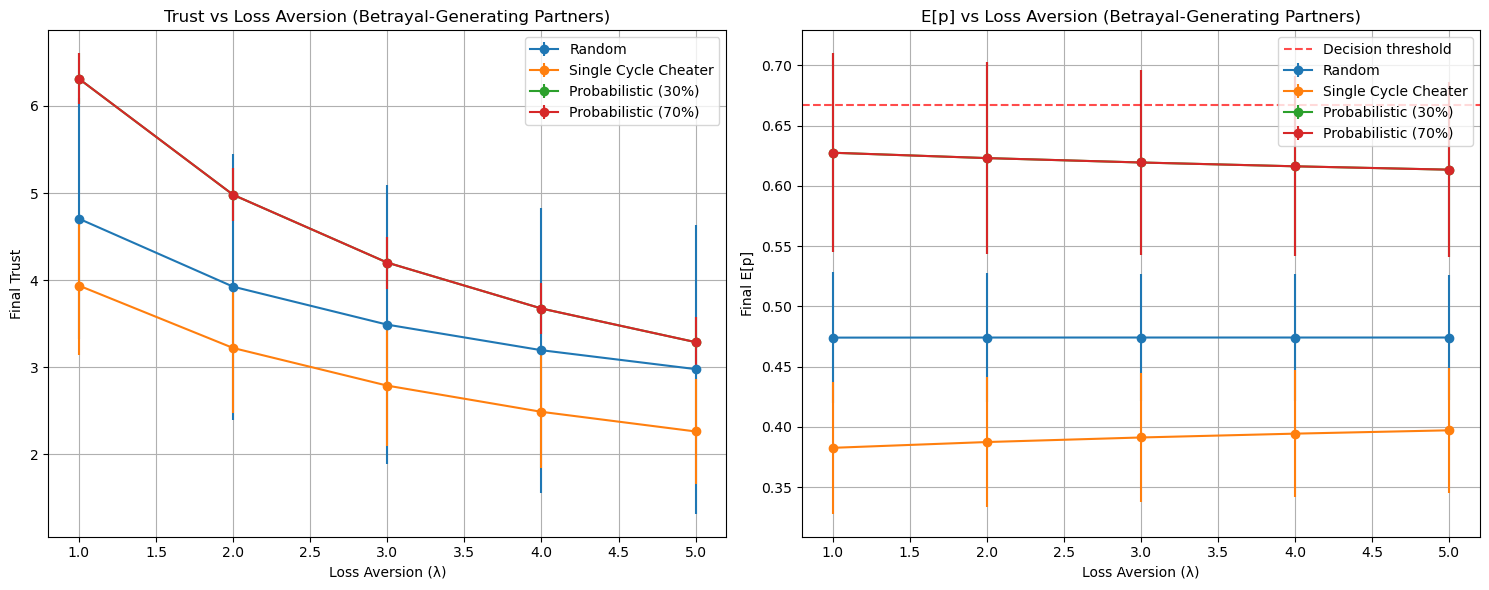

                 Partner  Loss_Aversion  Mean_Trust  Std_Trust  Mean_E_p  \
0                 Random            1.0       4.706      1.382     0.474   
1                 Random            2.0       3.926      1.526     0.474   
2                 Random            3.0       3.490      1.598     0.474   
3                 Random            4.0       3.197      1.637     0.474   
4                 Random            5.0       2.980      1.660     0.474   
5   Single Cycle Cheater            1.0       3.938      0.796     0.383   
6   Single Cycle Cheater            2.0       3.222      0.742     0.387   
7   Single Cycle Cheater            3.0       2.790      0.692     0.391   
8   Single Cycle Cheater            4.0       2.490      0.648     0.394   
9   Single Cycle Cheater            5.0       2.264      0.607     0.397   
10   Probabilistic (30%)            1.0       6.312      0.292     0.627   
11   Probabilistic (30%)            2.0       4.981      0.304     0.623   
12   Probabi

In [329]:
def detailed_loss_aversion_analysis():
    """Run detailed analysis on partners that generate betrayals"""
    
    # Test with partners that should generate betrayals
    betrayal_partners = {
        "Random": RandomPartner(),
        "Single Cycle Cheater": SingleCyclePartner(cooperate_rounds=15),  # Shorter cycle
        "Probabilistic (30%)": ProbabilisticPartner(cooperate_prob=0.3),
        "Probabilistic (70%)": ProbabilisticPartner(cooperate_prob=0.7),
    }
    
    loss_aversion_values = [1.0, 2.0, 3.0, 4.0, 5.0]
    results = []
    
    for partner_name, partner_factory in betrayal_partners.items():
        for loss_aversion in loss_aversion_values:
            # Run multiple seeds for robustness
            trust_values = []
            ep_values = []
            signal_values = []  # Add this
            
            for seed in range(5):  # 5 different seeds
                
                partner = partner_factory if callable(partner_factory) else type(partner_factory)()
                
                df = run_single_agent_simulation(
                    u_i=None,
                    num_rounds=50,
                    partner_obj=partner,
                    loss_aversion=loss_aversion,
                    lambda_surprise=0.5,
                    seed=seed
                )
                
                signal_values.append(df.iloc[-1]["Agent_Signal"])  # Moved after df is created
                
                trust_values.append(df.iloc[-1]["Agent_Trust"])
                ep_values.append(df.iloc[-1]["E_p"])
            
            results.append({
                "Partner": partner_name,
                "Loss_Aversion": loss_aversion,
                "Mean_Trust": np.mean(trust_values),
                "Std_Trust": np.std(trust_values),
                "Mean_E_p": np.mean(ep_values),
                "Mean_Signal": np.mean(signal_values),  # Add this
                "Std_Signal": np.std(signal_values),    # Add this
                "Std_E_p": np.std(ep_values)
            })
    
    return pd.DataFrame(results)

# Run the analysis
detailed_results = detailed_loss_aversion_analysis()

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot Trust
for partner in detailed_results["Partner"].unique():
    data = detailed_results[detailed_results["Partner"] == partner]
    ax1.errorbar(data["Loss_Aversion"], data["Mean_Trust"], 
                yerr=data["Std_Trust"], label=partner, marker='o')

ax1.set_xlabel("Loss Aversion (λ)")
ax1.set_ylabel("Final Trust")
ax1.set_title("Trust vs Loss Aversion (Betrayal-Generating Partners)")
ax1.legend()
ax1.grid(True)

# Plot E_p
for partner in detailed_results["Partner"].unique():
    data = detailed_results[detailed_results["Partner"] == partner]
    ax2.errorbar(data["Loss_Aversion"], data["Mean_E_p"], 
                yerr=data["Std_E_p"], label=partner, marker='o')

ax2.axhline(y=2/3, color='red', linestyle='--', alpha=0.7, label='Decision threshold')
ax2.set_xlabel("Loss Aversion (λ)")
ax2.set_ylabel("Final E[p]")
ax2.set_title("E[p] vs Loss Aversion (Betrayal-Generating Partners)")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print(detailed_results.round(3))

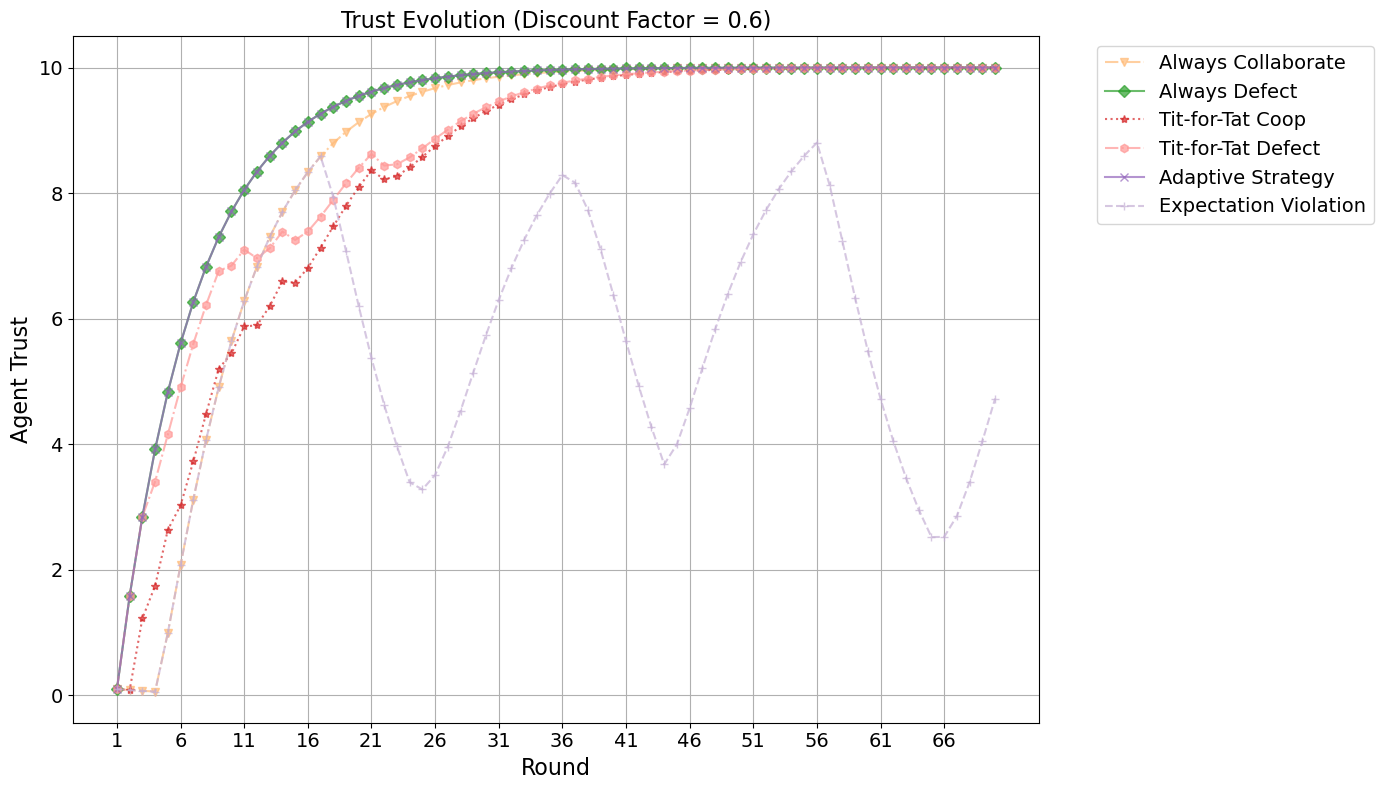

In [330]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define a distinct color palette (using seaborn's "tab10" or "tab20" for more colors)
colors = sns.color_palette("tab20", 10)  # 10 distinct colors for 10 strategies

# Define line styles and markers to differentiate the lines
line_styles = ['-', '--', ':', '-.', '-', '--', ':', '-.', '-', '--']
markers = ['o', 's', '^', 'v', 'D', 'p', '*', 'h', 'x', '+']

# Visualize Trust Evolution
plt.figure(figsize=(14, 8))  # Increase figure size

plt.plot(df_collab["Round"], df_collab["Agent_Trust"], label="Always Collaborate", 
         color=colors[3], linestyle=line_styles[3], marker=markers[3], alpha=0.7)

plt.plot(df_defect["Round"], df_defect["Agent_Trust"], label="Always Defect", 
         color=colors[4], linestyle=line_styles[4], marker=markers[4], alpha=0.7)

plt.plot(df_tit_for_tat_coop["Round"], df_tit_for_tat_coop["Agent_Trust"], label="Tit-for-Tat Coop", 
         color=colors[6], linestyle=line_styles[6], marker=markers[6], alpha=0.7)

plt.plot(df_tit_for_tat_defect["Round"], df_tit_for_tat_defect["Agent_Trust"], label="Tit-for-Tat Defect", 
         color=colors[7], linestyle=line_styles[7], marker=markers[7], alpha=0.7)

plt.plot(df_adaptive["Round"], df_adaptive["Agent_Trust"], label="Adaptive Strategy", 
         color=colors[8], linestyle=line_styles[8], marker=markers[8], alpha=0.7)

plt.plot(df_expect_violation["Round"], df_expect_violation["Agent_Trust"], label="Expectation Violation", 
         color=colors[9], linestyle=line_styles[9], marker=markers[9], alpha=0.7)

plt.xlabel("Round", fontsize=16)
plt.ylabel("Agent Trust", fontsize=16)
plt.title(f"Trust Evolution (Discount Factor = {discount_factor})", fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14)  # Move legend outside
plt.grid()
plt.xticks(ticks=np.arange(1, num_rounds + 1, step=5), fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()  # Adjust layout to make room for the legend
plt.show()

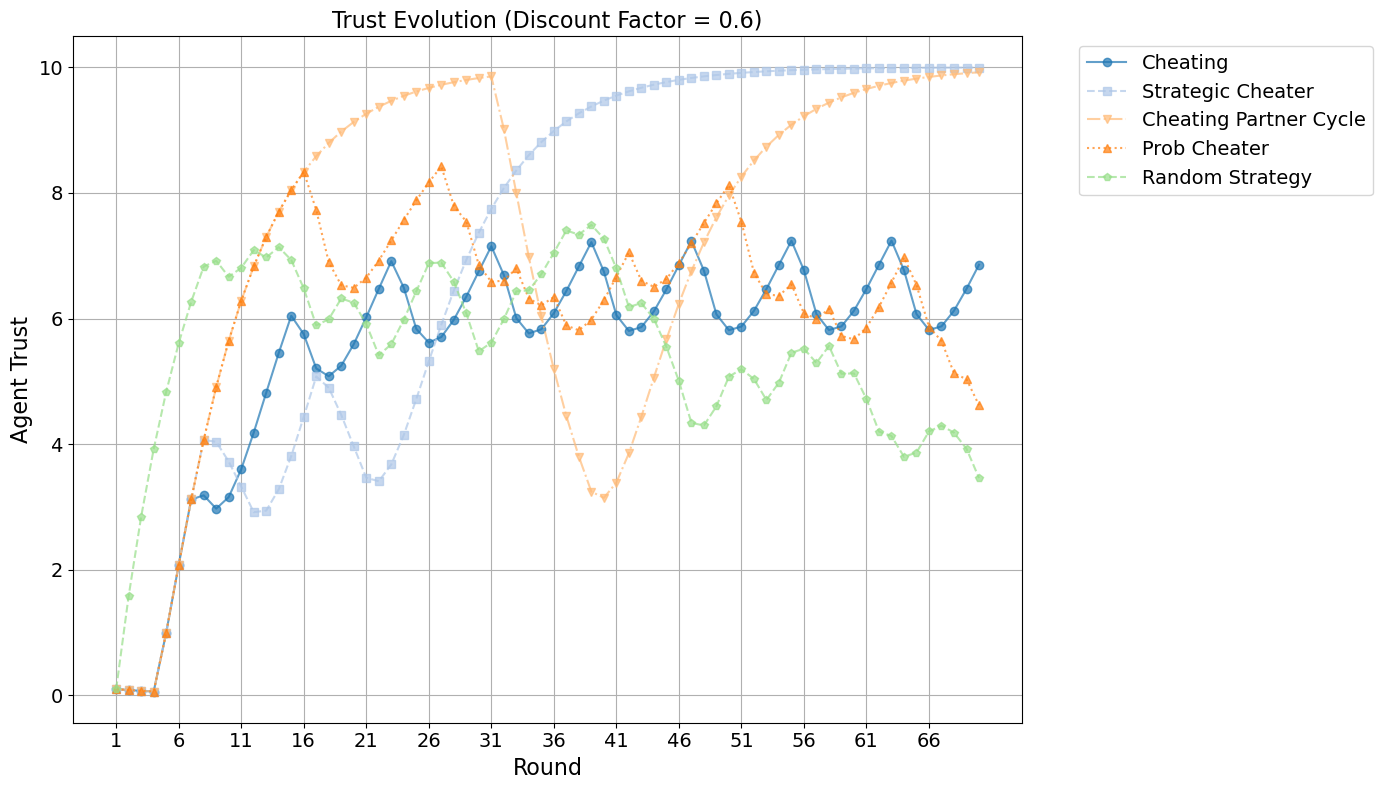

In [331]:
plt.figure(figsize=(14, 8))  # Increase figure size
plt.plot(df_cheating["Round"], df_cheating["Agent_Trust"], label="Cheating", 
         color=colors[0], linestyle=line_styles[0], marker=markers[0], alpha=0.7)
plt.plot(df_strategic_cheater["Round"], df_strategic_cheater["Agent_Trust"], label="Strategic Cheater", 
         color=colors[1], linestyle=line_styles[1], marker=markers[1], alpha=0.7)
plt.plot(df_cheating_partner_cycle["Round"], df_cheating_partner_cycle["Agent_Trust"], label="Cheating Partner Cycle",
         color=colors[3], linestyle=line_styles[3], marker=markers[3], alpha=0.7)
plt.plot(df_prob_cheater["Round"], df_prob_cheater["Agent_Trust"], label="Prob Cheater", 
         color=colors[2], linestyle=line_styles[2], marker=markers[2], alpha=0.7)
plt.plot(df_random["Round"], df_random["Agent_Trust"], label="Random Strategy", 
         color=colors[5], linestyle=line_styles[5], marker=markers[5], alpha=0.7)

plt.xlabel("Round", fontsize=16)
plt.ylabel("Agent Trust", fontsize=16)
plt.title(f"Trust Evolution (Discount Factor = {discount_factor})", fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14)  # Move legend outside
plt.grid()
plt.xticks(ticks=np.arange(1, num_rounds + 1, step=5), fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()  # Adjust layout to make room for the legend
plt.show()

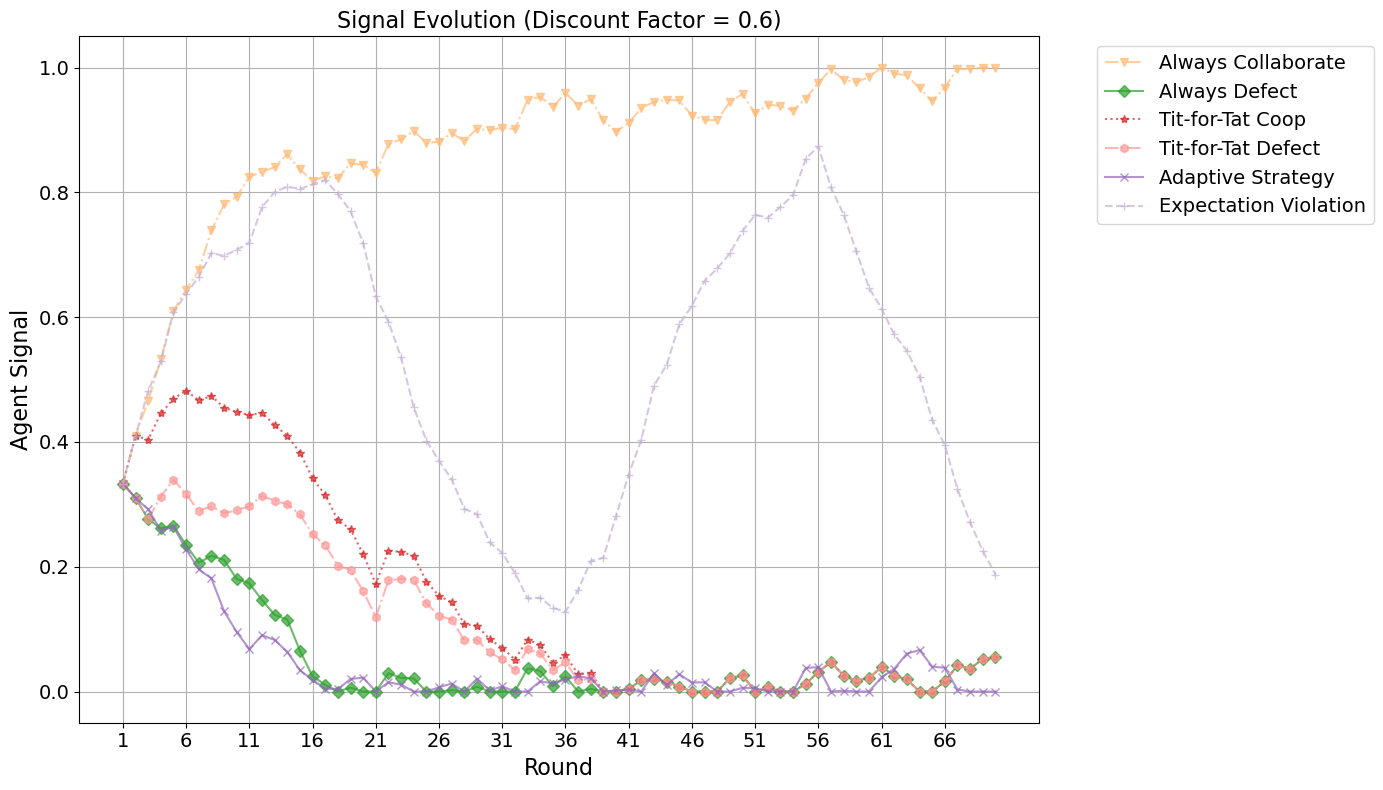

In [332]:
# Visualize Signal Evolution
plt.figure(figsize=(14, 8))  # Increase figure size

plt.plot(df_collab["Round"], df_collab["Agent_Signal"], label="Always Collaborate", 
         color=colors[3], linestyle=line_styles[3], marker=markers[3], alpha=0.7)

plt.plot(df_defect["Round"], df_defect["Agent_Signal"], label="Always Defect", 
         color=colors[4], linestyle=line_styles[4], marker=markers[4], alpha=0.7)

plt.plot(df_tit_for_tat_coop["Round"], df_tit_for_tat_coop["Agent_Signal"], label="Tit-for-Tat Coop", 
         color=colors[6], linestyle=line_styles[6], marker=markers[6], alpha=0.7)

plt.plot(df_tit_for_tat_defect["Round"], df_tit_for_tat_defect["Agent_Signal"], label="Tit-for-Tat Defect", 
         color=colors[7], linestyle=line_styles[7], marker=markers[7], alpha=0.7)

plt.plot(df_adaptive["Round"], df_adaptive["Agent_Signal"], label="Adaptive Strategy", 
         color=colors[8], linestyle=line_styles[8], marker=markers[8], alpha=0.7)

plt.plot(df_expect_violation["Round"], df_expect_violation["Agent_Signal"], label="Expectation Violation", 
         color=colors[9], linestyle=line_styles[9], marker=markers[9], alpha=0.7)


plt.xlabel("Round", fontsize=16)
plt.ylabel("Agent Signal", fontsize=16)
plt.title(f"Signal Evolution (Discount Factor = {discount_factor})", fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14)  # Move legend outside
plt.grid()
plt.xticks(ticks=np.arange(1, num_rounds + 1, step=5), fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()  # Adjust layout to make room for the legend
plt.show()

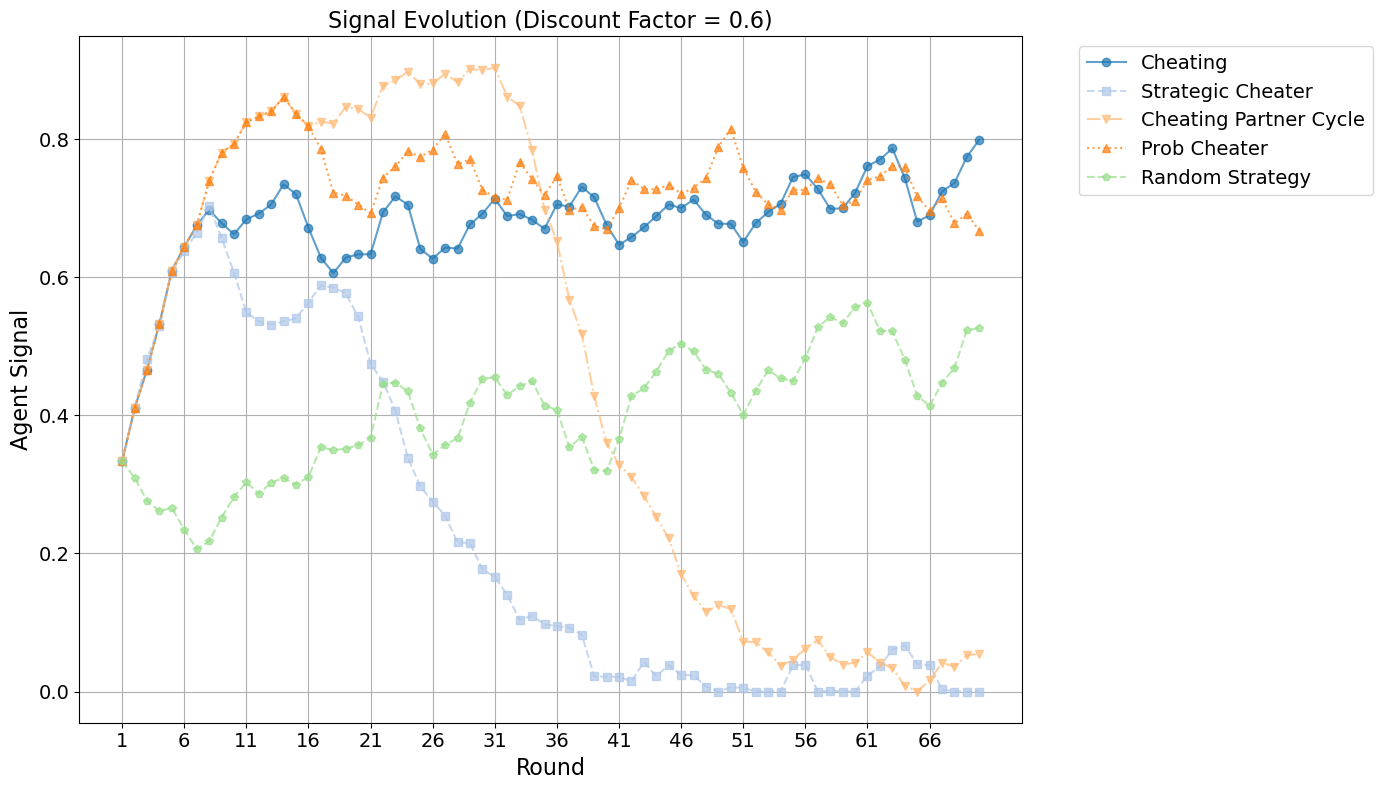

In [333]:
plt.figure(figsize=(14, 8))  # Increase figure size
plt.plot(df_cheating["Round"], df_cheating["Agent_Signal"], label="Cheating", 
         color=colors[0], linestyle=line_styles[0], marker=markers[0], alpha=0.7)
plt.plot(df_strategic_cheater["Round"], df_strategic_cheater["Agent_Signal"], label="Strategic Cheater", 
         color=colors[1], linestyle=line_styles[1], marker=markers[1], alpha=0.7)
plt.plot(df_cheating_partner_cycle["Round"], df_cheating_partner_cycle["Agent_Signal"], label="Cheating Partner Cycle",
         color=colors[3], linestyle=line_styles[3], marker=markers[3], alpha=0.7)
plt.plot(df_prob_cheater["Round"], df_prob_cheater["Agent_Signal"], label="Prob Cheater", 
         color=colors[2], linestyle=line_styles[2], marker=markers[2], alpha=0.7)
plt.plot(df_random["Round"], df_random["Agent_Signal"], label="Random Strategy", 
         color=colors[5], linestyle=line_styles[5], marker=markers[5], alpha=0.7)

plt.xlabel("Round", fontsize=16)
plt.ylabel("Agent Signal", fontsize=16)
plt.title(f"Signal Evolution (Discount Factor = {discount_factor})", fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14)  # Move legend outside 
plt.grid()
plt.xticks(ticks=np.arange(1, num_rounds + 1, step=5), fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()  # Adjust layout to make room for the legend
plt.show()

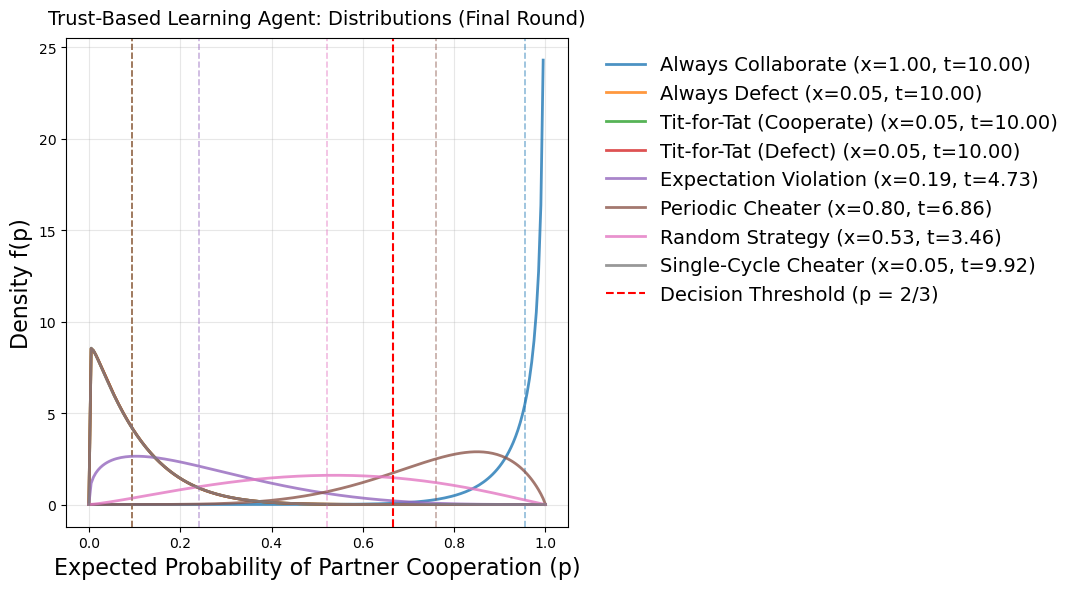

In [334]:
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import seaborn as sns

# --- Selected 8 partner strategies ---
strategies_trust = [
    ("Always Collaborate", df_collab),
    ("Always Defect", df_defect),
    ("Tit-for-Tat (Cooperate)", df_tit_for_tat_coop),
    ("Tit-for-Tat (Defect)", df_tit_for_tat_defect),
    ("Expectation Violation", df_expect_violation),
    ("Periodic Cheater", df_cheating),
    ("Random Strategy", df_random),
    ("Single-Cycle Cheater", df_cheating_partner_cycle)
]

# --- Extract last-round (final state) x and t for each partner ---
last_round_data = {}
for name, df in strategies_trust:
    last_row = df.iloc[-1]
    x = last_row["Agent_Signal"]
    t = last_row["Agent_Trust"]
    last_round_data[name] = (x, t)

# --- Plot Beta distributions based on (x, t) for each partner ---
p = np.linspace(0, 1, 200)
plt.figure(figsize=(11, 6))
colors = sns.color_palette("tab10", len(strategies_trust))

for idx, (name, (x, t)) in enumerate(last_round_data.items()):
    # Compute alpha and beta parameters
    alpha = EPS + x * t
    beta = EPS + (1 - x) * t
    E_p = alpha / (alpha + beta)
    
    # Plot the Beta PDF
    plt.plot(p, stats.beta.pdf(p, alpha, beta),
             label=f"{name} (x={x:.2f}, t={t:.2f})",
             linewidth=2, alpha=0.8, color=colors[idx])
    
    # Mark posterior mean
    plt.axvline(x=E_p, linestyle='--', linewidth=1.2, alpha=0.5, color=colors[idx])

# --- Decision threshold ---
plt.axvline(x=2/3, color='red', linestyle='--', linewidth=1.5, label='Decision Threshold (p = 2/3)')

# --- Labels & formatting ---
plt.xlabel("Expected Probability of Partner Cooperation (p)", fontsize=16)
plt.ylabel("Density f(p)", fontsize=16)
plt.title("Trust-Based Learning Agent: Distributions (Final Round)", fontsize=14, pad=10)
plt.legend(bbox_to_anchor=(1.04, 1), loc='upper left', fontsize=14, frameon=False)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


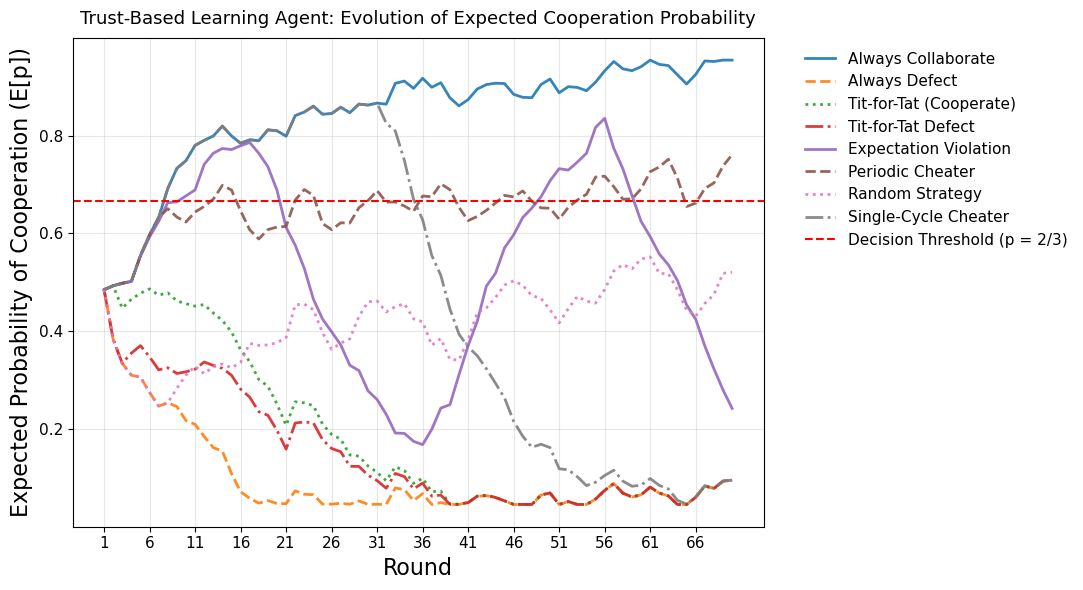

In [335]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Selected 8 partner strategies ---
strategies_trust = [
    ("Always Collaborate", df_collab),
    ("Always Defect", df_defect),
    ("Tit-for-Tat (Cooperate)", df_tit_for_tat_coop),
    ("Tit-for-Tat Defect", df_tit_for_tat_defect),
    ("Expectation Violation", df_expect_violation),
    ("Periodic Cheater", df_cheating),
    ("Random Strategy", df_random),
    ("Single-Cycle Cheater", df_cheating_partner_cycle)
]

# --- Plot setup ---
plt.figure(figsize=(11, 6))
colors = sns.color_palette("tab10", len(strategies_trust))
line_styles = ['-', '--', ':', '-.', '-', '--', ':', '-.']

# --- Plot expected probability (E[p]) evolution for all partners ---
for idx, (name, df) in enumerate(strategies_trust):
    plt.plot(df["Round"], df["E_p"],
             label=name,
             color=colors[idx],
             linestyle=line_styles[idx % len(line_styles)],
             linewidth=2,
             alpha=0.9)

# --- Decision threshold ---
plt.axhline(2/3, color='red', linestyle='--', linewidth=1.5,
            label='Decision Threshold (p = 2/3)')

# --- Formatting ---
plt.xlabel("Round", fontsize=16)
plt.ylabel("Expected Probability of Cooperation (E[p])", fontsize=16)
plt.title("Trust-Based Learning Agent: Evolution of Expected Cooperation Probability", fontsize=13, pad=10)
plt.legend(bbox_to_anchor=(1.04, 1), loc='upper left', fontsize=11, frameon=False)
plt.grid(alpha=0.3)
plt.xticks(ticks=np.arange(1, num_rounds + 1, step=5), fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()

In [336]:
def add_payoffs(df: pd.DataFrame) -> pd.DataFrame:
    p1 = df["Agent_Choice"].astype(int).to_numpy()
    p2 = df["Partner_Choice"].astype(int).to_numpy()
    out = df.copy()
    out["Agent_Payoff"]   = payoff[p1, p2, 0]
    out["Partner_Payoff"] = payoff[p1, p2, 1]
    return out

In [337]:
# Compare with decision-making trends
print("\nDecision-Making Trends in the Last Round (Trust-Based Agent):")
for i, (name, df) in enumerate(strategies_trust, 1):
    last_choice = df.iloc[-1]["Agent_Choice"]
    last_p = df.iloc[-1]["E_p"]
    print(f"{i}. {name}: p = {last_p:.3f}, Choice = {'Stag' if last_choice == 1 else 'Hare'}")


Decision-Making Trends in the Last Round (Trust-Based Agent):
1. Always Collaborate: p = 0.955, Choice = Stag
2. Always Defect: p = 0.095, Choice = Hare
3. Tit-for-Tat (Cooperate): p = 0.095, Choice = Hare
4. Tit-for-Tat Defect: p = 0.095, Choice = Hare
5. Expectation Violation: p = 0.242, Choice = Hare
6. Periodic Cheater: p = 0.761, Choice = Stag
7. Random Strategy: p = 0.521, Choice = Hare
8. Single-Cycle Cheater: p = 0.095, Choice = Hare


In [338]:
# ==============================================================================
# TRUST THRESHOLD ANALYSIS: Collaboration vs Independence Decision Boundary
# ==============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import beta

# Set up the analysis
print("=== TRUST THRESHOLD ANALYSIS ===\n")

# Theoretical collaboration threshold (deterministic case)
THEORETICAL_THRESHOLD = 2/3  # p > 2/3 for EV_stag > EV_hare
print(f"Theoretical Collaboration Threshold (no uncertainty): p > {THEORETICAL_THRESHOLD:.3f}")

# Collect all strategy data for analysis
all_strategies = [
    ("Always Collaborate", df_collab),
    ("Always Defect", df_defect), 
    ("Adaptive Strategy", df_adaptive),
    ("Tit-for-Tat Cooperate", df_tit_for_tat_coop),
    ("Tit-for-Tat Defect", df_tit_for_tat_defect),
    ("Strategic Cheater", df_strategic_cheater),
    ("Expectation Violation", df_expect_violation),
    ("Periodic Cheater", df_cheating),
    ("Single Cycle", df_cheating_partner_cycle)
]

# Initialize results storage
threshold_analysis = []

print("\n=== COLLABORATION DECISION ANALYSIS ===")
print("Strategy                 | Final p   | Final t   | Decision | Threshold Met | Trust Level")
print("-" * 90)

for name, df in all_strategies:
    if len(df) == 0:
        continue
        
    # Get final state
    final_row = df.iloc[-1]
    final_p = final_row["E_p"]
    final_t = final_row["Agent_Trust"]
    final_choice = final_row["Agent_Choice"]
    choice_str = "Stag" if final_choice == 1 else "Hare"
    
    # Determine if theoretical threshold is met
    threshold_met = "Yes" if final_p > THEORETICAL_THRESHOLD else "No"
    
    # Classify trust level
    if final_t < 1.0:
        trust_level = "Very Low"
    elif final_t < 5.0:
        trust_level = "Low"
    elif final_t < 15.0:
        trust_level = "Medium"
    elif final_t < 30.0:
        trust_level = "High"
    else:
        trust_level = "Very High"
    
    print(f"{name:<24} | {final_p:.3f}     | {final_t:.1f}     | {choice_str:<4} | {threshold_met:<13} | {trust_level}")
    
    # Store for further analysis
    threshold_analysis.append({
        'Strategy': name,
        'Final_p': final_p,
        'Final_t': final_t,
        'Choice': final_choice,
        'Threshold_Met': threshold_met == "Yes",
        'Trust_Level': trust_level
    })

# Convert to DataFrame for analysis
threshold_df = pd.DataFrame(threshold_analysis)

=== TRUST THRESHOLD ANALYSIS ===

Theoretical Collaboration Threshold (no uncertainty): p > 0.667

=== COLLABORATION DECISION ANALYSIS ===
Strategy                 | Final p   | Final t   | Decision | Threshold Met | Trust Level
------------------------------------------------------------------------------------------
Always Collaborate       | 0.955     | 10.0     | Stag | Yes           | Medium
Always Defect            | 0.095     | 10.0     | Hare | No            | Medium
Adaptive Strategy        | 0.045     | 10.0     | Hare | No            | Medium
Tit-for-Tat Cooperate    | 0.095     | 10.0     | Hare | No            | Medium
Tit-for-Tat Defect       | 0.095     | 10.0     | Hare | No            | Medium
Strategic Cheater        | 0.045     | 10.0     | Hare | No            | Medium
Expectation Violation    | 0.242     | 4.7     | Hare | No            | Low
Periodic Cheater         | 0.761     | 6.9     | Stag | Yes           | Medium
Single Cycle             | 0.095     | 9.9   

In [339]:
# ==============================================================================
# TRUST UPDATE FORMULA ANALYSIS
# ==============================================================================

print("\n" + "="*80)
print("ANALYZING THE TRUST UPDATE FORMULA")
print("="*80)

# Let's examine the trust formula step by step
def analyze_trust_formula(matches, betrayals, surprises, trust_discount=0.6, loss_aversion=3.0, lambda_surprise=0.5):
    """Analyze the trust consistency calculation"""
    
    if not matches and not betrayals and not surprises:
        return None
        
    # Calculate weights (most recent = 1.0)
    n_total = len(matches)
    weights = [trust_discount ** (n_total - 1 - i) for i in range(n_total)]
    
    # Calculate weighted sums
    WM = sum(m * w for m, w in zip(matches, weights))      # Weighted matches
    WB = sum(b * w for b, w in zip(betrayals, weights))    # Weighted betrayals  
    WU = sum(s * w for s, w in zip(surprises, weights))    # Weighted surprises
    
    # Consistency calculation
    numerator = WM
    denominator = WM + loss_aversion * WB + lambda_surprise * WU + 1e-9
    consistency = numerator / denominator
    
    return {
        'weights': weights,
        'WM': WM, 'WB': WB, 'WU': WU,
        'numerator': numerator,
        'denominator': denominator, 
        'consistency': consistency,
        'target_trust': TRUST_MIN + (TRUST_MAX - TRUST_MIN) * consistency
    }

print("Testing different scenarios:\n")

# Scenario 1: Perfect matches
print("1. PERFECT MATCHES (10 rounds, all C→C):")
matches = [1] * 10
betrayals = [0] * 10  
surprises = [0] * 10
result = analyze_trust_formula(matches, betrayals, surprises)
print(f"   Consistency: {result['consistency']:.6f}")
print(f"   Target Trust: {result['target_trust']:.3f}")

# Scenario 2: Perfect betrayals
print("\n2. PERFECT BETRAYALS (10 rounds, all C→D):")
matches = [0] * 10
betrayals = [1] * 10
surprises = [0] * 10  
result = analyze_trust_formula(matches, betrayals, surprises)
print(f"   Consistency: {result['consistency']:.6f}")
print(f"   Target Trust: {result['target_trust']:.3f}")

# Scenario 3: Mixed pattern
print("\n3. MIXED PATTERN (5 matches, 3 betrayals, 2 surprises):")
matches = [1,1,1,1,1,0,0,0,0,0] 
betrayals = [0,0,0,0,0,1,1,1,0,0]
surprises = [0,0,0,0,0,0,0,0,1,1]
result = analyze_trust_formula(matches, betrayals, surprises)
print(f"   WM={result['WM']:.3f}, WB={result['WB']:.3f}, WU={result['WU']:.3f}")
print(f"   Denominator: {result['WM']:.3f} + 3.0×{result['WB']:.3f} + 0.5×{result['WU']:.3f} = {result['denominator']:.3f}")
print(f"   Consistency: {result['WM']:.3f}/{result['denominator']:.3f} = {result['consistency']:.6f}")
print(f"   Target Trust: {result['target_trust']:.3f}")

# Scenario 4: Recent betrayal effect
print("\n4. RECENT BETRAYAL (9 matches, 1 recent betrayal):")
matches = [1,1,1,1,1,1,1,1,1,0]     # Last event is not a match
betrayals = [0,0,0,0,0,0,0,0,0,1]   # Last event is betrayal
surprises = [0,0,0,0,0,0,0,0,0,0]
result = analyze_trust_formula(matches, betrayals, surprises)
print(f"   WM={result['WM']:.3f}, WB={result['WB']:.3f} (recent betrayal has weight 1.0)")
print(f"   Consistency: {result['consistency']:.6f}")
print(f"   Target Trust: {result['target_trust']:.3f}")

print("\n" + "="*60)
print("POTENTIAL ISSUES IDENTIFIED:")
print("="*60)

# Issue 1: Trust bounds
print("\n1. TRUST BOUNDS ISSUE:")
print(f"   Current range: [{TRUST_MIN}, {TRUST_MAX}] = [0.1, 50.0]")
print(f"   With perfect consistency (1.0): target = 0.1 + (50.0-0.1)×1.0 = 49.9")
print(f"   → Most consistent partners will hit the upper bound!")

# Issue 2: Consistency calculation bias
print("\n2. CONSISTENCY CALCULATION BIAS:")
print(f"   With loss_aversion=3.0, even small betrayal rates tank consistency:")
print(f"   - 90% matches, 10% betrayals → consistency = 0.9/(0.9 + 3.0×0.1) = 0.9/1.2 = 0.75")
print(f"   - Target trust = 0.1 + 49.9×0.75 = 37.5 (very high!)")

# Issue 3: Smoothing too slow?
print(f"\n3. TRUST SMOOTHING EFFECT:")
print(f"   Current smoothing: {TRUST_SMOOTHING}")
print(f"   If current_trust=10, target_trust=40:")
print(f"   new_trust = (1-0.1)×10 + 0.1×40 = 9 + 4 = 13")
print(f"   → Only moves 3 units towards target per round")
print(f"   → Takes many rounds to reach effective levels")


ANALYZING THE TRUST UPDATE FORMULA
Testing different scenarios:

1. PERFECT MATCHES (10 rounds, all C→C):
   Consistency: 1.000000
   Target Trust: 10.000

2. PERFECT BETRAYALS (10 rounds, all C→D):
   Consistency: 0.000000
   Target Trust: 0.000

3. MIXED PATTERN (5 matches, 3 betrayals, 2 surprises):
   WM=0.179, WB=0.706, WU=1.600
   Denominator: 0.179 + 3.0×0.706 + 0.5×1.600 = 3.096
   Consistency: 0.179/3.096 = 0.057907
   Target Trust: 0.579

4. RECENT BETRAYAL (9 matches, 1 recent betrayal):
   WM=1.485, WB=1.000 (recent betrayal has weight 1.0)
   Consistency: 0.331086
   Target Trust: 3.311

POTENTIAL ISSUES IDENTIFIED:

1. TRUST BOUNDS ISSUE:
   Current range: [0.0, 10.0] = [0.1, 50.0]
   With perfect consistency (1.0): target = 0.1 + (50.0-0.1)×1.0 = 49.9
   → Most consistent partners will hit the upper bound!

2. CONSISTENCY CALCULATION BIAS:
   With loss_aversion=3.0, even small betrayal rates tank consistency:
   - 90% matches, 10% betrayals → consistency = 0.9/(0.9 + 3.


PROPOSED SOLUTIONS FOR TRUST UPDATE ISSUES

🔧 SOLUTION 1: ADJUST TRUST BOUNDS
Current: TRUST_MIN=0.1, TRUST_MAX=50.0
Problem: Upper bound too high, most strategies hit ceiling
Proposed: TRUST_MIN=0.1, TRUST_MAX=12.0 (your target effective range)

🔧 SOLUTION 2: RECALIBRATE LOSS AVERSION
Current: λ=3.0 (betrayals hurt 3x more)
Problem: Makes consistency too low, pushes trust too high
Proposed: λ=1.5-2.0 (more moderate penalty)

🔧 SOLUTION 3: INCREASE TRUST SMOOTHING
Current: TRUST_SMOOTHING=0.1 (10% towards target per round)
Problem: Too slow to reach effective levels
Proposed: TRUST_SMOOTHING=0.2-0.3 (faster adaptation)

🔧 SOLUTION 4: NONLINEAR TRUST SCALING
Current: Linear scaling from consistency to trust
Problem: High consistencies yield excessive trust
Proposed: Logarithmic or sigmoid scaling

TESTING SOLUTIONS

📊 CURRENT PARAMETERS:
   Trust evolution: 0.00 → 6.05
   Final trust: 6.05

📊 PROPOSED PARAMETERS (trust_max=12, λ=2.0, smoothing=0.2):
   Trust evolution: 0.10 → 8.77
   F

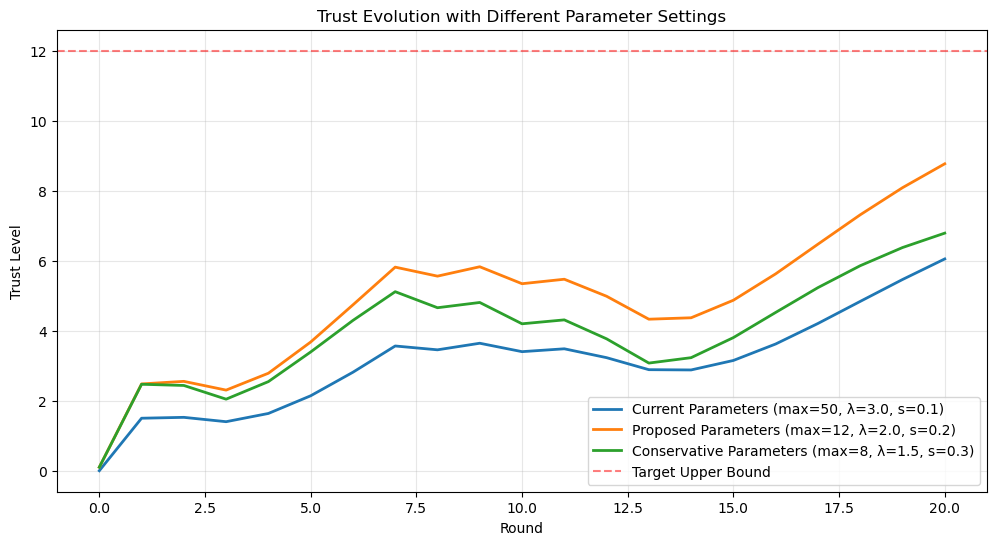


RECOMMENDATIONS
1. 🎯 REDUCE TRUST_MAX from 50 to 8-12 (your effective range)
2. 🎯 REDUCE loss_aversion from 3.0 to 1.5-2.0
3. 🎯 INCREASE trust_smoothing from 0.1 to 0.2-0.3
4. 🎯 Consider nonlinear scaling function for extreme cases
5. 🎯 Test with longer simulations to see steady-state behavior


In [340]:
# ==============================================================================
# PROPOSED SOLUTIONS AND EXPERIMENTS
# ==============================================================================

print("\n" + "="*80)
print("PROPOSED SOLUTIONS FOR TRUST UPDATE ISSUES")
print("="*80)

print("\n🔧 SOLUTION 1: ADJUST TRUST BOUNDS")
print("Current: TRUST_MIN=0.1, TRUST_MAX=50.0")
print("Problem: Upper bound too high, most strategies hit ceiling")
print("Proposed: TRUST_MIN=0.1, TRUST_MAX=12.0 (your target effective range)")

print("\n🔧 SOLUTION 2: RECALIBRATE LOSS AVERSION")
print("Current: λ=3.0 (betrayals hurt 3x more)")
print("Problem: Makes consistency too low, pushes trust too high")
print("Proposed: λ=1.5-2.0 (more moderate penalty)")

print("\n🔧 SOLUTION 3: INCREASE TRUST SMOOTHING")
print("Current: TRUST_SMOOTHING=0.1 (10% towards target per round)")
print("Problem: Too slow to reach effective levels")
print("Proposed: TRUST_SMOOTHING=0.2-0.3 (faster adaptation)")

print("\n🔧 SOLUTION 4: NONLINEAR TRUST SCALING")
print("Current: Linear scaling from consistency to trust")
print("Problem: High consistencies yield excessive trust")
print("Proposed: Logarithmic or sigmoid scaling")

print("\n" + "="*60)
print("TESTING SOLUTIONS")
print("="*60)

# Test different parameter combinations
def test_trust_parameters(trust_min=0.1, trust_max=12.0, loss_aversion=2.0, 
                         lambda_surprise=0.5, trust_smoothing=0.2, rounds=20):
    """Test trust evolution with different parameters"""
    
    agent = FocalAgent(t_init=trust_min, trust_smoothing=trust_smoothing, 
                      trust_discount=TRUST_DISCOUNT, loss_aversion=loss_aversion, 
                      lambda_surprise=lambda_surprise)
    
    # Override the constants for this test
    original_min, original_max = TRUST_MIN, TRUST_MAX
    
    trust_evolution = [agent.t]
    
    # Simulate mixed cooperation (70% cooperate, 30% defect)
    np.random.seed(42)
    for round_num in range(rounds):
        agent.x = 0.7  # Agent expects 70% cooperation
        partner_choice = 1 if np.random.random() < 0.7 else 0
        
        # Manual consistency calculation with new parameters
        expected = 1 if agent.x > 0.5 else 0
        obs = int(partner_choice)
        
        is_match = 1.0 if (obs == expected) else 0.0
        is_betrayal = 1.0 if (expected == 1 and obs == 0) else 0.0
        is_surprise = 1.0 if (expected == 0 and obs == 1) else 0.0
        
        # Build sequences
        M = (agent.trust_match_hist + [is_match]) if agent.trust_match_hist else [is_match]
        B = (agent.trust_betrayal_hist + [is_betrayal]) if agent.trust_betrayal_hist else [is_betrayal]
        U = (agent.trust_surprise_hist + [is_surprise]) if agent.trust_surprise_hist else [is_surprise]
        
        nM = len(M); wM = [agent.trust_discount ** (nM - 1 - i) for i in range(nM)]
        nB = len(B); wB = [agent.trust_discount ** (nB - 1 - i) for i in range(nB)]
        nU = len(U); wU = [agent.trust_discount ** (nU - 1 - i) for i in range(nU)]
        
        WM = sum(e*w for e, w in zip(M, wM))
        WB = sum(e*w for e, w in zip(B, wB))
        WU = sum(e*w for e, w in zip(U, wU))
        
        consistency = WM / (WM + loss_aversion*WB + lambda_surprise*WU + 1e-9)
        
        # Use new trust bounds
        target_trust = trust_min + (trust_max - trust_min) * consistency
        new_trust = (1 - trust_smoothing) * agent.t + trust_smoothing * target_trust
        new_trust = float(np.clip(new_trust, trust_min, trust_max))
        
        agent.t = new_trust
        agent.trust_match_hist.append(is_match)
        agent.trust_betrayal_hist.append(is_betrayal)
        agent.trust_surprise_hist.append(is_surprise)
        
        trust_evolution.append(agent.t)
    
    return trust_evolution

# Test current parameters
print("\n📊 CURRENT PARAMETERS:")
current_evolution = test_trust_parameters(trust_min=TRUST_MIN, trust_max=TRUST_MAX, 
                                         loss_aversion=3.0, trust_smoothing=TRUST_SMOOTHING)
print(f"   Trust evolution: {current_evolution[0]:.2f} → {current_evolution[-1]:.2f}")
print(f"   Final trust: {current_evolution[-1]:.2f}")

# Test proposed parameters
print("\n📊 PROPOSED PARAMETERS (trust_max=12, λ=2.0, smoothing=0.2):")
proposed_evolution = test_trust_parameters(trust_min=0.1, trust_max=12.0, 
                                          loss_aversion=2.0, trust_smoothing=0.2)
print(f"   Trust evolution: {proposed_evolution[0]:.2f} → {proposed_evolution[-1]:.2f}")
print(f"   Final trust: {proposed_evolution[-1]:.2f}")

# Test even more conservative
print("\n📊 CONSERVATIVE PARAMETERS (trust_max=8, λ=1.5, smoothing=0.3):")
conservative_evolution = test_trust_parameters(trust_min=0.1, trust_max=8.0, 
                                              loss_aversion=1.5, trust_smoothing=0.3)
print(f"   Trust evolution: {conservative_evolution[0]:.2f} → {conservative_evolution[-1]:.2f}")
print(f"   Final trust: {conservative_evolution[-1]:.2f}")

# Visualize the different evolutions
plt.figure(figsize=(12, 6))
plt.plot(current_evolution, label='Current Parameters (max=50, λ=3.0, s=0.1)', linewidth=2)
plt.plot(proposed_evolution, label='Proposed Parameters (max=12, λ=2.0, s=0.2)', linewidth=2)
plt.plot(conservative_evolution, label='Conservative Parameters (max=8, λ=1.5, s=0.3)', linewidth=2)
plt.axhline(y=12, color='red', linestyle='--', alpha=0.5, label='Target Upper Bound')
plt.xlabel('Round')
plt.ylabel('Trust Level')
plt.title('Trust Evolution with Different Parameter Settings')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\n" + "="*80)
print("RECOMMENDATIONS")
print("="*80)
print("1. 🎯 REDUCE TRUST_MAX from 50 to 8-12 (your effective range)")
print("2. 🎯 REDUCE loss_aversion from 3.0 to 1.5-2.0") 
print("3. 🎯 INCREASE trust_smoothing from 0.1 to 0.2-0.3")
print("4. 🎯 Consider nonlinear scaling function for extreme cases")
print("5. 🎯 Test with longer simulations to see steady-state behavior")
print("="*80)

In [341]:
df_tit_for_tat_coop


,Round,Agent_Choice,Partner_Choice,Agent_Signal,Agent_Trust,E_p
0,1,0,1,0.333333,0.100000,0.484848
1,2,1,0,0.409934,0.085000,0.492944
2,3,0,1,0.403676,1.226096,0.446946
3,4,1,0,0.445650,1.745307,0.465447
4,5,0,1,0.469045,2.637357,0.477555
...,...,...,...,...,...,...
65,66,0,0,0.016251,9.997975,0.060236
66,67,0,0,0.041750,9.998279,0.083416
67,68,0,0,0.036135,9.998537,0.078310
68,69,0,0,0.052592,9.998756,0.093270


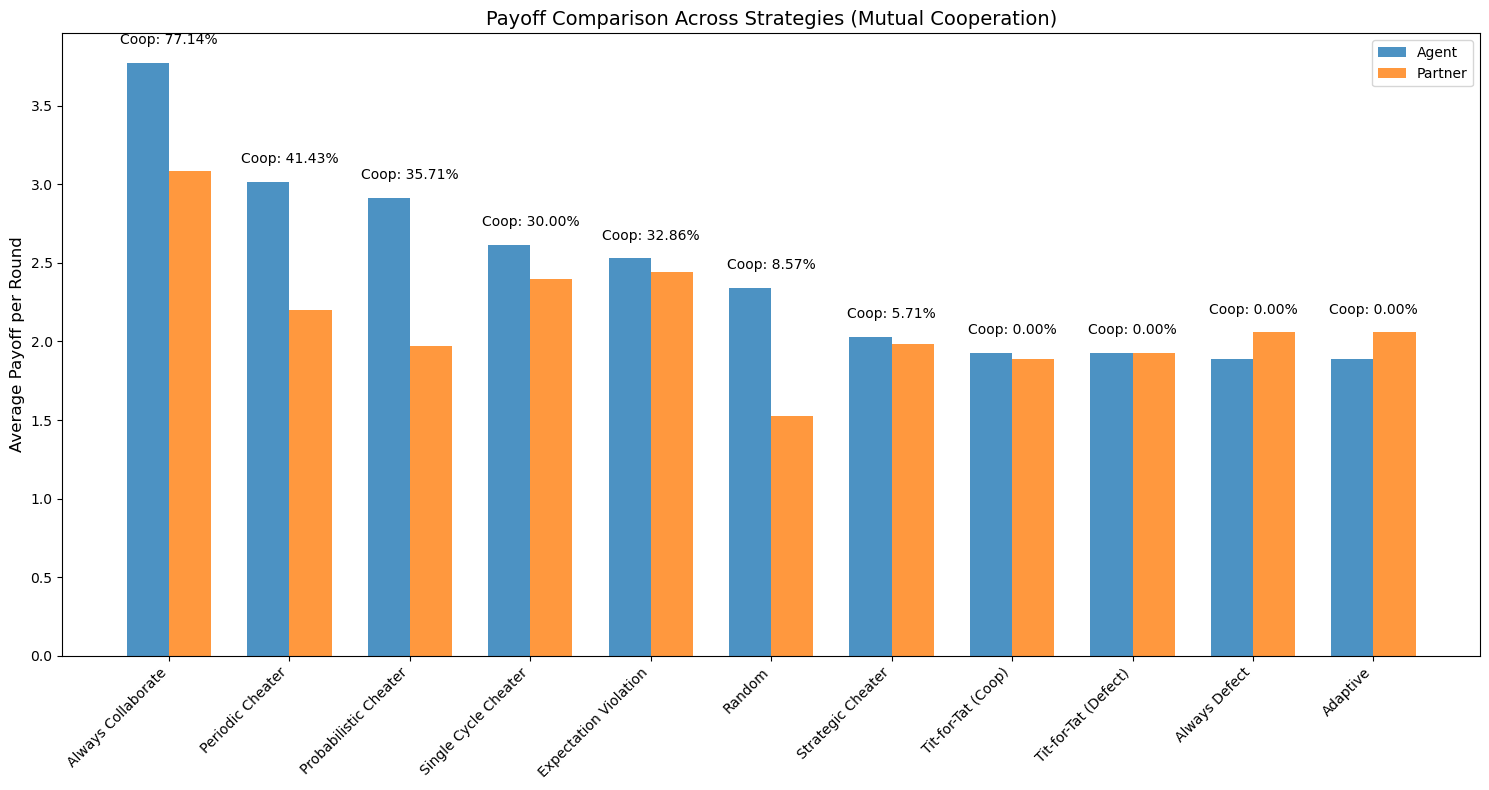


Detailed Strategy Analysis:
             Strategy  Total Agent Payoff  Total Partner Payoff  Avg Agent Payoff  Avg Partner Payoff  Mutual Cooperation Rate
   Always Collaborate                 264                   216              3.77                3.09                     0.77
     Periodic Cheater                 211                   154              3.01                2.20                     0.41
Probabilistic Cheater                 204                   138              2.91                1.97                     0.36
 Single Cycle Cheater                 183                   168              2.61                2.40                     0.30
Expectation Violation                 177                   171              2.53                2.44                     0.33
               Random                 164                   107              2.34                1.53                     0.09
    Strategic Cheater                 142                   139              2.03 

In [342]:
def analyze_payoffs(strategy_name: str, df: pd.DataFrame) -> dict:
    """Analyze payoffs for a given strategy."""
    df_with_payoff = add_payoffs(df)
    return {
        'Strategy': strategy_name,
        'Total Agent Payoff': df_with_payoff['Agent_Payoff'].sum(),
        'Total Partner Payoff': df_with_payoff['Partner_Payoff'].sum(),
        'Avg Agent Payoff': df_with_payoff['Agent_Payoff'].mean(),
        'Avg Partner Payoff': df_with_payoff['Partner_Payoff'].mean(),
        'Mutual Cooperation Rate': (df_with_payoff['Agent_Choice'] & df_with_payoff['Partner_Choice']).mean()
    }

# Analyze all strategies
strategy_results = pd.DataFrame([
    analyze_payoffs("Tit-for-Tat (Coop)", df_tit_for_tat_coop),
    analyze_payoffs("Tit-for-Tat (Defect)", df_tit_for_tat_defect),
    analyze_payoffs("Expectation Violation", df_expect_violation),
    analyze_payoffs("Periodic Cheater", df_cheating),
    analyze_payoffs("Single Cycle Cheater", df_cheating_partner_cycle),
    analyze_payoffs("Probabilistic Cheater", df_prob_cheater),
    analyze_payoffs("Strategic Cheater", df_strategic_cheater),
    analyze_payoffs("Always Collaborate", df_collab),
    analyze_payoffs("Always Defect", df_defect),
    analyze_payoffs("Random", df_random),
    analyze_payoffs("Adaptive", df_adaptive)
])

# Sort by total agent payoff to see most successful strategies
strategy_results = strategy_results.sort_values('Total Agent Payoff', ascending=False)

# Create visualization
plt.figure(figsize=(15, 8))
x = np.arange(len(strategy_results))
width = 0.35

plt.bar(x - width/2, strategy_results['Avg Agent Payoff'], width, label='Agent', alpha=0.8)
plt.bar(x + width/2, strategy_results['Avg Partner Payoff'], width, label='Partner', alpha=0.8)

plt.ylabel('Average Payoff per Round', fontsize=12)
plt.title('Payoff Comparison Across Strategies (Mutual Cooperation)', fontsize=14)
plt.xticks(x, strategy_results['Strategy'], rotation=45, ha='right')
plt.legend()

# Add cooperation rate as text on top of bars
for i, row in enumerate(strategy_results.itertuples()):
    plt.text(i, max(row._4, row._5) + 0.1, 
             f'Coop: {row._6:.2%}', 
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print detailed statistics
print("\nDetailed Strategy Analysis:")
print(strategy_results.round(2).to_string(index=False))

In [343]:
def agent_coop_rate(df: pd.DataFrame) -> float:  # fraction of rounds the agent chose Stag (1)
    return float(df["Agent_Choice"].mean())

def time_to_threshold(df: pd.DataFrame, p_star: float | None = None, direction: str | None = None) -> float | None:
    """
    First round index (1-based like 'Round') when E[p] crosses p_star.
    If direction is:
      - 'up': first time E[p] >= p_star
      - 'down': first time E[p] <= p_star
      - None: any crossing of p_star from either side (first index where sign(E[p]-p*) flips vs previous)
    Returns None if no crossing.
    """
    if p_star is None:
        p_star = stag_indifference_threshold()
    E = df["E_p"].to_numpy()
    if len(E) == 0: return None

    if direction == "up":
        idx = np.where(E >= p_star)[0]
        return int(df["Round"].iloc[idx[0]]) if idx.size>0 else None
    elif direction == "down":
        idx = np.where(E <= p_star)[0]
        return int(df["Round"].iloc[idx[0]]) if idx.size>0 else None
    else:
        # any first crossing relative to initial side
        sign0 = np.sign(E[0] - p_star)
        for i in range(1, len(E)):
            if np.sign(E[i] - p_star) != sign0:
                return int(df["Round"].iloc[i])
        return None

def final_decision(df: pd.DataFrame) -> int:
    return int(df["Agent_Choice"].iloc[-1])

In [344]:
def run_single_param_simulation(eta, md, td, ts, la, ls, seed, partner_factory, num_rounds, threshold_direction):
    """Helper function that runs a single parameter set simulation"""
    p_star = stag_indifference_threshold()
    partner = partner_factory()  # fresh partner instance
    
    df = run_single_agent_simulation(
        u_i=None,
        stochastic=True,
        inv_temp=2.0,
        seed=seed,
        num_rounds=num_rounds,
        partner_obj=partner,
        memory_discount=md,
        trust_discount=td,
        trust_smoothing=ts,
        eta=eta,
        loss_aversion=la,
        lambda_surprise=ls
    )
    
    # Compute requested outputs
    return {
        "eta": eta,
        "memory_discount": md,
        "trust_discount": td,
        "trust_smoothing": ts,
        "loss_aversion": la,
        "lambda_surprise": ls,
        "seed": seed,
        "agent_coop_rate": agent_coop_rate(df),
        "E_p_last": float(df["E_p"].iloc[-1]),
        "final_decision": final_decision(df),
        "time_to_threshold": time_to_threshold(df, p_star=p_star, direction=threshold_direction)
    }

In [345]:
def sweep_learning_params(
    partner_factory,
    eta_grid = np.linspace(0.0, 1.0, 6),
    memory_discount_grid = np.linspace(0.0, 1.0, 4),
    trust_discount_grid = np.linspace(0.0, 1.0, 4),
    trust_smoothing_grid = np.linspace(0.0, 1.0, 4),
    loss_aversion_grid = np.linspace(1.0, 5.0, 5),
    lambda_surprise_grid = np.linspace(0.0, 1.0, 4),
    seeds = (42,),  # Changed to only use seed 42
    num_rounds = 70,
    threshold_direction: str | None = None,  # 'up' or 'down' or None
    n_jobs = -1,  # Use all available cores by default
    verbose = 10   # Progress reporting level
) -> pd.DataFrame:
    """Parallelized parameter sweep"""
    param_combinations = []
    for eta, md, td, ts, la, ls, seed in product(
        eta_grid, memory_discount_grid, trust_discount_grid, trust_smoothing_grid,
        loss_aversion_grid, lambda_surprise_grid, seeds
    ):
        param_combinations.append((eta, md, td, ts, la, ls, seed))
    
    # Run simulations in parallel
    results = Parallel(n_jobs=n_jobs, verbose=verbose)(
        delayed(run_single_param_simulation)(
            eta, md, td, ts, la, ls, seed, 
            partner_factory, num_rounds, threshold_direction
        ) for eta, md, td, ts, la, ls, seed in param_combinations
    )
    
    return pd.DataFrame(results)

In [346]:
def get_sweep_results(filename, partner_factory_func, threshold_direction, run_new=False):
    """
    Get parameter sweep results - either load from CSV or run new simulations
    
    Args:
        filename: CSV file to save/load from
        partner_factory_func: Function that creates a partner instance
        threshold_direction: Direction for threshold calculation
        run_new: Force running new simulations even if file exists
    """
    if os.path.exists(filename) and not run_new:
        print(f"Loading existing results from {filename}")
        return pd.read_csv(filename)
    else:
        print(f"Running new simulations for {filename}")
        results = sweep_learning_params(
            partner_factory=partner_factory_func,
            seeds=(42,),  # Changed to only use seed 42
            threshold_direction=threshold_direction,
            n_jobs=-1
        )
        results.to_csv(filename, index=False)
        return results

In [347]:
df_sens_TitForTatCoop = get_sweep_results(
    "results_TitForTatCoop.csv", 
    lambda: TitForTatCooperatePartner(), 
    "up",
)
df_sens_TitForTatDefect = get_sweep_results(
    "results_TitForTatDefect.csv",
    lambda: TitForTatDefectPartner(),
    "down"
)
df_sens_AlwaysDefect = get_sweep_results(
    "results_AlwaysDefect.csv", 
    lambda: AlwaysDefectPartner(), 
    "down"
)
df_sens_AlwaysCollaborate = get_sweep_results(
    "results_AlwaysCollaborate.csv", 
    lambda: AlwaysCollaboratePartner(), 
    "up"
)
df_sens_SingleCycleCheater = get_sweep_results(
    "results_SingleCycleCheater.csv",  
    lambda: SingleCyclePartner(cooperate_rounds=30),
    "down"
)

df_sens_StrategicCheater = get_sweep_results(
    "results_StrategicCheater.csv",
    lambda: StrategicCheaterPartner(t_threshold=2.5),
    "down"
)
df_sens_Random = get_sweep_results(
    "results_Random.csv",
    lambda: RandomPartner(),
    "down"
)

Loading existing results from results_TitForTatCoop.csv
Loading existing results from results_TitForTatDefect.csv
Loading existing results from results_AlwaysDefect.csv
Loading existing results from results_AlwaysCollaborate.csv
Loading existing results from results_SingleCycleCheater.csv
Loading existing results from results_StrategicCheater.csv
Loading existing results from results_Random.csv


In [348]:
def plot_expected_prob_grid(
    df_dict,  # Dictionary of {partner_name: dataframe}
    knob_map=None,  # mapping df-column -> pretty label
    knobs=None,  # list of df columns to plot as lines
    outcome="E_p_last",
    normalize_x=True,
    title="Parameter Sensitivity Analysis Across Partner Strategies",
    figsize=(16, 12),
    threshold_line=True
):
    """
    Creates a grid of subplots showing parameter sensitivity for multiple partner strategies.
    
    Args:
        df_dict: Dictionary mapping partner strategy names to their dataframes
        knob_map: Dictionary mapping parameter names to display names
        knobs: List of parameters to analyze
        outcome: Column to use as outcome (default: E_p_last)
        normalize_x: Whether to normalize parameter values to [0,1]
        title: Overall figure title
        figsize: Figure size as (width, height)
        threshold_line: Whether to draw decision threshold line at 2/3
    """
    # Default knob list (updated to match current parameters)
    if knobs is None:
        knobs = [
            "eta", "memory_discount", "trust_discount", "trust_smoothing", "lambda_surprise"
        ]

    # Pretty legend names (updated to match current parameters)
    if knob_map is None:
        knob_map = {
            "eta": "Learning rate (η)",
            "memory_discount": "Memory discount (md)",
            "trust_discount": "Trust discount (td)",
            "trust_smoothing": "Trust smoothing (ts)",
            "lambda_surprise": "Surprise penalty (λs)"
        }
    
    # Calculate grid dimensions
    n_partners = len(df_dict)
    cols = min(3, n_partners)
    rows = (n_partners + cols - 1) // cols
    
    # Create figure with shared legend
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(rows + 1, cols)  # +1 for legend at bottom
    
    # Create color palette for all subplots to share
    colors = sns.color_palette("tab10", n_colors=len(knobs))
    
    # For storing handles for legend
    legend_handles = []
    legend_labels = []
    
    # Create subplots
    for i, (partner_name, df) in enumerate(df_dict.items()):
        row, col = i // cols, i % cols
        ax = fig.add_subplot(gs[row, col])
        
        # Apply the plotting for this partner's data
        for ci, k in enumerate(knobs):
            if k not in df.columns:
                continue
                
            # Aggregate data
            g = (df.groupby(k, as_index=False)
                  .agg(mean_y=(outcome, "mean"),
                       std_y=(outcome, "std"),
                       n=("seed", "count") if "seed" in df.columns else (outcome, "count")))
            g["sem_y"] = g["std_y"] / np.sqrt(g["n"].clip(lower=1))
            
            # Sort by x
            g = g.sort_values(k)
            
            # Normalize x if requested
            if normalize_x:
                x_min, x_max = g[k].min(), g[k].max()
                if np.isclose(x_min, x_max):
                    g["xnorm"] = 0.5
                else:
                    g["xnorm"] = (g[k] - x_min) / (x_max - x_min)
                x = g["xnorm"]
            else:
                x = g[k]
                
            # Plot line
            line, = ax.plot(x, g["mean_y"], marker="o", lw=2, alpha=0.9, 
                     color=colors[ci], label=knob_map.get(k,k))
            
            # Add confidence band
            ax.fill_between(x, g["mean_y"]-g["sem_y"], g["mean_y"]+g["sem_y"],
                         color=colors[ci], alpha=0.15)
            
            # Store handle for first subplot only (for legend)
            if i == 0:
                legend_handles.append(line)
                legend_labels.append(knob_map.get(k,k))
        
        # Add decision threshold line
        if threshold_line:
            ax.axhline(y=2/3, color='red', linestyle='--', alpha=0.7)
            
        # Customize subplot
        ax.set_ylim(0, 1)
        ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
        ax.set_title(f"{partner_name}", fontsize=12)
        
        # Add labels only for edge subplots
        if col == 0:  # leftmost column
            ax.set_ylabel("Final Expected Probability [E(p)]")
        if row == rows - 1 or i == n_partners - 1:  # bottom row
            ax.set_xlabel("Normalized parameter value")
            
        ax.grid(alpha=0.3)
    
    # Add the threshold line to legend
    if threshold_line:
        thresh_line = plt.Line2D([0], [0], color='red', linestyle='--', alpha=0.7)
        legend_handles.append(thresh_line)
        legend_labels.append('Decision threshold (p*=2/3)')
        
    # Add shared legend at the bottom
    fig.add_subplot(gs[rows, :])
    plt.axis('off')
    plt.legend(legend_handles, legend_labels, loc='center', ncol=4, frameon=False)
    
    # Overall title
    fig.suptitle(title, fontsize=16, y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    return fig


def plot_loss_aversion_grid(
    df_dict,  # Dictionary of {partner_name: dataframe}
    outcome="E_p_last",
    title="Loss Aversion Sensitivity Analysis Across Partner Strategies",
    figsize=(16, 10),
    threshold_line=True
):
    """
    Creates a grid of subplots showing loss_aversion sensitivity for multiple partner strategies.
    
    Args:
        df_dict: Dictionary mapping partner strategy names to their dataframes
        outcome: Column to use as outcome (default: E_p_last)
        title: Overall figure title
        figsize: Figure size as (width, height)
        threshold_line: Whether to draw decision threshold line at 2/3
    """
    
    # Calculate grid dimensions
    n_partners = len(df_dict)
    cols = min(3, n_partners)
    rows = (n_partners + cols - 1) // cols
    
    # Create figure
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(rows + 1, cols)  # +1 for legend at bottom
    
    # Color for loss_aversion line
    color = sns.color_palette("tab10")[0]  # Use first color from palette
    
    # For storing handles for legend
    legend_handles = []
    legend_labels = []
    
    # Create subplots
    for i, (partner_name, df) in enumerate(df_dict.items()):
        row, col = i // cols, i % cols
        ax = fig.add_subplot(gs[row, col])
        
        # Check if loss_aversion column exists
        if "loss_aversion" not in df.columns:
            ax.text(0.5, 0.5, "No loss_aversion data", ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f"{partner_name}", fontsize=12)
            continue
                
        # Aggregate data for loss_aversion
        g = (df.groupby("loss_aversion", as_index=False)
              .agg(mean_y=(outcome, "mean"),
                   std_y=(outcome, "std"),
                   n=("seed", "count") if "seed" in df.columns else (outcome, "count")))
        g["sem_y"] = g["std_y"] / np.sqrt(g["n"].clip(lower=1))
        
        # Sort by x
        g = g.sort_values("loss_aversion")
        
        # Plot line
        line, = ax.plot(g["loss_aversion"], g["mean_y"], marker="o", lw=2, alpha=0.9, 
                 color=color, label="Loss aversion (λ)")
        
        # Add confidence band
        ax.fill_between(g["loss_aversion"], g["mean_y"]-g["sem_y"], g["mean_y"]+g["sem_y"],
                     color=color, alpha=0.15)
        
        # Store handle for first subplot only (for legend)
        if i == 0:
            legend_handles.append(line)
            legend_labels.append("Loss aversion (λ)")
        
        # Add decision threshold line
        if threshold_line:
            ax.axhline(y=2/3, color='red', linestyle='--', alpha=0.7)
            
        # Customize subplot
        ax.set_ylim(0, 1)
        ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
        ax.set_xlim(0.8, 5.2)  # loss_aversion ranges from 1 to 5
        ax.set_title(f"{partner_name}", fontsize=12)
        
        # Add labels only for edge subplots
        if col == 0:  # leftmost column
            ax.set_ylabel("Final Expected Probability [E(p)]")
        if row == rows - 1 or i == n_partners - 1:  # bottom row
            ax.set_xlabel("Loss Aversion (λ)")
            
        ax.grid(alpha=0.3)
    
    # Add the threshold line to legend
    if threshold_line and legend_handles:
        thresh_line = plt.Line2D([0], [0], color='red', linestyle='--', alpha=0.7)
        legend_handles.append(thresh_line)
        legend_labels.append('Decision threshold (p*=2/3)')
        
    # Add shared legend at the bottom
    fig.add_subplot(gs[rows, :])
    plt.axis('off')
    if legend_handles:
        plt.legend(legend_handles, legend_labels, loc='center', ncol=3, frameon=False)
    
    # Overall title
    fig.suptitle(title, fontsize=16, y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    return fig

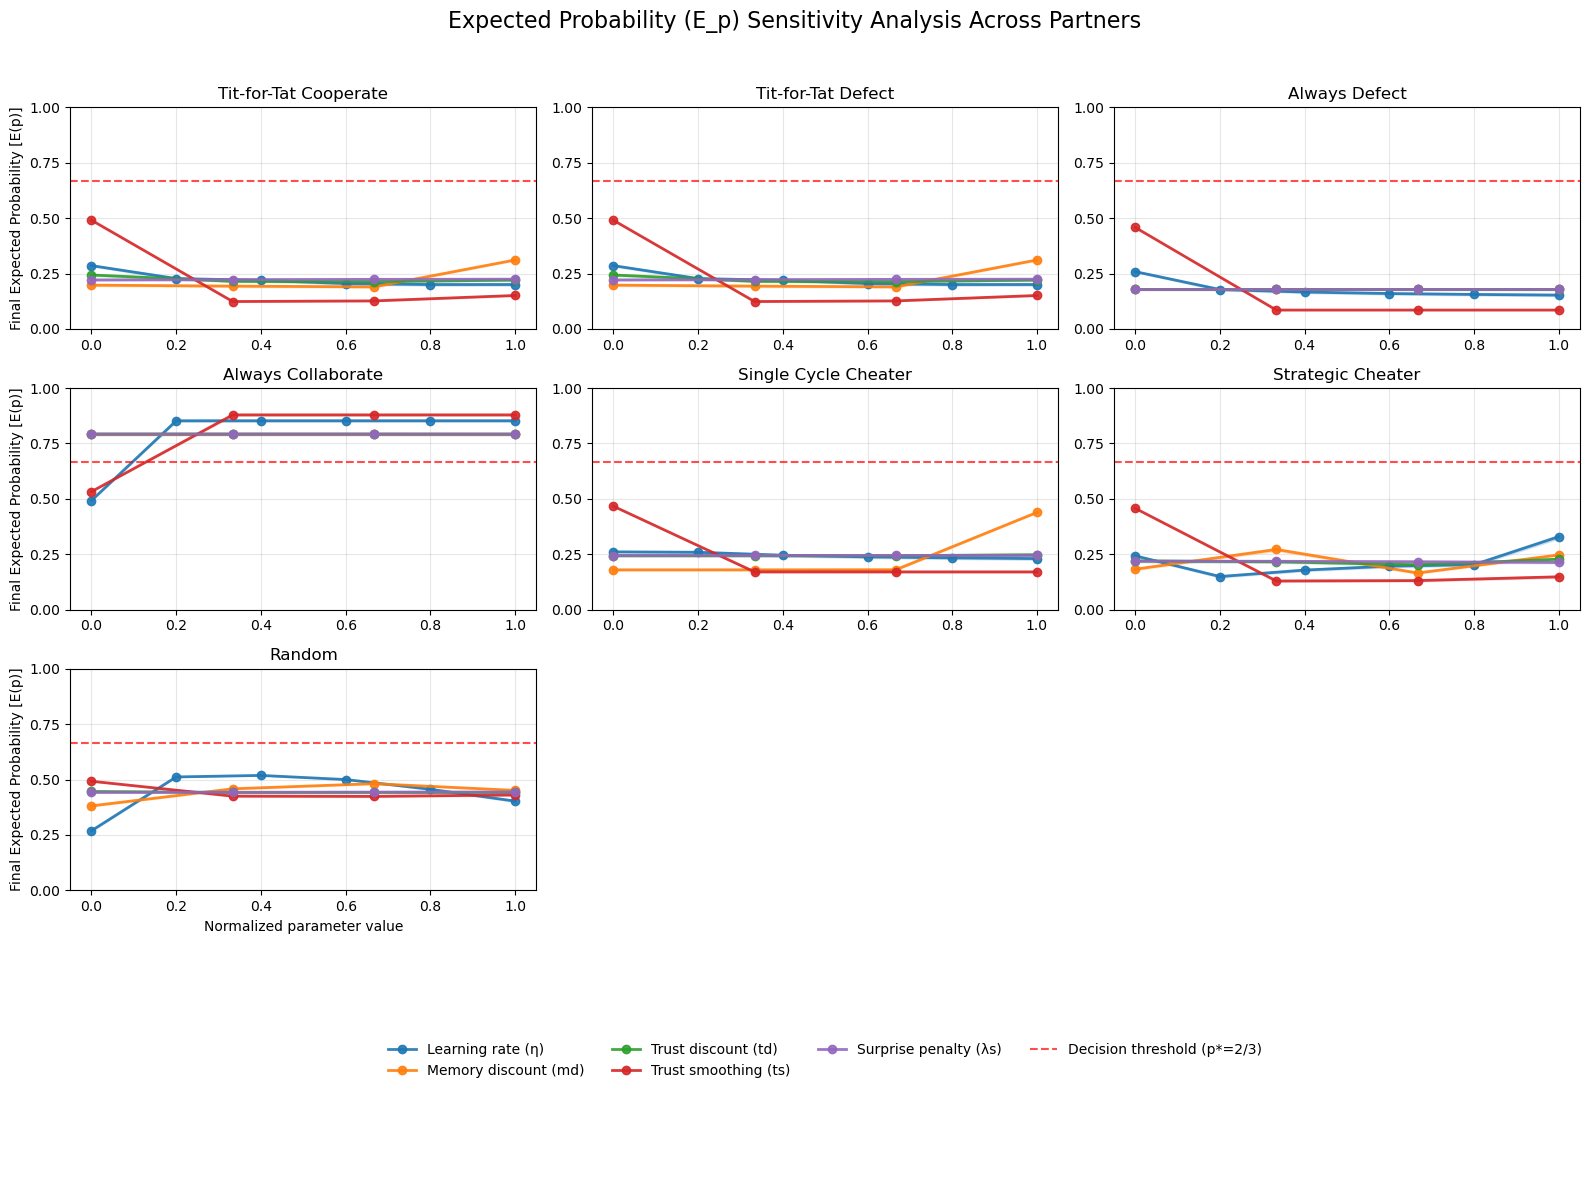

In [349]:
# Create a dictionary of dataframes for different partners
partner_dfs = {
    "Tit-for-Tat Cooperate": df_sens_TitForTatCoop,
    "Tit-for-Tat Defect": df_sens_TitForTatDefect,
    "Always Defect": df_sens_AlwaysDefect,
    "Always Collaborate": df_sens_AlwaysCollaborate,
    "Single Cycle Cheater": df_sens_SingleCycleCheater, 
    "Strategic Cheater": df_sens_StrategicCheater,
    "Random": df_sens_Random
}

# Create the grid visualization for general parameters
fig = plot_expected_prob_grid(
    partner_dfs,
    title="Expected Probability (E_p) Sensitivity Analysis Across Partners"
)
plt.show()

In [350]:
def plot_final_decision_grid(
    df_dict,  # Dictionary of {partner_name: dataframe}
    knob_map=None,  # mapping df-column -> pretty label
    knobs=None,  # list of df columns to plot as lines
    outcome="final_decision",
    normalize_x=True,
    title="Parameter Sensitivity Analysis Across Partner Strategies",
    figsize=(16, 12),
    threshold_line=True
):
    """
    Creates a grid of subplots showing parameter sensitivity for multiple partner strategies.
    
    Args:
        df_dict: Dictionary mapping partner strategy names to their dataframes
        knob_map: Dictionary mapping parameter names to display names
        knobs: List of parameters to analyze
        outcome: Column to use as outcome (default: final_decision)
        normalize_x: Whether to normalize parameter values to [0,1]
        title: Overall figure title
        figsize: Figure size as (width, height)
        threshold_line: Whether to draw decision threshold line at 2/3
    """
    # Default knob list (updated to match current parameters)
    if knobs is None:
        knobs = [
            "eta", "memory_discount", "trust_discount", "trust_smoothing", "lambda_surprise"
        ]

    # Pretty legend names (updated to match current parameters)
    if knob_map is None:
        knob_map = {
            "eta": "Learning rate (η)",
            "memory_discount": "Memory discount (md)",
            "trust_discount": "Trust discount (td)",
            "trust_smoothing": "Trust smoothing (ts)",
            "lambda_surprise": "Surprise penalty (λs)"
        }
    
    # Calculate grid dimensions
    n_partners = len(df_dict)
    cols = min(3, n_partners)
    rows = (n_partners + cols - 1) // cols
    
    # Create figure with shared legend
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(rows + 1, cols)  # +1 for legend at bottom
    
    # Create color palette for all subplots to share
    colors = sns.color_palette("tab10", n_colors=len(knobs))
    
    # For storing handles for legend
    legend_handles = []
    legend_labels = []
    
    # Create subplots
    for i, (partner_name, df) in enumerate(df_dict.items()):
        row, col = i // cols, i % cols
        ax = fig.add_subplot(gs[row, col])
        
        # Apply the plotting for this partner's data
        for ci, k in enumerate(knobs):
            if k not in df.columns:
                continue
                
            # Aggregate data
            g = (df.groupby(k, as_index=False)
                  .agg(mean_y=(outcome, "mean"),
                       std_y=(outcome, "std"),
                       n=("seed", "count") if "seed" in df.columns else (outcome, "count")))
            g["sem_y"] = g["std_y"] / np.sqrt(g["n"].clip(lower=1))
            
            # Sort by x
            g = g.sort_values(k)
            
            # Normalize x if requested
            if normalize_x:
                x_min, x_max = g[k].min(), g[k].max()
                if np.isclose(x_min, x_max):
                    g["xnorm"] = 0.5
                else:
                    g["xnorm"] = (g[k] - x_min) / (x_max - x_min)
                x = g["xnorm"]
            else:
                x = g[k]
                
            # Plot line
            line, = ax.plot(x, g["mean_y"], marker="o", lw=2, alpha=0.9, 
                     color=colors[ci], label=knob_map.get(k,k))
            
            # Add confidence band
            ax.fill_between(x, g["mean_y"]-g["sem_y"], g["mean_y"]+g["sem_y"],
                         color=colors[ci], alpha=0.15)
            
            # Store handle for first subplot only (for legend)
            if i == 0:
                legend_handles.append(line)
                legend_labels.append(knob_map.get(k,k))
        
        # Add decision threshold line
        if threshold_line:
            ax.axhline(y=2/3, color='red', linestyle='--', alpha=0.7)
            
        # Customize subplot
        ax.set_ylim(0, 1)
        ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
        ax.set_title(f"{partner_name}", fontsize=12)
        
        # Add labels only for edge subplots
        if col == 0:  # leftmost column
            ax.set_ylabel("Final Decision (Stag=1, Hare=0)")
        if row == rows - 1 or i == n_partners - 1:  # bottom row
            ax.set_xlabel("Normalized parameter value")
            
        ax.grid(alpha=0.3)
    
    # Add the threshold line to legend
    if threshold_line:
        thresh_line = plt.Line2D([0], [0], color='red', linestyle='--', alpha=0.7)
        legend_handles.append(thresh_line)
        legend_labels.append('Decision threshold (p*=2/3)')
        
    # Add shared legend at the bottom
    fig.add_subplot(gs[rows, :])
    plt.axis('off')
    plt.legend(legend_handles, legend_labels, loc='center', ncol=4, frameon=False)
    
    # Overall title
    fig.suptitle(title, fontsize=16, y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    return fig


def plot_loss_aversion_grid_FinalDecision(
    df_dict,  # Dictionary of {partner_name: dataframe}
    outcome="final_decision",
    title="Loss Aversion Sensitivity Analysis Across Partner Strategies",
    figsize=(16, 10),
    threshold_line=True
):
    """
    Creates a grid of subplots showing loss_aversion sensitivity for multiple partner strategies.
    
    Args:
        df_dict: Dictionary mapping partner strategy names to their dataframes
        outcome: Column to use as outcome (default: final_decision)
        title: Overall figure title
        figsize: Figure size as (width, height)
        threshold_line: Whether to draw decision threshold line at 2/3
    """
    
    # Calculate grid dimensions
    n_partners = len(df_dict)
    cols = min(3, n_partners)
    rows = (n_partners + cols - 1) // cols
    
    # Create figure
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(rows + 1, cols)  # +1 for legend at bottom
    
    # Color for loss_aversion line
    color = sns.color_palette("tab10")[0]  # Use first color from palette
    
    # For storing handles for legend
    legend_handles = []
    legend_labels = []
    
    # Create subplots
    for i, (partner_name, df) in enumerate(df_dict.items()):
        row, col = i // cols, i % cols
        ax = fig.add_subplot(gs[row, col])
        
        # Check if loss_aversion column exists
        if "loss_aversion" not in df.columns:
            ax.text(0.5, 0.5, "No loss_aversion data", ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f"{partner_name}", fontsize=12)
            continue
                
        # Aggregate data for loss_aversion
        g = (df.groupby("loss_aversion", as_index=False)
              .agg(mean_y=(outcome, "mean"),
                   std_y=(outcome, "std"),
                   n=("seed", "count") if "seed" in df.columns else (outcome, "count")))
        g["sem_y"] = g["std_y"] / np.sqrt(g["n"].clip(lower=1))
        
        # Sort by x
        g = g.sort_values("loss_aversion")
        
        # Plot line
        line, = ax.plot(g["loss_aversion"], g["mean_y"], marker="o", lw=2, alpha=0.9, 
                 color=color, label="Loss aversion (λ)")
        
        # Add confidence band
        ax.fill_between(g["loss_aversion"], g["mean_y"]-g["sem_y"], g["mean_y"]+g["sem_y"],
                     color=color, alpha=0.15)
        
        # Store handle for first subplot only (for legend)
        if i == 0:
            legend_handles.append(line)
            legend_labels.append("Loss aversion (λ)")
        
        # Add decision threshold line
        if threshold_line:
            ax.axhline(y=2/3, color='red', linestyle='--', alpha=0.7)
            
        # Customize subplot
        ax.set_ylim(0, 1)
        ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
        ax.set_xlim(0.8, 5.2)  # loss_aversion ranges from 1 to 5
        ax.set_title(f"{partner_name}", fontsize=12)
        
        # Add labels only for edge subplots
        if col == 0:  # leftmost column
            ax.set_ylabel("Final Decision (Stag=1, Hare=0)")
        if row == rows - 1 or i == n_partners - 1:  # bottom row
            ax.set_xlabel("Loss Aversion (λ)")
            
        ax.grid(alpha=0.3)
    
    # Add the threshold line to legend
    if threshold_line and legend_handles:
        thresh_line = plt.Line2D([0], [0], color='red', linestyle='--', alpha=0.7)
        legend_handles.append(thresh_line)
        legend_labels.append('Decision threshold (p*=2/3)')
        
    # Add shared legend at the bottom
    fig.add_subplot(gs[rows, :])
    plt.axis('off')
    if legend_handles:
        plt.legend(legend_handles, legend_labels, loc='center', ncol=3, frameon=False)
    
    # Overall title
    fig.suptitle(title, fontsize=16, y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    return fig

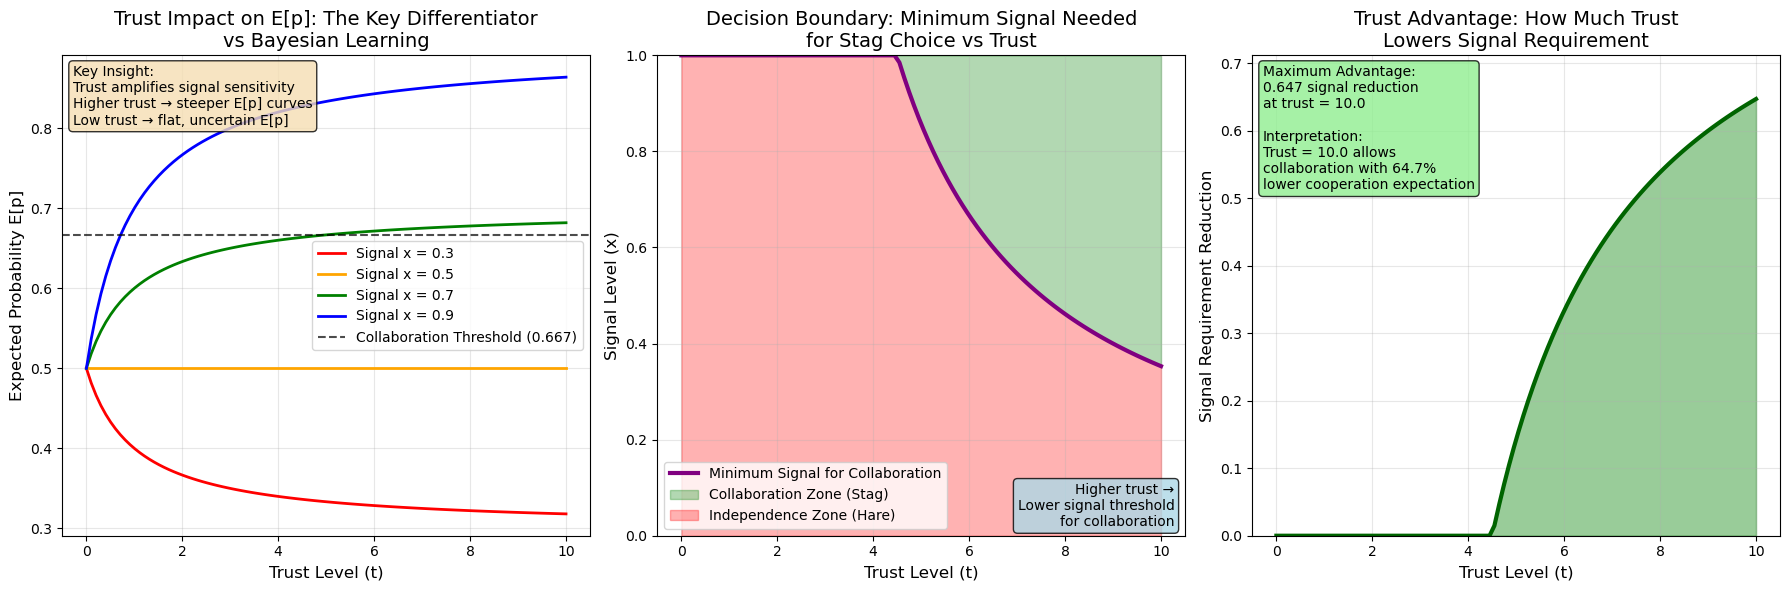


TRUST IMPACT ANALYSIS SUMMARY

 PARAMETER SETTINGS:
   Trust Range: [0.0, 10.0]
   Loss Aversion (λ): 2.0
   Trust Smoothing: 0.15
   Collaboration Threshold: p > 0.667

 KEY FINDINGS:
   Maximum Trust Advantage: 0.647 signal reduction
   Optimal Trust Level: 10.0
   Signal Threshold at Min Trust: 1.000
   Signal Threshold at Max Trust: 0.353

 RESEARCH IMPLICATIONS:
   1. Trust acts as a 'collaboration enabler' by lowering signal thresholds
   2. Diminishing returns: Trust advantage plateaus at ~10
   3. Critical difference from Bayesian learning: confidence modulates sensitivity
   4. Low trust creates collaboration barriers even with favorable signals


In [351]:
# ============================================================================
# TRUST IMPACT ANALYSIS: Key Differentiators and Decision Boundaries
# ============================================================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Update parameters based on your new settings
TRUST_RANGE_NEW = np.linspace(TRUST_MIN, TRUST_MAX, 100)  # Use your updated TRUST_MAX
SIGNAL_RANGE = np.linspace(0.0, 1.0, 100)

# ============================================================================
# PLOT 1: TRUST IMPACT ON E[p] - The Key Differentiator vs Bayesian Learning
# ============================================================================

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1.1: Trust Impact on E[p] for different signal levels
signal_levels = [0.3, 0.5, 0.7, 0.9]
colors = ['red', 'orange', 'green', 'blue']

for i, x_val in enumerate(signal_levels):
    ep_vals = []
    for t in TRUST_RANGE_NEW:
        alpha = EPS + x_val * t
        beta = EPS + (1 - x_val) * t
        ep_vals.append(alpha / (alpha + beta))
    
    ax1.plot(TRUST_RANGE_NEW, ep_vals, color=colors[i], linewidth=2, 
             label=f'Signal x = {x_val}')

ax1.axhline(y=THEORETICAL_THRESHOLD, color='black', linestyle='--', alpha=0.7, 
           label=f'Collaboration Threshold ({THEORETICAL_THRESHOLD:.3f})')
ax1.set_xlabel('Trust Level (t)', fontsize=12)
ax1.set_ylabel('Expected Probability E[p]', fontsize=12)
ax1.set_title('Trust Impact on E[p]: The Key Differentiator\nvs Bayesian Learning', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add text annotation explaining the key insight
ax1.text(0.02, 0.98, 'Key Insight:\nTrust amplifies signal sensitivity\nHigher trust → steeper E[p] curves\nLow trust → flat, uncertain E[p]', 
         transform=ax1.transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# ============================================================================
# PLOT 2: DECISION BOUNDARY - Minimum Signal Needed for Stag Choice vs Trust
# ============================================================================

# Calculate minimum signal needed for collaboration at each trust level
critical_signals = []
trust_vals = TRUST_RANGE_NEW

for t in trust_vals:
    # For collaboration: E[p] > 2/3
    # (EPS + x*t) / (EPS + x*t + EPS + (1-x)*t) > 2/3
    # Solving for x: x > (2*EPS) / (t/3 - EPS) when t > 3*EPS
    
    if t > 3 * EPS:
        critical_x = (2 * EPS) / (t/3 - EPS)
        critical_x = max(0, min(1, critical_x))  # Bound between 0 and 1
    else:
        critical_x = 1.0  # Need maximum signal when trust is very low
    
    critical_signals.append(critical_x)

ax2.plot(trust_vals, critical_signals, 'purple', linewidth=3, label='Minimum Signal for Collaboration')
ax2.fill_between(trust_vals, critical_signals, 1, alpha=0.3, color='green', 
                label='Collaboration Zone (Stag)')
ax2.fill_between(trust_vals, 0, critical_signals, alpha=0.3, color='red', 
                label='Independence Zone (Hare)')

ax2.set_xlabel('Trust Level (t)', fontsize=12)
ax2.set_ylabel('Signal Level (x)', fontsize=12)
ax2.set_title('Decision Boundary: Minimum Signal Needed\nfor Stag Choice vs Trust', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 1)

# Add annotation
ax2.text(0.98, 0.02, 'Higher trust →\nLower signal threshold\nfor collaboration', 
         transform=ax2.transAxes, fontsize=10, horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

# ============================================================================
# PLOT 3: TRUST ADVANTAGE - How Much Trust Lowers Signal Requirement
# ============================================================================

# Calculate the advantage of trust (difference in required signal)
baseline_trust = TRUST_MIN  # Minimum trust as baseline
baseline_critical = []
advantage = []

for t in trust_vals:
    # Calculate critical signal for baseline trust
    if baseline_trust > 3 * EPS:
        baseline_x = (2 * EPS) / (baseline_trust/3 - EPS)
        baseline_x = max(0, min(1, baseline_x))
    else:
        baseline_x = 1.0
    
    # Calculate critical signal for current trust
    if t > 3 * EPS:
        current_x = (2 * EPS) / (t/3 - EPS)
        current_x = max(0, min(1, current_x))
    else:
        current_x = 1.0
    
    # Trust advantage = how much less signal is needed
    trust_advantage = max(0, baseline_x - current_x)
    advantage.append(trust_advantage)

ax3.plot(trust_vals, advantage, 'darkgreen', linewidth=3, label='Trust Advantage')
ax3.fill_between(trust_vals, 0, advantage, alpha=0.4, color='green')

ax3.set_xlabel('Trust Level (t)', fontsize=12)
ax3.set_ylabel('Signal Requirement Reduction', fontsize=12)
ax3.set_title('Trust Advantage: How Much Trust\nLowers Signal Requirement', fontsize=14)
ax3.grid(True, alpha=0.3)
ax3.set_ylim(0, max(advantage) * 1.1)

# Add annotation showing practical interpretation
max_advantage = max(advantage)
max_trust = trust_vals[np.argmax(advantage)]
ax3.text(0.02, 0.98, f'Maximum Advantage:\n{max_advantage:.3f} signal reduction\nat trust = {max_trust:.1f}\n\nInterpretation:\nTrust = {max_trust:.1f} allows\ncollaboration with {max_advantage:.1%}\nlower cooperation expectation', 
         transform=ax3.transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

plt.tight_layout()
plt.show()

# ============================================================================
# SUMMARY STATISTICS
# ============================================================================

print("\n" + "="*80)
print("TRUST IMPACT ANALYSIS SUMMARY")
print("="*80)

print(f"\n PARAMETER SETTINGS:")
print(f"   Trust Range: [{TRUST_MIN}, {TRUST_MAX}]")
print(f"   Loss Aversion (λ): {FocalAgent().loss_aversion}")
print(f"   Trust Smoothing: {TRUST_SMOOTHING}")
print(f"   Collaboration Threshold: p > {THEORETICAL_THRESHOLD:.3f}")

print(f"\n KEY FINDINGS:")
print(f"   Maximum Trust Advantage: {max_advantage:.3f} signal reduction")
print(f"   Optimal Trust Level: {max_trust:.1f}")
print(f"   Signal Threshold at Min Trust: {critical_signals[0]:.3f}")
print(f"   Signal Threshold at Max Trust: {critical_signals[-1]:.3f}")

print(f"\n RESEARCH IMPLICATIONS:")
print(f"   1. Trust acts as a 'collaboration enabler' by lowering signal thresholds")
print(f"   2. Diminishing returns: Trust advantage plateaus at ~{max_trust:.0f}")
print(f"   3. Critical difference from Bayesian learning: confidence modulates sensitivity")
print(f"   4. Low trust creates collaboration barriers even with favorable signals")
print("="*80)

BAYESIAN AGENT

In [352]:
# Run Bayesian agent simulations against all partner strategies
num_rounds = 70  
discount_factor = 0.6 
trust_smoothing = 0.1  

df_bayes_collab = run_bayesian_vs_partner(
    num_rounds=num_rounds, 
    partner_obj=AlwaysCollaboratePartner())

df_bayes_defect = run_bayesian_vs_partner(
    num_rounds=num_rounds, 
    partner_obj=AlwaysDefectPartner())

df_bayes_random = run_bayesian_vs_partner(
    num_rounds=num_rounds, 
    partner_obj=RandomPartner())

df_bayes_prob = run_bayesian_vs_partner(
    num_rounds=num_rounds,
    partner_obj=ProbabilisticPartner(cooperate_prob=0.7))

df_bayes_cheating = run_bayesian_vs_partner(
    num_rounds=num_rounds, 
    partner_obj=PeriodicCheaterPartner(cycle_length=6, cheat_duration=2))

df_bayes_cheating_partner_cycle = run_bayesian_vs_partner(
    num_rounds=num_rounds, 
    partner_obj=SingleCyclePartner(cooperate_rounds=30))

df_bayes_tft_c = run_bayesian_vs_partner(
    num_rounds=num_rounds, 
    partner_obj=TitForTatCooperatePartner(),
    initial_last_choice=1)

df_bayes_tft_d = run_bayesian_vs_partner(
    num_rounds=num_rounds, 
    partner_obj=TitForTatDefectPartner(),
    initial_last_choice=0)

df_bayes_adaptive = run_bayesian_vs_partner(
    num_rounds=num_rounds, 
    partner_obj=AdaptivePartner())

df_bayes_strat = run_bayesian_vs_partner(
    num_rounds=num_rounds, 
    partner_obj=StrategicCheaterPartner(t_threshold=2.5))

df_bayes_expect = run_bayesian_vs_partner(
    num_rounds=num_rounds, 
    partner_obj=ExpectationViolationPartner())


In [353]:
df_bayes_tft_c

,Round,Agent_Choice,Partner_Choice,Posterior_Mean,Alpha,Beta,Concentration
0,1,0,1,0.500000,0.5,0.5,0.0
1,2,1,0,0.750000,1.5,0.5,1.0
2,3,0,1,0.500000,1.5,1.5,2.0
3,4,0,0,0.625000,2.5,1.5,3.0
4,5,0,0,0.500000,2.5,2.5,4.0
...,...,...,...,...,...,...,...
65,66,0,0,0.128788,8.5,57.5,65.0
66,67,0,0,0.126866,8.5,58.5,66.0
67,68,0,0,0.125000,8.5,59.5,67.0
68,69,0,0,0.123188,8.5,60.5,68.0


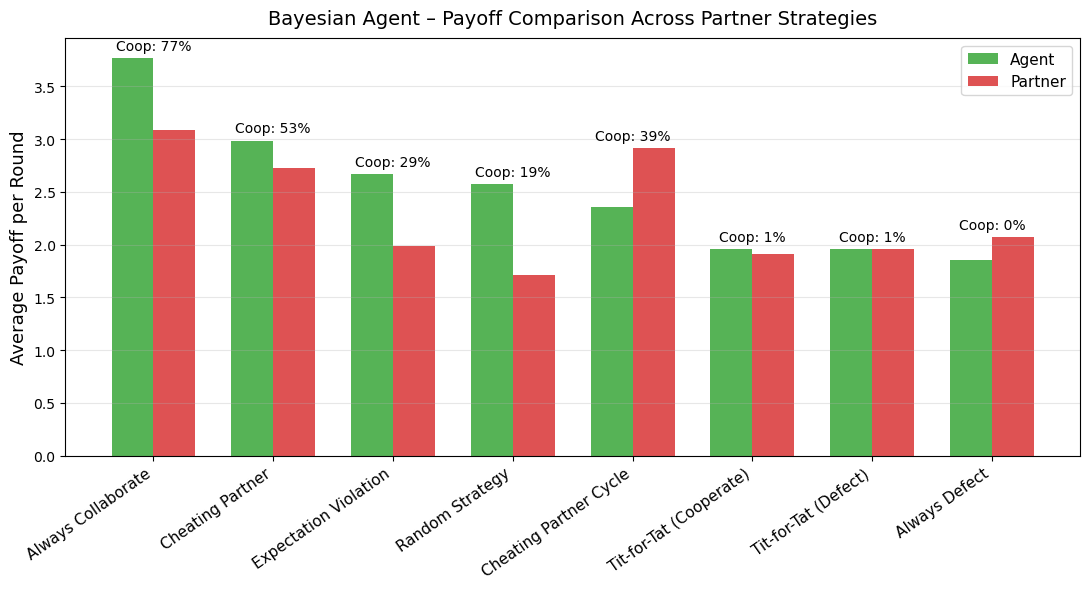


Detailed Strategy Analysis (Bayesian Agent):
               Strategy  Total Agent Payoff  Total Partner Payoff  Avg Agent Payoff  Avg Partner Payoff  Mutual Cooperation Rate
     Always Collaborate                 264                   216              3.77                3.09                     0.77
       Cheating Partner                 209                   191              2.99                2.73                     0.53
  Expectation Violation                 187                   139              2.67                1.99                     0.29
        Random Strategy                 180                   120              2.57                1.71                     0.19
 Cheating Partner Cycle                 165                   204              2.36                2.91                     0.39
Tit-for-Tat (Cooperate)                 137                   134              1.96                1.91                     0.01
   Tit-for-Tat (Defect)                 137        

In [354]:
# --- Analyze selected 8 strategies for Bayesian agent ---
strategy_results_bayes = pd.DataFrame([
    analyze_payoffs("Always Collaborate", df_bayes_collab),
    analyze_payoffs("Always Defect", df_bayes_defect),
    analyze_payoffs("Tit-for-Tat (Cooperate)", df_bayes_tft_c),
    analyze_payoffs("Tit-for-Tat (Defect)", df_bayes_tft_d),
    analyze_payoffs("Expectation Violation", df_bayes_expect),
    analyze_payoffs("Cheating Partner", df_bayes_cheating),
    analyze_payoffs("Random Strategy", df_bayes_random),
    analyze_payoffs("Cheating Partner Cycle", df_bayes_cheating_partner_cycle)
])

# --- Sort by total agent payoff ---
strategy_results_bayes = strategy_results_bayes.sort_values('Total Agent Payoff', ascending=False)

# --- Visualization ---
plt.figure(figsize=(11, 6))
x = np.arange(len(strategy_results_bayes))
width = 0.35
colors = sns.color_palette("tab10", len(strategy_results_bayes))

# Bars for average payoffs
plt.bar(x - width/2, strategy_results_bayes['Avg Agent Payoff'], width,
        label='Agent', color=colors[2], alpha=0.8)
plt.bar(x + width/2, strategy_results_bayes['Avg Partner Payoff'], width,
        label='Partner', color=colors[3], alpha=0.8)

# Axis labels and title
plt.ylabel('Average Payoff per Round', fontsize=13)
plt.title('Bayesian Agent – Payoff Comparison Across Partner Strategies', fontsize=14, pad=10)
plt.xticks(x, strategy_results_bayes['Strategy'], rotation=35, ha='right', fontsize=11)
plt.legend(fontsize=11)
plt.grid(axis='y', alpha=0.3)

# Add cooperation rates as annotations
for i, row in enumerate(strategy_results_bayes.itertuples()):
    plt.text(i, max(row._4, row._5) + 0.05,
             f'Coop: {row._6:.0%}',
             ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.show()

# --- Optional: print summary ---
print("\nDetailed Strategy Analysis (Bayesian Agent):")
print(strategy_results_bayes.round(2).to_string(index=False))


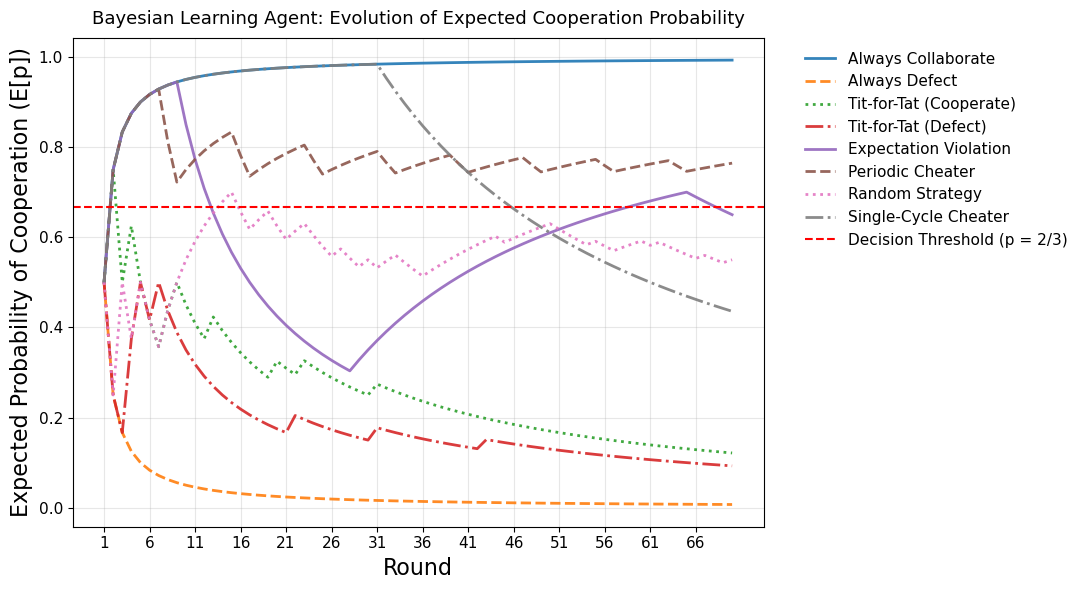

In [355]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Selected 8 partner strategies for Bayesian Agent ---
strategies_bayes = [
    ("Always Collaborate", df_bayes_collab),
    ("Always Defect", df_bayes_defect),
    ("Tit-for-Tat (Cooperate)", df_bayes_tft_c),
    ("Tit-for-Tat (Defect)", df_bayes_tft_d),
    ("Expectation Violation", df_bayes_expect),
    ("Periodic Cheater", df_bayes_cheating),
    ("Random Strategy", df_bayes_random),
    ("Single-Cycle Cheater", df_bayes_cheating_partner_cycle)
]

# --- Plot setup ---
plt.figure(figsize=(11, 6))
colors = sns.color_palette("tab10", len(strategies_bayes))
line_styles = ['-', '--', ':', '-.', '-', '--', ':', '-.']

# --- Plot expected probability (Posterior Mean) evolution for all partners ---
for idx, (name, df) in enumerate(strategies_bayes):
    plt.plot(df["Round"], df["Posterior_Mean"],
             label=name,
             color=colors[idx],
             linestyle=line_styles[idx % len(line_styles)],
             linewidth=2,
             alpha=0.9)

# --- Decision threshold ---
plt.axhline(2/3, color='red', linestyle='--', linewidth=1.5,
            label='Decision Threshold (p = 2/3)')

# --- Formatting ---
plt.xlabel("Round", fontsize=16)
plt.ylabel("Expected Probability of Cooperation (E[p])", fontsize=16)
plt.title("Bayesian Learning Agent: Evolution of Expected Cooperation Probability", fontsize=13, pad=10)
plt.legend(bbox_to_anchor=(1.04, 1), loc='upper left', fontsize=11, frameon=False)
plt.grid(alpha=0.3)
plt.xticks(ticks=np.arange(1, num_rounds + 1, step=5), fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()


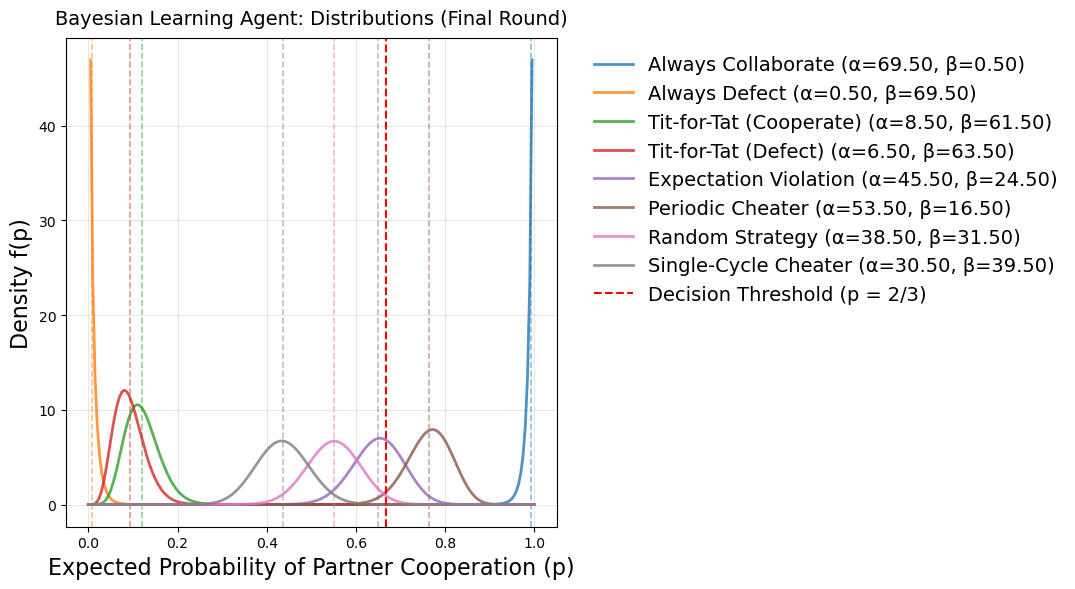

In [356]:
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import seaborn as sns

# --- Selected 8 partner strategies for Bayesian Agent ---
strategies_bayes = [
    ("Always Collaborate", df_bayes_collab),
    ("Always Defect", df_bayes_defect),
    ("Tit-for-Tat (Cooperate)", df_bayes_tft_c),
    ("Tit-for-Tat (Defect)", df_bayes_tft_d),
    ("Expectation Violation", df_bayes_expect),
    ("Periodic Cheater", df_bayes_cheating),
    ("Random Strategy", df_bayes_random),
    ("Single-Cycle Cheater", df_bayes_cheating_partner_cycle)
]

# --- Extract last-round (final state) alpha and beta for each partner ---
last_round_data_bayes = {}
for name, df in strategies_bayes:
    last_row = df.iloc[-1]
    alpha = last_row["Alpha"]
    beta = last_row["Beta"]
    last_round_data_bayes[name] = (alpha, beta)

# --- Plot Beta distributions based on (alpha, beta) for each partner ---
p = np.linspace(0, 1, 200)
plt.figure(figsize=(11, 6))
colors = sns.color_palette("tab10", len(strategies_bayes))

for idx, (name, (alpha, beta)) in enumerate(last_round_data_bayes.items()):
    # Calculate posterior mean
    E_p = alpha / (alpha + beta)
    
    # Plot the Beta PDF
    plt.plot(p, stats.beta.pdf(p, alpha, beta),
             label=f"{name} (α={alpha:.2f}, β={beta:.2f})",
             linewidth=2, alpha=0.8, color=colors[idx])
    
    # Mark posterior mean
    plt.axvline(x=E_p, linestyle='--', linewidth=1.2, alpha=0.5, color=colors[idx])

# --- Decision threshold ---
plt.axvline(x=2/3, color='red', linestyle='--', linewidth=1.5, label='Decision Threshold (p = 2/3)')

# --- Labels & formatting ---
plt.xlabel("Expected Probability of Partner Cooperation (p)", fontsize=16)
plt.ylabel("Density f(p)", fontsize=16)
plt.title("Bayesian Learning Agent: Distributions (Final Round)", fontsize=14, pad=10)
plt.legend(bbox_to_anchor=(1.04, 1), loc='upper left', fontsize=14, frameon=False)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [357]:
# Compare with decision-making trends (Bayesian Agent)
print("Decision-Making Trends in the Last Round (Bayesian Agent):")

strategies_bayes = [
    ("Always Collaborate", df_bayes_collab),
    ("Always Defect", df_bayes_defect),
    ("Adaptive Strategy", df_bayes_adaptive),
    ("Tit-for-Tat Cooperate", df_bayes_tft_c),
    ("Tit-for-Tat Defect", df_bayes_tft_d),
    ("Expectation Violation", df_bayes_expect),
    ("Cheating Partner", df_bayes_cheating),
    ("Random Strategy", df_bayes_random),
]

for i, (name, df) in enumerate(strategies_bayes, 1):
    last_choice = df.iloc[-1]["Agent_Choice"]
    last_p = df.iloc[-1]["Posterior_Mean"]
    
    print(f"{i}. {name}: p = {last_p:.3f}, Choice = {'Stag' if last_choice == 1 else 'Hare'}")


Decision-Making Trends in the Last Round (Bayesian Agent):
1. Always Collaborate: p = 0.993, Choice = Stag
2. Always Defect: p = 0.007, Choice = Stag
3. Adaptive Strategy: p = 0.007, Choice = Hare
4. Tit-for-Tat Cooperate: p = 0.121, Choice = Hare
5. Tit-for-Tat Defect: p = 0.093, Choice = Hare
6. Expectation Violation: p = 0.650, Choice = Stag
7. Cheating Partner: p = 0.764, Choice = Stag
8. Random Strategy: p = 0.550, Choice = Hare


# 🎬 ANIMATION: Single Cycle Cheater Comparison

This animation compares how Trust-Based vs Bayesian agents respond when a partner:
- **Cooperates** for rounds 1-30
- **BETRAYS** starting at round 31 (defects for remaining 40 rounds)

We'll see which model adapts better to this dramatic partner behavior change.

In [358]:
# Generate Trust-Based agent data for Single Cycle Cheater
print("🎯 Running Trust-Based agent vs Single Cycle Cheater...")
df_trust_single_cycle = run_single_agent_simulation(
    u_i=None, 
    num_rounds=70, 
    partner_obj=SingleCyclePartner(cooperate_rounds=30),
    memory_discount=MEMORY_DISCOUNT,
    trust_discount=TRUST_DISCOUNT,
    trust_smoothing=TRUST_SMOOTHING,
    seed=42
)
print(f"✓ Complete! Generated {len(df_trust_single_cycle)} rounds of data")
print(f"  - Cooperation rate: {df_trust_single_cycle['Agent_Choice'].mean():.1%}")
print(f"  - Final probability: {df_trust_single_cycle.iloc[-1]['E_p']:.3f}")

🎯 Running Trust-Based agent vs Single Cycle Cheater...
✓ Complete! Generated 70 rounds of data
  - Cooperation rate: 42.9%
  - Final probability: 0.140


In [359]:
# Bayesian data already exists from the other notebook
# Variable name: df_bayes_cheating_partner_cycle
# If you need to load it here, you have options:
# Option 1: Copy it from the Bayesian notebook
# Option 2: Run the Bayesian simulation here (see next cell)
# Option 3: Save/load via CSV

print("📌 Using existing Bayesian data: df_bayes_cheating_partner_cycle")
print(f"   Available from Trust_updated_focal_Beysian_stoch.ipynb")

📌 Using existing Bayesian data: df_bayes_cheating_partner_cycle
   Available from Trust_updated_focal_Beysian_stoch.ipynb


In [360]:
# Create the animation function
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib.gridspec as gridspec

def create_single_cycle_animation(df_trust, df_bayes, betrayal_round=30, save_path=None):
    """
    Create side-by-side animated comparison of Trust-Based vs Bayesian agents.
    """
    
    fig = plt.figure(figsize=(16, 10))
    gs = gridspec.GridSpec(3, 2, figure=fig, hspace=0.3, wspace=0.25)
    
    # Create subplots
    ax_prob_trust = fig.add_subplot(gs[0, 0])
    ax_prob_bayes = fig.add_subplot(gs[0, 1])
    ax_conf_trust = fig.add_subplot(gs[1, 0])
    ax_conf_bayes = fig.add_subplot(gs[1, 1])
    ax_partner = fig.add_subplot(gs[2, :])
    
    # Colors
    colors = {'trust': '#2E86AB', 'bayesian': '#A23B72', 'partner': '#F18F01', 'threshold': '#C73E1D'}
    
    # Initialize line objects
    line_prob_trust, = ax_prob_trust.plot([], [], color=colors['trust'], linewidth=2.5, label='Expected p')
    line_prob_bayes, = ax_prob_bayes.plot([], [], color=colors['bayesian'], linewidth=2.5, label='Posterior Mean')
    line_conf_trust, = ax_conf_trust.plot([], [], color=colors['trust'], linewidth=2.5, label='Trust Level')
    line_conf_bayes, = ax_conf_bayes.plot([], [], color=colors['bayesian'], linewidth=2.5, label='Concentration')
    line_partner, = ax_partner.plot([], [], color=colors['partner'], linewidth=3, marker='o', markersize=4)
    
    # Setup probability plots
    for ax, title in [(ax_prob_trust, 'Trust-Based Agent: Expected Probability'),
                      (ax_prob_bayes, 'Bayesian Agent: Posterior Mean')]:
        ax.set_xlim(0, 70)
        ax.set_ylim(0, 1)
        ax.axhline(2/3, color=colors['threshold'], linestyle='--', alpha=0.6, linewidth=2, label='Threshold')
        ax.axvline(betrayal_round, color='red', linestyle=':', alpha=0.4, linewidth=2)
        ax.axvspan(0, betrayal_round, alpha=0.05, color='green')
        ax.axvspan(betrayal_round, 70, alpha=0.05, color='red')
        ax.set_xlabel('Round', fontsize=12, fontweight='bold')
        ax.set_ylabel('P(Cooperate)', fontsize=12, fontweight='bold')
        ax.set_title(title, fontsize=13, fontweight='bold', pad=10)
        ax.legend(fontsize=9, loc='best')
        ax.grid(alpha=0.3, linestyle='--')
    
    # Setup confidence plots  
    ax_conf_trust.set_xlim(0, 70)
    ax_conf_trust.set_ylim(0, df_trust['Agent_Trust'].max() * 1.15)
    ax_conf_trust.axvline(betrayal_round, color='red', linestyle=':', alpha=0.4, linewidth=2)
    ax_conf_trust.set_xlabel('Round', fontsize=12, fontweight='bold')
    ax_conf_trust.set_ylabel('Trust Level', fontsize=12, fontweight='bold')
    ax_conf_trust.set_title('Trust-Based: Confidence', fontsize=13, fontweight='bold', pad=10)
    ax_conf_trust.legend(fontsize=9)
    ax_conf_trust.grid(alpha=0.3, linestyle='--')
    
    ax_conf_bayes.set_xlim(0, 70)
    ax_conf_bayes.set_ylim(0, df_bayes['Concentration'].max() * 1.15)
    ax_conf_bayes.axvline(betrayal_round, color='red', linestyle=':', alpha=0.4, linewidth=2)
    ax_conf_bayes.set_xlabel('Round', fontsize=12, fontweight='bold')
    ax_conf_bayes.set_ylabel('Concentration', fontsize=12, fontweight='bold')
    ax_conf_bayes.set_title('Bayesian: Confidence', fontsize=13, fontweight='bold', pad=10)
    ax_conf_bayes.legend(fontsize=9)
    ax_conf_bayes.grid(alpha=0.3, linestyle='--')
    
    # Setup partner plot
    ax_partner.set_xlim(0, 70)
    ax_partner.set_ylim(-0.1, 1.1)
    ax_partner.axvline(betrayal_round, color='red', linestyle='--', linewidth=2.5, alpha=0.8, label=f'BETRAYAL')
    ax_partner.axvspan(0, betrayal_round, alpha=0.1, color='green')
    ax_partner.axvspan(betrayal_round, 70, alpha=0.1, color='red')
    ax_partner.set_xlabel('Round', fontsize=13, fontweight='bold')
    ax_partner.set_ylabel('Partner Action', fontsize=13, fontweight='bold')
    ax_partner.set_yticks([0, 1])
    ax_partner.set_yticklabels(['DEFECT', 'COOPERATE'], fontsize=11)
    ax_partner.set_title(f'Partner: Single Cycle Cheater', fontsize=14, fontweight='bold', pad=10)
    ax_partner.legend(fontsize=10)
    ax_partner.grid(alpha=0.3)
    
    fig.suptitle('🎬 Trust-Based vs Bayesian: Response to Betrayal', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    def init():
        line_prob_trust.set_data([], [])
        line_prob_bayes.set_data([], [])
        line_conf_trust.set_data([], [])
        line_conf_bayes.set_data([], [])
        line_partner.set_data([], [])
        return line_prob_trust, line_prob_bayes, line_conf_trust, line_conf_bayes, line_partner
    
    def animate(frame):
        rounds = df_trust['Round'].values[:frame+1]
        line_prob_trust.set_data(rounds, df_trust['E_p'].values[:frame+1])
        line_prob_bayes.set_data(rounds, df_bayes['Posterior_Mean'].values[:frame+1])
        line_conf_trust.set_data(rounds, df_trust['Agent_Trust'].values[:frame+1])
        line_conf_bayes.set_data(rounds, df_bayes['Concentration'].values[:frame+1])
        line_partner.set_data(rounds, df_trust['Partner_Choice'].values[:frame+1])
        return line_prob_trust, line_prob_bayes, line_conf_trust, line_conf_bayes, line_partner
    
    anim = FuncAnimation(fig, animate, init_func=init, frames=70, 
                        interval=200, blit=True, repeat=True)
    
    if save_path:
        anim.save(save_path, writer='pillow', fps=5)
        print(f"✓ Animation saved: {save_path}")
    
    plt.tight_layout()
    return anim

print("✓ Animation function ready!")

✓ Animation function ready!


In [361]:
# <!-- filepath: c:\Users\mzarreh\ASU Dropbox\Mobin Zarreh\AS a Desktop\Publications\Systems Engineering Paper\Trust_updated_focal_stoch_Betray.ipynb -->

# Add this cell before the problematic cell:
class BayesianFocalAgent:
    def __init__(self, alpha0=EPS, beta0=EPS, stochastic=True, inv_temp=2.0):
        # prior mapped from your (x0, T0) for comparability
        if alpha0 <= 0 or beta0 <= 0:
            raise ValueError("alpha0 and beta0 must be > 0")
        self.alpha = float(alpha0)
        self.beta = float(beta0)
        self.stochastic = stochastic
        self.inv_temp = float(inv_temp)

    def posterior_mean(self) -> float:
        return self.alpha / (self.alpha + self.beta)

    def make_decision(self) -> int:
        p = self.posterior_mean()
        
        a00 = get_payoff(0,0,0); a01 = get_payoff(0,1,0)
        a10 = get_payoff(1,0,0); a11 = get_payoff(1,1,0)
        EV_hare = (1 - p) * a00 + p * a01
        EV_stag = (1 - p) * a10 + p * a11
        D = EV_stag - EV_hare

        if not self.stochastic:
            return 1 if D > 0 else 0
        prob_stag = 1.0 / (1.0 + np.exp(-self.inv_temp * D))
        return 1 if random.random() < prob_stag else 0

    def update(self, partner_choice: int):
        if partner_choice not in (0,1):
            raise ValueError("partner_choice must be 0 or 1")
        self.alpha += partner_choice
        self.beta += (1 - partner_choice)

def run_bayesian_vs_partner(
    num_rounds: int = 70,
    partner_obj = None,
    initial_last_choice: int = 1,
    beta0: float = EPS,
    alpha0: float = EPS,
    stochastic: bool = True,
    inv_temp: float = 2.0,
    seed: int = None
) -> pd.DataFrame:
    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)
        
    if partner_obj is None:
        raise ValueError("Provide a partner_obj instance")

    agent = BayesianFocalAgent(alpha0=alpha0, beta0=beta0, stochastic=stochastic, inv_temp=inv_temp)
    results = []
    last_agent_choice = initial_last_choice

    for round_num in range(num_rounds):
        agent_choice = agent.make_decision()
        partner_choice = partner_obj.decide(round_num, last_agent_choice)
        agent.update(partner_choice)
        partner_obj.observe(agent_choice)
        last_agent_choice = agent_choice

        results.append((
            round_num + 1, 
            agent_choice, 
            partner_choice, 
            agent.posterior_mean(), 
            agent.alpha, 
            agent.beta, 
            agent.alpha + agent.beta - 2.0*EPS
        ))

    return pd.DataFrame(results, columns=[
        "Round","Agent_Choice","Partner_Choice",
        "Posterior_Mean","Alpha","Beta","Concentration"
    ])

In [362]:
# Run Bayesian agent against Single Cycle Cheater partner
df_bayes_cheating_partner_cycle = run_bayesian_vs_partner(
    num_rounds=70, 
    partner_obj=SingleCyclePartner(cooperate_rounds=30),
    seed=42
)

print("✓ Bayesian simulation complete!")
print(f"  Rounds: {len(df_bayes_cheating_partner_cycle)}")
print(f"  Final Posterior Mean: {df_bayes_cheating_partner_cycle.iloc[-1]['Posterior_Mean']:.4f}")
print(f"  Final Concentration: {df_bayes_cheating_partner_cycle.iloc[-1]['Concentration']:.2f}")

✓ Bayesian simulation complete!
  Rounds: 70
  Final Posterior Mean: 0.4296
  Final Concentration: 70.00


C:\Users\mzarreh\AppData\Local\Temp\ipykernel_39352\250328028.py:99: UserWarning: Glyph 127916 (\N{CLAPPER BOARD}) missing from current font.
  anim = FuncAnimation(fig, animate, init_func=init, frames=70,
C:\Users\mzarreh\AppData\Local\Temp\ipykernel_39352\250328028.py:103: UserWarning: Glyph 127916 (\N{CLAPPER BOARD}) missing from current font.
  anim.save(save_path, writer='pillow', fps=5)


✓ Animation saved: single_cycle_comparison.gif

✅ Animation saved as 'single_cycle_comparison.gif'


C:\Users\mzarreh\AppData\Local\Temp\ipykernel_39352\250328028.py:106: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\mzarreh\AppData\Roaming\Python\Python312\site-packages\IPython\core\events.py:82: UserWarning: Glyph 127916 (\N{CLAPPER BOARD}) missing from current font.
  func(*args, **kwargs)
C:\Users\mzarreh\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127916 (\N{CLAPPER BOARD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\mzarreh\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127916 (\N{CLAPPER BOARD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


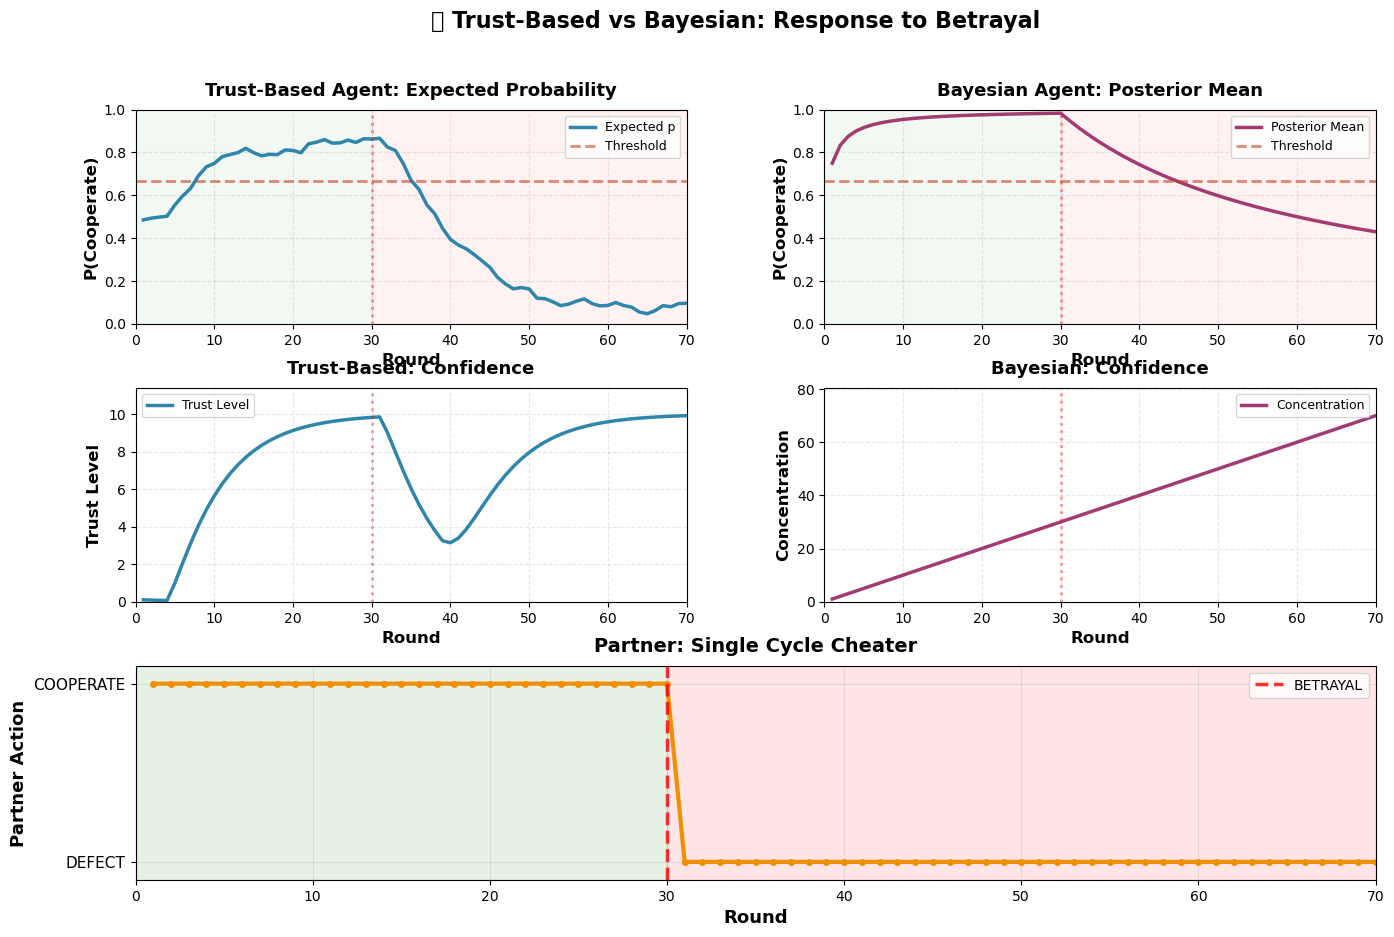

In [363]:
# Create and save the comparison animation
anim = create_single_cycle_animation(
    df_trust=df_cheating_partner_cycle,
    df_bayes=df_bayes_cheating_partner_cycle,
    betrayal_round=30,
    save_path='single_cycle_comparison.gif'
)

print("\n✅ Animation saved as 'single_cycle_comparison.gif'")

ANIMATION 2: PERIODIC CHEATER
✓ Bayesian simulation complete!
  Final Posterior Mean: 0.7676


C:\Users\mzarreh\AppData\Local\Temp\ipykernel_39352\678691411.py:84: UserWarning: Glyph 127916 (\N{CLAPPER BOARD}) missing from current font.
  anim = FuncAnimation(fig, animate, init_func=init, frames=70, interval=200, blit=True)
C:\Users\mzarreh\AppData\Local\Temp\ipykernel_39352\678691411.py:85: UserWarning: Glyph 127916 (\N{CLAPPER BOARD}) missing from current font.
  anim.save('periodic_cheater_comparison.gif', writer='pillow', fps=5)
C:\Users\mzarreh\AppData\Local\Temp\ipykernel_39352\678691411.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\mzarreh\AppData\Local\Temp\ipykernel_39352\678691411.py:179: UserWarning: Glyph 127916 (\N{CLAPPER BOARD}) missing from current font.
  anim = FuncAnimation(fig, animate, init_func=init, frames=70, interval=200, blit=True)
C:\Users\mzarreh\AppData\Local\Temp\ipykernel_39352\678691411.py:86: UserWarning: This figure includes Axes that are not 

✓ Animation saved: periodic_cheater_comparison.gif

ANIMATION 3: EXPECTATION VIOLATION
✓ Bayesian simulation complete!
  Final Posterior Mean: 0.7113


C:\Users\mzarreh\AppData\Local\Temp\ipykernel_39352\678691411.py:180: UserWarning: Glyph 127916 (\N{CLAPPER BOARD}) missing from current font.
  anim.save('expectation_violation_comparison.gif', writer='pillow', fps=5)
C:\Users\mzarreh\AppData\Local\Temp\ipykernel_39352\678691411.py:181: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\mzarreh\AppData\Roaming\Python\Python312\site-packages\IPython\core\events.py:82: UserWarning: Glyph 127916 (\N{CLAPPER BOARD}) missing from current font.
  func(*args, **kwargs)
C:\Users\mzarreh\AppData\Local\Temp\ipykernel_39352\678691411.py:181: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\mzarreh\AppData\Roaming\Python\Python312\site-packages\IPython\core\events.py:82: UserWarning: Glyph 127916 (\N{CLAPPER BOARD}) missing from current font.
  func(*args, **kwarg

✓ Animation saved: expectation_violation_comparison.gif

✅ ALL THREE ANIMATIONS COMPLETED!

📁 Generated files:
  1. single_cycle_comparison.gif
  2. periodic_cheater_comparison.gif
  3. expectation_violation_comparison.gif

🎉 Ready for your Cargill presentation!


C:\Users\mzarreh\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127916 (\N{CLAPPER BOARD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


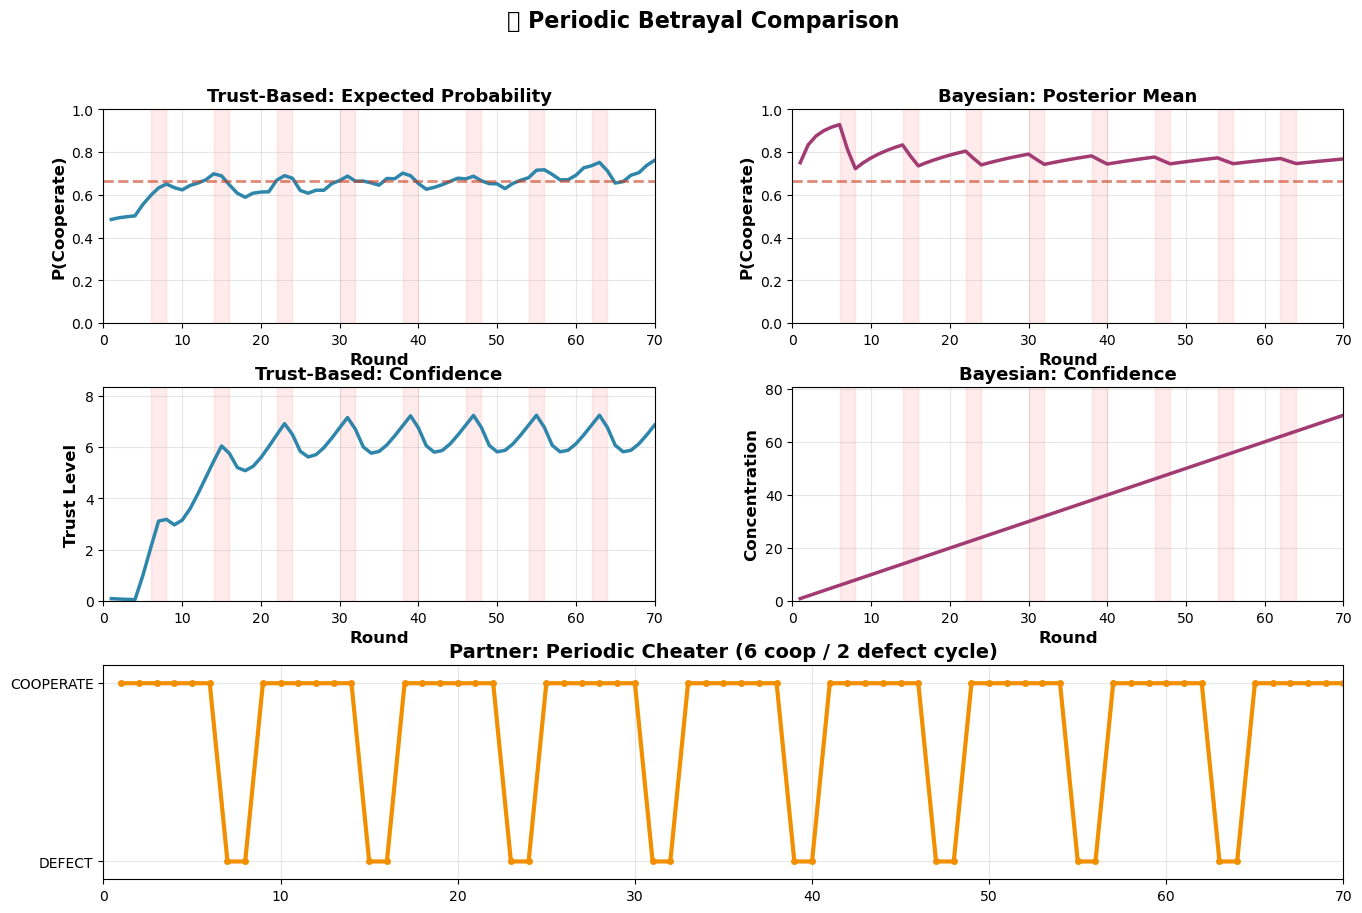

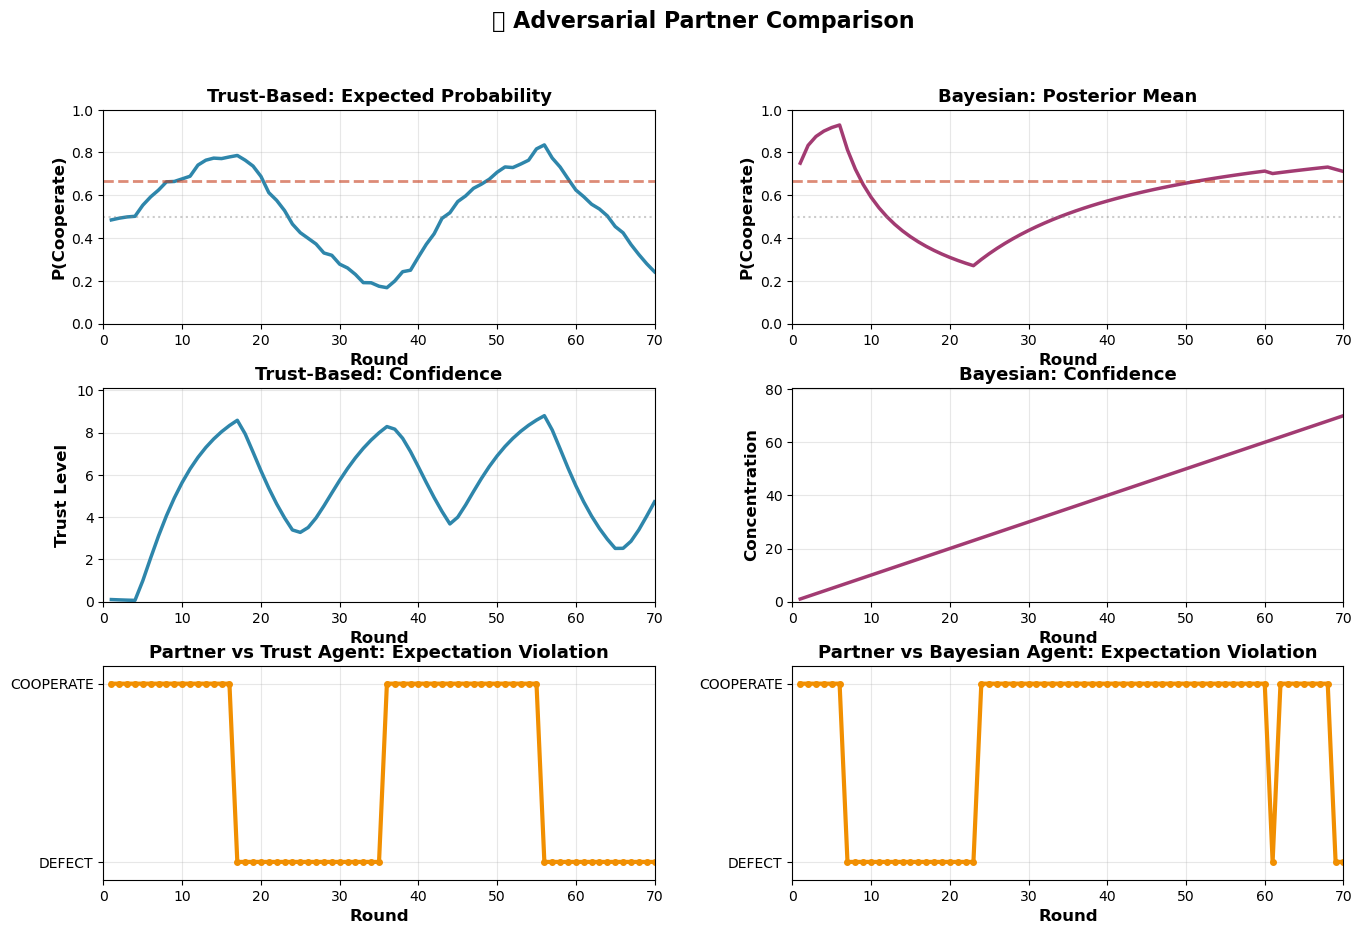

In [364]:
# ============================================================================
# CREATE PERIODIC CHEATER AND EXPECTATION VIOLATION ANIMATIONS
# ============================================================================

print("="*70)
print("ANIMATION 2: PERIODIC CHEATER")
print("="*70)

# 1. Run Bayesian simulation for Periodic Cheater
df_bayes_periodic = run_bayesian_vs_partner(
    num_rounds=70, 
    partner_obj=PeriodicCheaterPartner(cycle_length=6, cheat_duration=2),
    seed=42
)
print(f"✓ Bayesian simulation complete!")
print(f"  Final Posterior Mean: {df_bayes_periodic.iloc[-1]['Posterior_Mean']:.4f}")

# 2. Create animation
def create_periodic_animation(df_trust, df_bayes):
    fig = plt.figure(figsize=(16, 10))
    gs = gridspec.GridSpec(3, 2, figure=fig, hspace=0.3, wspace=0.25)
    
    ax_prob_trust = fig.add_subplot(gs[0, 0])
    ax_prob_bayes = fig.add_subplot(gs[0, 1])
    ax_conf_trust = fig.add_subplot(gs[1, 0])
    ax_conf_bayes = fig.add_subplot(gs[1, 1])
    ax_partner = fig.add_subplot(gs[2, :])
    
    colors = {'trust': '#2E86AB', 'bayesian': '#A23B72', 'partner': '#F18F01', 'threshold': '#C73E1D'}
    
    line_prob_trust, = ax_prob_trust.plot([], [], color=colors['trust'], linewidth=2.5)
    line_prob_bayes, = ax_prob_bayes.plot([], [], color=colors['bayesian'], linewidth=2.5)
    line_conf_trust, = ax_conf_trust.plot([], [], color=colors['trust'], linewidth=2.5)
    line_conf_bayes, = ax_conf_bayes.plot([], [], color=colors['bayesian'], linewidth=2.5)
    line_partner, = ax_partner.plot([], [], color=colors['partner'], linewidth=3, marker='o', markersize=4)
    
    for ax in [ax_prob_trust, ax_prob_bayes]:
        ax.set_xlim(0, 70); ax.set_ylim(0, 1)
        ax.axhline(2/3, color=colors['threshold'], linestyle='--', alpha=0.6, linewidth=2)
        for cycle_start in range(6, 70, 8):
            ax.axvspan(cycle_start, min(cycle_start+2, 70), alpha=0.08, color='red')
        ax.set_xlabel('Round', fontsize=12, fontweight='bold')
        ax.set_ylabel('P(Cooperate)', fontsize=12, fontweight='bold')
        ax.grid(alpha=0.3)
    
    ax_prob_trust.set_title('Trust-Based: Expected Probability', fontsize=13, fontweight='bold')
    ax_prob_bayes.set_title('Bayesian: Posterior Mean', fontsize=13, fontweight='bold')
    
    ax_conf_trust.set_xlim(0, 70); ax_conf_trust.set_ylim(0, df_trust['Agent_Trust'].max() * 1.15)
    ax_conf_bayes.set_xlim(0, 70); ax_conf_bayes.set_ylim(0, df_bayes['Concentration'].max() * 1.15)
    
    for ax in [ax_conf_trust, ax_conf_bayes]:
        for cycle_start in range(6, 70, 8):
            ax.axvspan(cycle_start, min(cycle_start+2, 70), alpha=0.08, color='red')
        ax.set_xlabel('Round', fontsize=12, fontweight='bold')
        ax.grid(alpha=0.3)
    
    ax_conf_trust.set_ylabel('Trust Level', fontsize=12, fontweight='bold')
    ax_conf_trust.set_title('Trust-Based: Confidence', fontsize=13, fontweight='bold')
    ax_conf_bayes.set_ylabel('Concentration', fontsize=12, fontweight='bold')
    ax_conf_bayes.set_title('Bayesian: Confidence', fontsize=13, fontweight='bold')
    
    ax_partner.set_xlim(0, 70); ax_partner.set_ylim(-0.1, 1.1)
    ax_partner.set_yticks([0, 1]); ax_partner.set_yticklabels(['DEFECT', 'COOPERATE'])
    ax_partner.set_title('Partner: Periodic Cheater (6 coop / 2 defect cycle)', fontsize=14, fontweight='bold')
    ax_partner.grid(alpha=0.3)
    
    fig.suptitle('🎬 Periodic Betrayal Comparison', fontsize=16, fontweight='bold', y=0.98)
    
    def init():
        for line in [line_prob_trust, line_prob_bayes, line_conf_trust, line_conf_bayes, line_partner]:
            line.set_data([], [])
        return line_prob_trust, line_prob_bayes, line_conf_trust, line_conf_bayes, line_partner
    
    def animate(frame):
        rounds = df_trust['Round'].values[:frame+1]
        line_prob_trust.set_data(rounds, df_trust['E_p'].values[:frame+1])
        line_prob_bayes.set_data(rounds, df_bayes['Posterior_Mean'].values[:frame+1])
        line_conf_trust.set_data(rounds, df_trust['Agent_Trust'].values[:frame+1])
        line_conf_bayes.set_data(rounds, df_bayes['Concentration'].values[:frame+1])
        line_partner.set_data(rounds, df_trust['Partner_Choice'].values[:frame+1])
        return line_prob_trust, line_prob_bayes, line_conf_trust, line_conf_bayes, line_partner
    
    anim = FuncAnimation(fig, animate, init_func=init, frames=70, interval=200, blit=True)
    anim.save('periodic_cheater_comparison.gif', writer='pillow', fps=5)
    plt.tight_layout()
    print("✓ Animation saved: periodic_cheater_comparison.gif")
    return anim

anim_periodic = create_periodic_animation(df_cheating, df_bayes_periodic)

print("\n" + "="*70)
print("ANIMATION 3: EXPECTATION VIOLATION")
print("="*70)

# 3. Run Bayesian simulation for Expectation Violation
df_bayes_expect = run_bayesian_vs_partner(
    num_rounds=70, 
    partner_obj=ExpectationViolationPartner(),
    seed=42
)
print(f"✓ Bayesian simulation complete!")
print(f"  Final Posterior Mean: {df_bayes_expect.iloc[-1]['Posterior_Mean']:.4f}")

# 4. Create animation
def create_expect_animation(df_trust, df_bayes):
    fig = plt.figure(figsize=(16, 10))
    gs = gridspec.GridSpec(3, 2, figure=fig, hspace=0.3, wspace=0.25)
    
    ax_prob_trust = fig.add_subplot(gs[0, 0])
    ax_prob_bayes = fig.add_subplot(gs[0, 1])
    ax_conf_trust = fig.add_subplot(gs[1, 0])
    ax_conf_bayes = fig.add_subplot(gs[1, 1])
    ax_partner_trust = fig.add_subplot(gs[2, 0])
    ax_partner_bayes = fig.add_subplot(gs[2, 1])
    
    colors = {'trust': '#2E86AB', 'bayesian': '#A23B72', 'partner': '#F18F01', 'threshold': '#C73E1D'}
    
    line_prob_trust, = ax_prob_trust.plot([], [], color=colors['trust'], linewidth=2.5)
    line_prob_bayes, = ax_prob_bayes.plot([], [], color=colors['bayesian'], linewidth=2.5)
    line_conf_trust, = ax_conf_trust.plot([], [], color=colors['trust'], linewidth=2.5)
    line_conf_bayes, = ax_conf_bayes.plot([], [], color=colors['bayesian'], linewidth=2.5)
    line_partner_trust, = ax_partner_trust.plot([], [], color=colors['partner'], linewidth=3, marker='o', markersize=4)
    line_partner_bayes, = ax_partner_bayes.plot([], [], color=colors['partner'], linewidth=3, marker='o', markersize=4)
    
    for ax in [ax_prob_trust, ax_prob_bayes]:
        ax.set_xlim(0, 70); ax.set_ylim(0, 1)
        ax.axhline(2/3, color=colors['threshold'], linestyle='--', alpha=0.6, linewidth=2)
        ax.axhline(0.5, color='gray', linestyle=':', alpha=0.4, linewidth=1.5)
        ax.set_xlabel('Round', fontsize=12, fontweight='bold')
        ax.set_ylabel('P(Cooperate)', fontsize=12, fontweight='bold')
        ax.grid(alpha=0.3)
    
    ax_prob_trust.set_title('Trust-Based: Expected Probability', fontsize=13, fontweight='bold')
    ax_prob_bayes.set_title('Bayesian: Posterior Mean', fontsize=13, fontweight='bold')
    
    ax_conf_trust.set_xlim(0, 70); ax_conf_trust.set_ylim(0, df_trust['Agent_Trust'].max() * 1.15)
    ax_conf_bayes.set_xlim(0, 70); ax_conf_bayes.set_ylim(0, df_bayes['Concentration'].max() * 1.15)
    
    ax_conf_trust.set_xlabel('Round', fontsize=12, fontweight='bold')
    ax_conf_trust.set_ylabel('Trust Level', fontsize=12, fontweight='bold')
    ax_conf_trust.set_title('Trust-Based: Confidence', fontsize=13, fontweight='bold')
    ax_conf_trust.grid(alpha=0.3)
    
    ax_conf_bayes.set_xlabel('Round', fontsize=12, fontweight='bold')
    ax_conf_bayes.set_ylabel('Concentration', fontsize=12, fontweight='bold')
    ax_conf_bayes.set_title('Bayesian: Confidence', fontsize=13, fontweight='bold')
    ax_conf_bayes.grid(alpha=0.3)
    
    ax_partner_trust.set_xlim(0, 70); ax_partner_trust.set_ylim(-0.1, 1.1)
    ax_partner_trust.set_yticks([0, 1]); ax_partner_trust.set_yticklabels(['DEFECT', 'COOPERATE'])
    ax_partner_trust.set_xlabel('Round', fontsize=12, fontweight='bold')
    ax_partner_trust.set_title('Partner vs Trust Agent: Expectation Violation', fontsize=13, fontweight='bold')
    ax_partner_trust.grid(alpha=0.3)
    
    ax_partner_bayes.set_xlim(0, 70); ax_partner_bayes.set_ylim(-0.1, 1.1)
    ax_partner_bayes.set_yticks([0, 1]); ax_partner_bayes.set_yticklabels(['DEFECT', 'COOPERATE'])
    ax_partner_bayes.set_xlabel('Round', fontsize=12, fontweight='bold')
    ax_partner_bayes.set_title('Partner vs Bayesian Agent: Expectation Violation', fontsize=13, fontweight='bold')
    ax_partner_bayes.grid(alpha=0.3)
    
    fig.suptitle('🎬 Adversarial Partner Comparison', fontsize=16, fontweight='bold', y=0.98)
    
    def init():
        for line in [line_prob_trust, line_prob_bayes, line_conf_trust, line_conf_bayes, line_partner_trust, line_partner_bayes]:
            line.set_data([], [])
        return line_prob_trust, line_prob_bayes, line_conf_trust, line_conf_bayes, line_partner_trust, line_partner_bayes
    
    def animate(frame):
        rounds = df_trust['Round'].values[:frame+1]
        line_prob_trust.set_data(rounds, df_trust['E_p'].values[:frame+1])
        line_prob_bayes.set_data(rounds, df_bayes['Posterior_Mean'].values[:frame+1])
        line_conf_trust.set_data(rounds, df_trust['Agent_Trust'].values[:frame+1])
        line_conf_bayes.set_data(rounds, df_bayes['Concentration'].values[:frame+1])
        line_partner_trust.set_data(rounds, df_trust['Partner_Choice'].values[:frame+1])
        line_partner_bayes.set_data(rounds, df_bayes['Partner_Choice'].values[:frame+1])
        return line_prob_trust, line_prob_bayes, line_conf_trust, line_conf_bayes, line_partner_trust, line_partner_bayes
    
    anim = FuncAnimation(fig, animate, init_func=init, frames=70, interval=200, blit=True)
    anim.save('expectation_violation_comparison.gif', writer='pillow', fps=5)
    plt.tight_layout()
    print("✓ Animation saved: expectation_violation_comparison.gif")
    return anim

anim_expect = create_expect_animation(df_expect_violation, df_bayes_expect)

print("\n" + "="*70)
print("✅ ALL THREE ANIMATIONS COMPLETED!")
print("="*70)
print("\n📁 Generated files:")
print("  1. single_cycle_comparison.gif")
print("  2. periodic_cheater_comparison.gif")
print("  3. expectation_violation_comparison.gif")
print("\n🎉 Ready for your Cargill presentation!")

C:\Users\mzarreh\AppData\Local\Temp\ipykernel_39352\1591547931.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\mzarreh\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


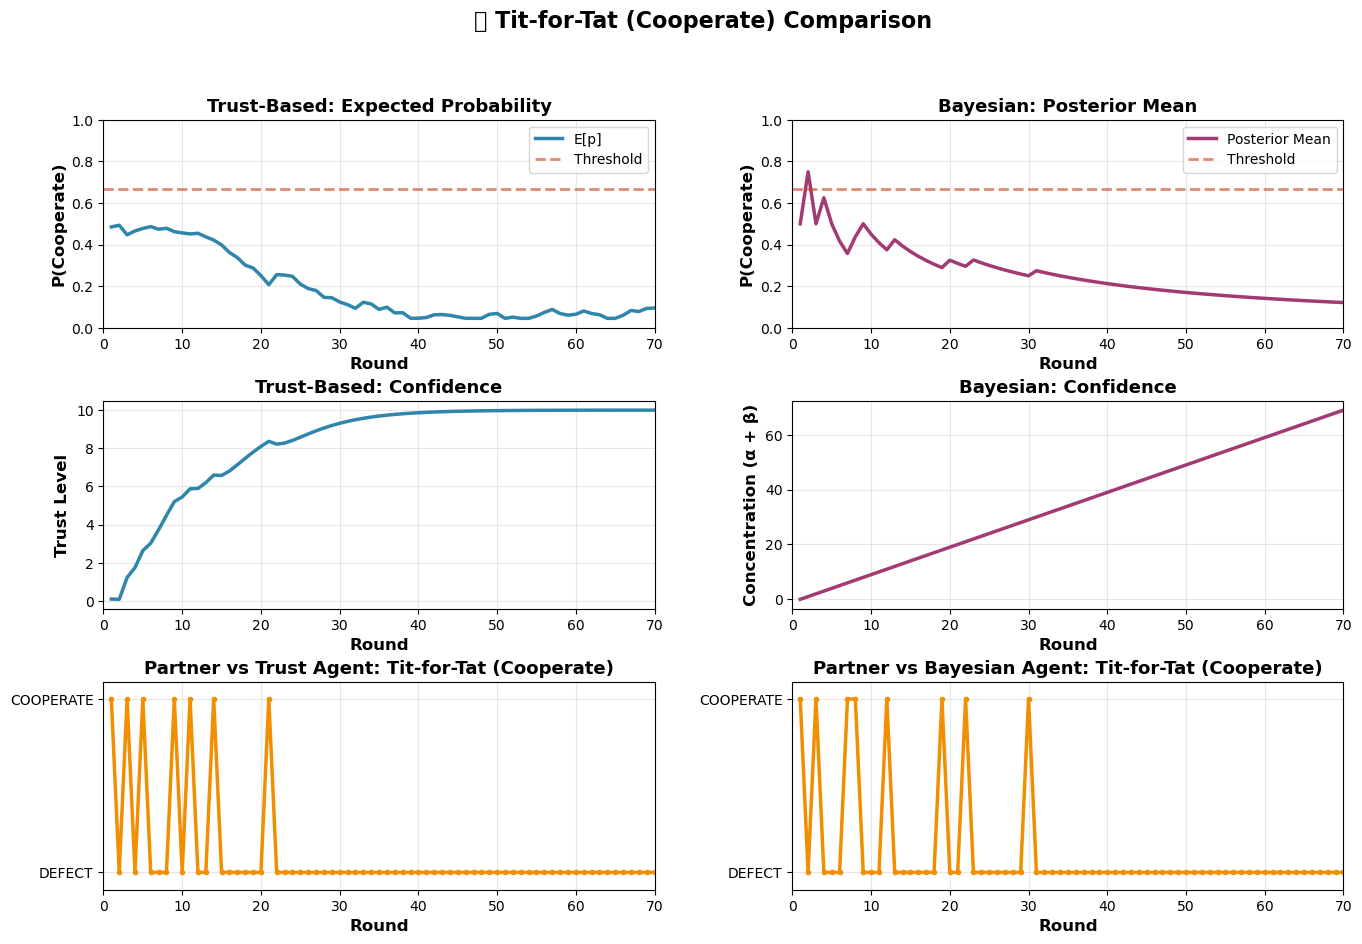

✅ Tit-for-Tat (Cooperate) comparison plot completed!


In [365]:
# ============================================================================
# STATIC COMPARISON PLOT: TIT-FOR-TAT (COOPERATE)
# ============================================================================

fig = plt.figure(figsize=(16, 10))
gs = gridspec.GridSpec(3, 2, figure=fig, hspace=0.35, wspace=0.25)

ax_prob_trust = fig.add_subplot(gs[0, 0])
ax_prob_bayes = fig.add_subplot(gs[0, 1])
ax_conf_trust = fig.add_subplot(gs[1, 0])
ax_conf_bayes = fig.add_subplot(gs[1, 1])
ax_partner_trust = fig.add_subplot(gs[2, 0])
ax_partner_bayes = fig.add_subplot(gs[2, 1])

colors = {'trust': '#2E86AB', 'bayesian': '#A23B72', 'partner': '#F18F01', 'threshold': '#C73E1D'}

# Plot probability/posterior mean for both agents
ax_prob_trust.plot(df_tit_for_tat_coop['Round'], df_tit_for_tat_coop['E_p'], 
                   color=colors['trust'], linewidth=2.5, label='E[p]')
ax_prob_trust.axhline(2/3, color=colors['threshold'], linestyle='--', alpha=0.6, linewidth=2, label='Threshold')
ax_prob_trust.set_xlim(0, num_rounds)
ax_prob_trust.set_ylim(0, 1)
ax_prob_trust.set_xlabel('Round', fontsize=12, fontweight='bold')
ax_prob_trust.set_ylabel('P(Cooperate)', fontsize=12, fontweight='bold')
ax_prob_trust.set_title('Trust-Based: Expected Probability', fontsize=13, fontweight='bold')
ax_prob_trust.grid(alpha=0.3)
ax_prob_trust.legend()

ax_prob_bayes.plot(df_bayes_tft_c['Round'], df_bayes_tft_c['Posterior_Mean'], 
                   color=colors['bayesian'], linewidth=2.5, label='Posterior Mean')
ax_prob_bayes.axhline(2/3, color=colors['threshold'], linestyle='--', alpha=0.6, linewidth=2, label='Threshold')
ax_prob_bayes.set_xlim(0, num_rounds)
ax_prob_bayes.set_ylim(0, 1)
ax_prob_bayes.set_xlabel('Round', fontsize=12, fontweight='bold')
ax_prob_bayes.set_ylabel('P(Cooperate)', fontsize=12, fontweight='bold')
ax_prob_bayes.set_title('Bayesian: Posterior Mean', fontsize=13, fontweight='bold')
ax_prob_bayes.grid(alpha=0.3)
ax_prob_bayes.legend()

# Plot confidence measures for both agents
ax_conf_trust.plot(df_tit_for_tat_coop['Round'], df_tit_for_tat_coop['Agent_Trust'], 
                   color=colors['trust'], linewidth=2.5)
ax_conf_trust.set_xlim(0, num_rounds)
ax_conf_trust.set_xlabel('Round', fontsize=12, fontweight='bold')
ax_conf_trust.set_ylabel('Trust Level', fontsize=12, fontweight='bold')
ax_conf_trust.set_title('Trust-Based: Confidence', fontsize=13, fontweight='bold')
ax_conf_trust.grid(alpha=0.3)

ax_conf_bayes.plot(df_bayes_tft_c['Round'], df_bayes_tft_c['Concentration'], 
                   color=colors['bayesian'], linewidth=2.5)
ax_conf_bayes.set_xlim(0, num_rounds)
ax_conf_bayes.set_xlabel('Round', fontsize=12, fontweight='bold')
ax_conf_bayes.set_ylabel('Concentration (α + β)', fontsize=12, fontweight='bold')
ax_conf_bayes.set_title('Bayesian: Confidence', fontsize=13, fontweight='bold')
ax_conf_bayes.grid(alpha=0.3)

# Plot partner behavior for both interactions
ax_partner_trust.plot(df_tit_for_tat_coop['Round'], df_tit_for_tat_coop['Partner_Choice'], 
                      color=colors['partner'], linewidth=2.5, marker='o', markersize=3)
ax_partner_trust.set_xlim(0, num_rounds)
ax_partner_trust.set_ylim(-0.1, 1.1)
ax_partner_trust.set_yticks([0, 1])
ax_partner_trust.set_yticklabels(['DEFECT', 'COOPERATE'])
ax_partner_trust.set_xlabel('Round', fontsize=12, fontweight='bold')
ax_partner_trust.set_title('Partner vs Trust Agent: Tit-for-Tat (Cooperate)', fontsize=13, fontweight='bold')
ax_partner_trust.grid(alpha=0.3)

ax_partner_bayes.plot(df_bayes_tft_c['Round'], df_bayes_tft_c['Partner_Choice'], 
                      color=colors['partner'], linewidth=2.5, marker='o', markersize=3)
ax_partner_bayes.set_xlim(0, num_rounds)
ax_partner_bayes.set_ylim(-0.1, 1.1)
ax_partner_bayes.set_yticks([0, 1])
ax_partner_bayes.set_yticklabels(['DEFECT', 'COOPERATE'])
ax_partner_bayes.set_xlabel('Round', fontsize=12, fontweight='bold')
ax_partner_bayes.set_title('Partner vs Bayesian Agent: Tit-for-Tat (Cooperate)', fontsize=13, fontweight='bold')
ax_partner_bayes.grid(alpha=0.3)

fig.suptitle('🎯 Tit-for-Tat (Cooperate) Comparison', fontsize=16, fontweight='bold', y=0.99)
plt.tight_layout()
plt.show()

print("✅ Tit-for-Tat (Cooperate) comparison plot completed!")

C:\Users\mzarreh\AppData\Local\Temp\ipykernel_39352\4117455564.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\mzarreh\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


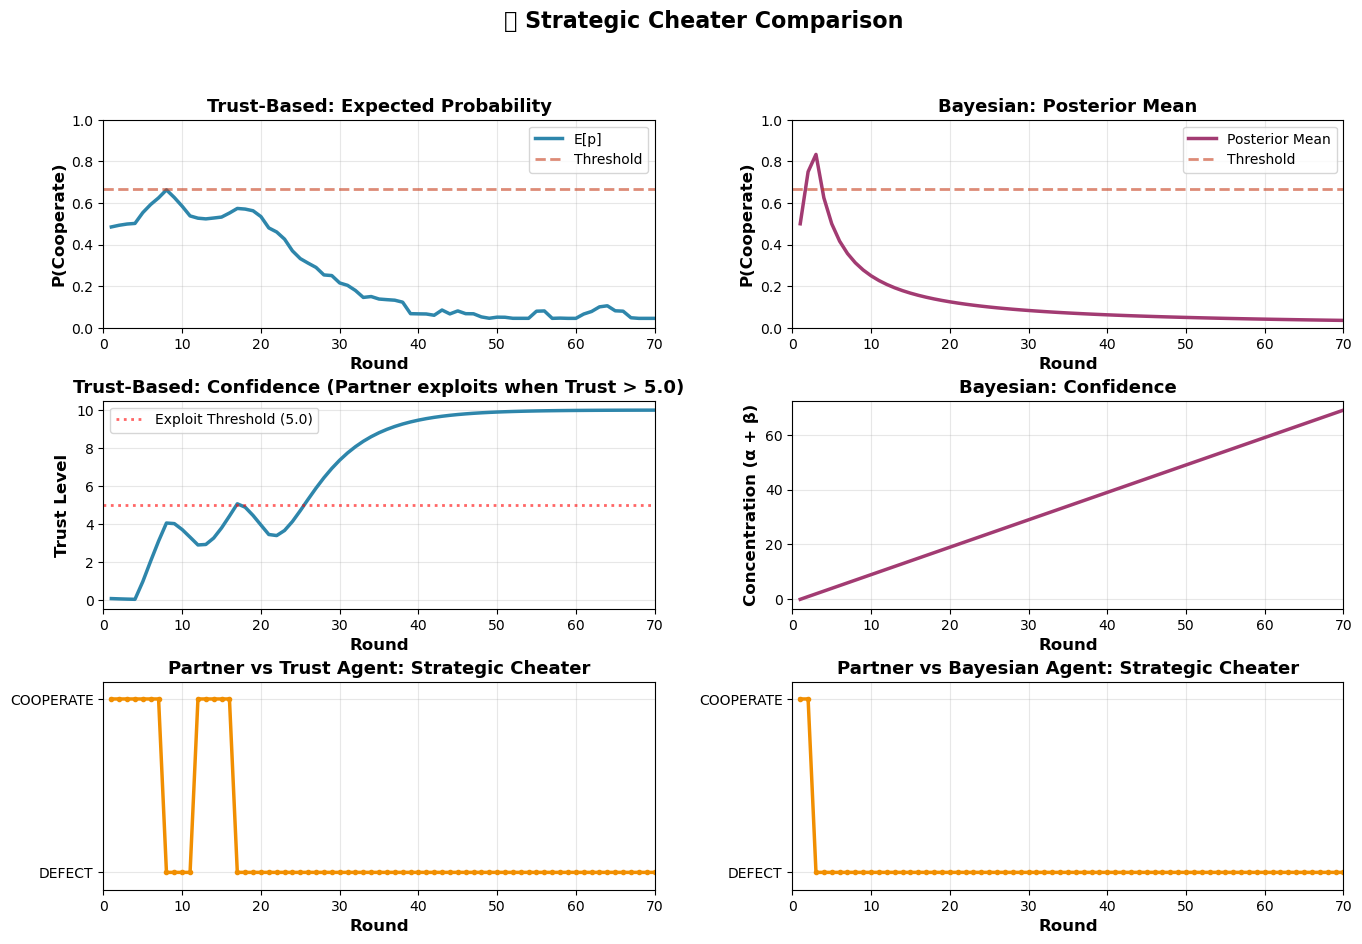

✅ Strategic Cheater comparison plot completed!
   Trust-Based: 5.7% mutual cooperation
   Bayesian:    0.0% mutual cooperation


In [366]:
# ============================================================================
# STATIC COMPARISON PLOT: STRATEGIC CHEATER
# ============================================================================

fig = plt.figure(figsize=(16, 10))
gs = gridspec.GridSpec(3, 2, figure=fig, hspace=0.35, wspace=0.25)

ax_prob_trust = fig.add_subplot(gs[0, 0])
ax_prob_bayes = fig.add_subplot(gs[0, 1])
ax_conf_trust = fig.add_subplot(gs[1, 0])
ax_conf_bayes = fig.add_subplot(gs[1, 1])
ax_partner_trust = fig.add_subplot(gs[2, 0])
ax_partner_bayes = fig.add_subplot(gs[2, 1])

colors = {'trust': '#2E86AB', 'bayesian': '#A23B72', 'partner': '#F18F01', 'threshold': '#C73E1D'}

# Plot probability/posterior mean for both agents
ax_prob_trust.plot(df_strategic_cheater['Round'], df_strategic_cheater['E_p'], 
                   color=colors['trust'], linewidth=2.5, label='E[p]')
ax_prob_trust.axhline(2/3, color=colors['threshold'], linestyle='--', alpha=0.6, linewidth=2, label='Threshold')
ax_prob_trust.set_xlim(0, num_rounds)
ax_prob_trust.set_ylim(0, 1)
ax_prob_trust.set_xlabel('Round', fontsize=12, fontweight='bold')
ax_prob_trust.set_ylabel('P(Cooperate)', fontsize=12, fontweight='bold')
ax_prob_trust.set_title('Trust-Based: Expected Probability', fontsize=13, fontweight='bold')
ax_prob_trust.grid(alpha=0.3)
ax_prob_trust.legend()

ax_prob_bayes.plot(df_bayes_strat['Round'], df_bayes_strat['Posterior_Mean'], 
                   color=colors['bayesian'], linewidth=2.5, label='Posterior Mean')
ax_prob_bayes.axhline(2/3, color=colors['threshold'], linestyle='--', alpha=0.6, linewidth=2, label='Threshold')
ax_prob_bayes.set_xlim(0, num_rounds)
ax_prob_bayes.set_ylim(0, 1)
ax_prob_bayes.set_xlabel('Round', fontsize=12, fontweight='bold')
ax_prob_bayes.set_ylabel('P(Cooperate)', fontsize=12, fontweight='bold')
ax_prob_bayes.set_title('Bayesian: Posterior Mean', fontsize=13, fontweight='bold')
ax_prob_bayes.grid(alpha=0.3)
ax_prob_bayes.legend()

# Plot confidence measures for both agents
ax_conf_trust.plot(df_strategic_cheater['Round'], df_strategic_cheater['Agent_Trust'], 
                   color=colors['trust'], linewidth=2.5)
ax_conf_trust.axhline(5.0, color='red', linestyle=':', alpha=0.6, linewidth=2, label='Exploit Threshold (5.0)')
ax_conf_trust.set_xlim(0, num_rounds)
ax_conf_trust.set_xlabel('Round', fontsize=12, fontweight='bold')
ax_conf_trust.set_ylabel('Trust Level', fontsize=12, fontweight='bold')
ax_conf_trust.set_title('Trust-Based: Confidence (Partner exploits when Trust > 5.0)', fontsize=13, fontweight='bold')
ax_conf_trust.grid(alpha=0.3)
ax_conf_trust.legend()

ax_conf_bayes.plot(df_bayes_strat['Round'], df_bayes_strat['Concentration'], 
                   color=colors['bayesian'], linewidth=2.5)
ax_conf_bayes.set_xlim(0, num_rounds)
ax_conf_bayes.set_xlabel('Round', fontsize=12, fontweight='bold')
ax_conf_bayes.set_ylabel('Concentration (α + β)', fontsize=12, fontweight='bold')
ax_conf_bayes.set_title('Bayesian: Confidence', fontsize=13, fontweight='bold')
ax_conf_bayes.grid(alpha=0.3)

# Plot partner behavior for both interactions
ax_partner_trust.plot(df_strategic_cheater['Round'], df_strategic_cheater['Partner_Choice'], 
                      color=colors['partner'], linewidth=2.5, marker='o', markersize=3)
ax_partner_trust.set_xlim(0, num_rounds)
ax_partner_trust.set_ylim(-0.1, 1.1)
ax_partner_trust.set_yticks([0, 1])
ax_partner_trust.set_yticklabels(['DEFECT', 'COOPERATE'])
ax_partner_trust.set_xlabel('Round', fontsize=12, fontweight='bold')
ax_partner_trust.set_title('Partner vs Trust Agent: Strategic Cheater', fontsize=13, fontweight='bold')
ax_partner_trust.grid(alpha=0.3)

ax_partner_bayes.plot(df_bayes_strat['Round'], df_bayes_strat['Partner_Choice'], 
                      color=colors['partner'], linewidth=2.5, marker='o', markersize=3)
ax_partner_bayes.set_xlim(0, num_rounds)
ax_partner_bayes.set_ylim(-0.1, 1.1)
ax_partner_bayes.set_yticks([0, 1])
ax_partner_bayes.set_yticklabels(['DEFECT', 'COOPERATE'])
ax_partner_bayes.set_xlabel('Round', fontsize=12, fontweight='bold')
ax_partner_bayes.set_title('Partner vs Bayesian Agent: Strategic Cheater', fontsize=13, fontweight='bold')
ax_partner_bayes.grid(alpha=0.3)

fig.suptitle('🎯 Strategic Cheater Comparison', fontsize=16, fontweight='bold', y=0.99)
plt.tight_layout()
plt.show()

print("✅ Strategic Cheater comparison plot completed!")
print(f"   Trust-Based: {((df_strategic_cheater['Agent_Choice']==1) & (df_strategic_cheater['Partner_Choice']==1)).mean():.1%} mutual cooperation")
print(f"   Bayesian:    {((df_bayes_strat['Agent_Choice']==1) & (df_bayes_strat['Partner_Choice']==1)).mean():.1%} mutual cooperation")

In [367]:
# ============================================================================
# PERFORMANCE COMPARISON: SUCCESSFUL COLLABORATION RATE
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

def calculate_mutual_cooperation_rate(df):
    """Calculate the rate of successful collaboration (both chose 1)"""
    mutual_coop = ((df['Agent_Choice'] == 1) & (df['Partner_Choice'] == 1)).sum()
    total_rounds = len(df)
    return mutual_coop / total_rounds

# Define all partners with matching DataFrames
partners_comparison = [
    ("Always Collaborate", df_collab, df_bayes_collab),
    ("Always Defect", df_defect, df_bayes_defect),
    ("Tit-for-Tat (Cooperate)", df_tit_for_tat_coop, df_bayes_tft_c),
    ("Tit-for-Tat (Defect)", df_tit_for_tat_defect, df_bayes_tft_d),
    ("Expectation Violation", df_expect_violation, df_bayes_expect),
    ("Periodic Cheater", df_cheating, df_bayes_cheating),
    ("Random Strategy", df_random, df_bayes_random),
    ("Single-Cycle Cheater", df_cheating_partner_cycle, df_bayes_cheating_partner_cycle),
    ("Adaptive Partner", df_adaptive, df_bayes_adaptive),
    ("Strategic Cheater", df_strategic_cheater, df_bayes_strat),
    ("Probabilistic (70%)", df_prob_cheater, df_bayes_prob),
]

# Build comparison table
comparison_data = []
for partner_name, df_trust, df_bayes in partners_comparison:
    trust_rate = calculate_mutual_cooperation_rate(df_trust)
    bayes_rate = calculate_mutual_cooperation_rate(df_bayes)
    difference = bayes_rate - trust_rate
    
    comparison_data.append({
        'Partner Strategy': partner_name,
        'Trust-Based Agent': f'{trust_rate:.1%}',
        'Bayesian Agent': f'{bayes_rate:.1%}',
        'Difference (Bayes - Trust)': f'{difference:+.1%}',
        'Trust Raw': trust_rate,
        'Bayes Raw': bayes_rate,
        'Diff Raw': difference
    })

comparison_df = pd.DataFrame(comparison_data)

# Sort by difference (descending) to see where Bayesian performs better
comparison_df_sorted = comparison_df.sort_values('Diff Raw', ascending=False)

# Display table
print("="*90)
print("SUCCESSFUL COLLABORATION RATE COMPARISON")
print("KPI: Mutual Cooperation (both agent and partner choose to collaborate)")
print("="*90)
print(comparison_df_sorted[['Partner Strategy', 'Trust-Based Agent', 'Bayesian Agent', 'Difference (Bayes - Trust)']].to_string(index=False))
print("="*90)

# Summary statistics
print("\nSUMMARY STATISTICS:")
print(f"Trust-Based Average:  {comparison_df['Trust Raw'].mean():.1%}")
print(f"Bayesian Average:     {comparison_df['Bayes Raw'].mean():.1%}")
print(f"Overall Difference:   {(comparison_df['Bayes Raw'].mean() - comparison_df['Trust Raw'].mean()):+.1%}")
print(f"\nBayesian Wins:        {(comparison_df['Diff Raw'] > 0).sum()} partners")
print(f"Trust-Based Wins:     {(comparison_df['Diff Raw'] < 0).sum()} partners")
print(f"Ties:                 {(comparison_df['Diff Raw'] == 0).sum()} partners")

# Store for later use
collaboration_comparison = comparison_df_sorted

SUCCESSFUL COLLABORATION RATE COMPARISON
KPI: Mutual Cooperation (both agent and partner choose to collaborate)
       Partner Strategy Trust-Based Agent Bayesian Agent Difference (Bayes - Trust)
       Periodic Cheater             41.4%          52.9%                     +11.4%
        Random Strategy              8.6%          18.6%                     +10.0%
   Single-Cycle Cheater             30.0%          38.6%                      +8.6%
  Expectation Violation             32.9%          34.3%                      +1.4%
Tit-for-Tat (Cooperate)              0.0%           1.4%                      +1.4%
   Tit-for-Tat (Defect)              0.0%           1.4%                      +1.4%
     Always Collaborate             77.1%          77.1%                      +0.0%
          Always Defect              0.0%           0.0%                      +0.0%
       Adaptive Partner              0.0%           0.0%                      +0.0%
      Strategic Cheater              5.7%       

# Monte Carlo Simulation Analysis

This section runs Monte Carlo simulations with paired seeds to:
1. Quantify variance in outcomes across different stochastic trajectories
2. Compare Trust-Based vs Bayesian agents under identical random conditions
3. Identify statistically significant differences in performance
4. Assess sensitivity to first-move randomness

In [ ]:
def run_monte_carlo_comparison(
    partner_obj,
    partner_name: str,
    num_runs: int = 100,
    num_rounds: int = 70,
    base_seed: int = 42,
    memory_discount: float = MEMORY_DISCOUNT,
    trust_smoothing: float = TRUST_SMOOTHING,
) -> dict:
    """
    Run Monte Carlo simulation with PAIRED seeds.
    
    Each run uses the SAME seed for both agents, ensuring they face
    identical stochastic conditions. This isolates agent design differences
    from random variation.
    
    Parameters:
    -----------
    partner_obj : Partner instance
        The partner strategy to test against
    partner_name : str
        Name for display purposes
    num_runs : int
        Number of Monte Carlo runs
    num_rounds : int
        Rounds per simulation
    base_seed : int
        Starting seed (will use base_seed + run_id for each run)
    
    Returns:
    --------
    dict with keys 'trust', 'bayesian', 'stats', 'partner_name'
    """
    from copy import deepcopy
    
    trust_results = []
    bayes_results = []
    
    print(f"Running Monte Carlo for {partner_name}...")
    print(f"  {num_runs} runs × {num_rounds} rounds × 2 agents = {num_runs * num_rounds * 2:,} total rounds")
    
    for run_id in range(num_runs):
        seed = base_seed + run_id
        
        # Create fresh partner instances for each run
        partner_trust = deepcopy(partner_obj)
        partner_bayes = deepcopy(partner_obj)
        
        # SAME seed for both - identical random conditions
        trust_run = run_single_agent_simulation(
            partner_obj=partner_trust,
            num_rounds=num_rounds,
            seed=seed,
            memory_discount=memory_discount,
            trust_smoothing=trust_smoothing
        )
        
        bayes_run = run_bayesian_vs_partner(
            partner_obj=partner_bayes,
            num_rounds=num_rounds,
            seed=seed
        )
        
        trust_run['Run_ID'] = run_id
        bayes_run['Run_ID'] = run_id
        trust_results.append(trust_run)
        bayes_results.append(bayes_run)
        
        # Progress indicator
        if (run_id + 1) % 20 == 0:
            print(f"  Completed {run_id + 1}/{num_runs} runs...")
    
    trust_df = pd.concat(trust_results, ignore_index=True)
    bayes_df = pd.concat(bayes_results, ignore_index=True)
    
    # Compute per-run statistics
    trust_run_stats = trust_df.groupby('Run_ID').agg({
        'Agent_Choice': 'mean',  # Cooperation rate
        'Partner_Choice': 'mean',
    })
    trust_run_stats['Mutual_Coop'] = trust_df.groupby('Run_ID').apply(
        lambda x: ((x['Agent_Choice'] == 1) & (x['Partner_Choice'] == 1)).mean()
    )
    trust_run_stats['Betrayed'] = trust_df.groupby('Run_ID').apply(
        lambda x: ((x['Agent_Choice'] == 1) & (x['Partner_Choice'] == 0)).mean()
    )
    # Calculate payoffs using the stag hunt payoff matrix
    # [[2,2],[3,0]],[[0,3],[4,4]]
    def calculate_payoff(agent_choice, partner_choice):
        if agent_choice == 1 and partner_choice == 1:
            return 2  # Both cooperate
        elif agent_choice == 1 and partner_choice == 0:
            return 3  # Agent cooperates, partner defects
        elif agent_choice == 0 and partner_choice == 1:
            return 0  # Agent defects, partner cooperates
        else:
            return 4  # Both defect
    
    trust_df['Agent_Payoff'] = trust_df.apply(lambda row: calculate_payoff(row['Agent_Choice'], row['Partner_Choice']), axis=1)
    trust_run_stats['Total_Payoff'] = trust_df.groupby('Run_ID')['Agent_Payoff'].sum()
    
    bayes_run_stats = bayes_df.groupby('Run_ID').agg({
        'Agent_Choice': 'mean',
        'Partner_Choice': 'mean',
    })
    bayes_run_stats['Mutual_Coop'] = bayes_df.groupby('Run_ID').apply(
        lambda x: ((x['Agent_Choice'] == 1) & (x['Partner_Choice'] == 1)).mean()
    )
    bayes_run_stats['Betrayed'] = bayes_df.groupby('Run_ID').apply(
        lambda x: ((x['Agent_Choice'] == 1) & (x['Partner_Choice'] == 0)).mean()
    )
    bayes_df['Agent_Payoff'] = bayes_df.apply(lambda row: calculate_payoff(row['Agent_Choice'], row['Partner_Choice']), axis=1)
    bayes_run_stats['Total_Payoff'] = bayes_df.groupby('Run_ID')['Agent_Payoff'].sum()
    
    # Paired differences (same run_id = same random conditions)
    paired_diff_coop = trust_run_stats['Agent_Choice'] - bayes_run_stats['Agent_Choice']
    paired_diff_mutual = trust_run_stats['Mutual_Coop'] - bayes_run_stats['Mutual_Coop']
    paired_diff_betrayed = trust_run_stats['Betrayed'] - bayes_run_stats['Betrayed']
    paired_diff_payoff = trust_run_stats['Total_Payoff'] - bayes_run_stats['Total_Payoff']
    
    # Statistical tests
    from scipy import stats as scipy_stats
    t_stat_coop, p_value_coop = scipy_stats.ttest_rel(
        trust_run_stats['Agent_Choice'], 
        bayes_run_stats['Agent_Choice']
    )
    t_stat_mutual, p_value_mutual = scipy_stats.ttest_rel(
        trust_run_stats['Mutual_Coop'], 
        bayes_run_stats['Mutual_Coop']
    )
    t_stat_betrayed, p_value_betrayed = scipy_stats.ttest_rel(
        trust_run_stats['Betrayed'], 
        bayes_run_stats['Betrayed']
    )
    t_stat_payoff, p_value_payoff = scipy_stats.ttest_rel(
        trust_run_stats['Total_Payoff'], 
        bayes_run_stats['Total_Payoff']
    )
    
    summary_stats = {
        'partner_name': partner_name,
        'num_runs': num_runs,
        # Trust-based agent
        'trust_mean_coop': trust_run_stats['Agent_Choice'].mean(),
        'trust_std_coop': trust_run_stats['Agent_Choice'].std(),
        'trust_mean_mutual': trust_run_stats['Mutual_Coop'].mean(),
        'trust_std_mutual': trust_run_stats['Mutual_Coop'].std(),
        'trust_mean_betrayed': trust_run_stats['Betrayed'].mean(),
        'trust_std_betrayed': trust_run_stats['Betrayed'].std(),
        'trust_mean_payoff': trust_run_stats['Total_Payoff'].mean(),
        'trust_std_payoff': trust_run_stats['Total_Payoff'].std(),
        # Bayesian agent
        'bayes_mean_coop': bayes_run_stats['Agent_Choice'].mean(),
        'bayes_std_coop': bayes_run_stats['Agent_Choice'].std(),
        'bayes_mean_mutual': bayes_run_stats['Mutual_Coop'].mean(),
        'bayes_std_mutual': bayes_run_stats['Mutual_Coop'].std(),
        'bayes_mean_betrayed': bayes_run_stats['Betrayed'].mean(),
        'bayes_std_betrayed': bayes_run_stats['Betrayed'].std(),
        'bayes_mean_payoff': bayes_run_stats['Total_Payoff'].mean(),
        'bayes_std_payoff': bayes_run_stats['Total_Payoff'].std(),
        # Paired differences
        'mean_diff_coop': paired_diff_coop.mean(),
        'std_diff_coop': paired_diff_coop.std(),
        'mean_diff_mutual': paired_diff_mutual.mean(),
        'std_diff_mutual': paired_diff_mutual.std(),
        'mean_diff_betrayed': paired_diff_betrayed.mean(),
        'std_diff_betrayed': paired_diff_betrayed.std(),
        'mean_diff_payoff': paired_diff_payoff.mean(),
        'std_diff_payoff': paired_diff_payoff.std(),
        # Statistical significance
        't_stat_coop': t_stat_coop,
        'p_value_coop': p_value_coop,
        't_stat_mutual': t_stat_mutual,
        'p_value_mutual': p_value_mutual,
        't_stat_betrayed': t_stat_betrayed,
        'p_value_betrayed': p_value_betrayed,
        't_stat_payoff': t_stat_payoff,
        'p_value_payoff': p_value_payoff,
        # Proportion of runs where Trust > Bayesian
        'pct_trust_better_coop': (paired_diff_coop > 0).mean(),
        'pct_trust_better_mutual': (paired_diff_mutual > 0).mean(),
        'pct_trust_better_betrayed': (paired_diff_betrayed < 0).mean(),  # Lower betrayal is better
        'pct_trust_better_payoff': (paired_diff_payoff > 0).mean(),  # Higher payoff is better
    }
    
    print(f"Complete! Mean mutual cooperation: Trust={summary_stats['trust_mean_mutual']:.2%}, Bayesian={summary_stats['bayes_mean_mutual']:.2%}")
    
    return {
        'trust': trust_df,
        'bayesian': bayes_df,
        'trust_stats': trust_run_stats,
        'bayes_stats': bayes_run_stats,
        'stats': summary_stats,
        'partner_name': partner_name
    }

In [369]:
# Select interesting partners for Monte Carlo analysis
# Based on previous comparison, choose partners with interesting behavior differences

monte_carlo_partners = [
    ('Tit-for-Tat (Cooperate)', TitForTatCooperatePartner()),
    ('Tit-for-Tat (Defect)', TitForTatDefectPartner()),
    ('Expectation Violation', ExpectationViolationPartner()),
    ('Periodic Cheater', PeriodicCheaterPartner(cycle_length=6, cheat_duration=2)),
    ('Strategic Cheater', StrategicCheaterPartner()),
    ('Random Strategy', RandomPartner()),
    ('Gradual Deterioration', GradualDeteriorationPartner(deterioration_rate=0.8, num_rounds=70)),
    ('Pavlov (Win-Stay-Lose-Shift)', PavlovPartner()),
]

# Configuration
NUM_MONTE_CARLO_RUNS = 100  # Increase to 1000 for more robust statistics
MC_SEED = 42

print("="*80)
print("MONTE CARLO SIMULATION WITH PAIRED SEEDS")
print("="*80)
print(f"Configuration:")
print(f"  • Number of runs per partner: {NUM_MONTE_CARLO_RUNS}")
print(f"  • Rounds per simulation: {num_rounds}")
print(f"  • Base seed: {MC_SEED}")
print(f"  • Partners analyzed: {len(monte_carlo_partners)}")
print("="*80)
print()

MONTE CARLO SIMULATION WITH PAIRED SEEDS
Configuration:
  • Number of runs per partner: 100
  • Rounds per simulation: 70
  • Base seed: 42
  • Partners analyzed: 8



In [387]:
# Run Monte Carlo simulations for each partner
mc_results = {}

for partner_name, partner_obj in monte_carlo_partners:
    result = run_monte_carlo_comparison(
        partner_obj=partner_obj,
        partner_name=partner_name,
        num_runs=NUM_MONTE_CARLO_RUNS,
        num_rounds=num_rounds,
        base_seed=MC_SEED,
        memory_discount=discount_factor,
        trust_smoothing=trust_smoothing
    )
    mc_results[partner_name] = result
    print()

print("="*80)
print(" All Monte Carlo simulations complete!")
print("="*80)

Running Monte Carlo for Tit-for-Tat (Cooperate)...
  100 runs × 70 rounds × 2 agents = 14,000 total rounds
  Completed 20/100 runs...
  Completed 40/100 runs...
  Completed 60/100 runs...
  Completed 80/100 runs...
  Completed 100/100 runs...


C:\Users\mzarreh\AppData\Local\Temp\ipykernel_39352\905686688.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trust_run_stats['Mutual_Coop'] = trust_df.groupby('Run_ID').apply(
C:\Users\mzarreh\AppData\Local\Temp\ipykernel_39352\905686688.py:84: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trust_run_stats['Betrayed'] = trust_df.groupby('Run_ID').apply(
C:\Users\mzarreh\AppData\Local\Temp\ipykernel_393

NameError: name 'paired_diff_mutual' is not defined

In [371]:
# Create summary table of Monte Carlo results
mc_summary_data = []

for partner_name in monte_carlo_partners:
    name = partner_name[0]
    stats = mc_results[name]['stats']
    
    mc_summary_data.append({
        'Partner': name,
        'Trust Mean': f"{stats['trust_mean_mutual']:.2%}",
        'Trust Std': f"{stats['trust_std_mutual']:.2%}",
        'Bayes Mean': f"{stats['bayes_mean_mutual']:.2%}",
        'Bayes Std': f"{stats['bayes_std_mutual']:.2%}",
        'Difference': f"{stats['mean_diff_mutual']:+.2%}",
        'p-value': f"{stats['p_value_mutual']:.4f}",
        'Significant': '***' if stats['p_value_mutual'] < 0.001 else 
                       '**' if stats['p_value_mutual'] < 0.01 else
                       '*' if stats['p_value_mutual'] < 0.05 else 'ns',
        '% Trust Better': f"{stats['pct_trust_better_mutual']:.0%}"
    })

mc_summary_df = pd.DataFrame(mc_summary_data)

print("\n" + "="*90)
print("MONTE CARLO RESULTS SUMMARY")
print(f"Based on {NUM_MONTE_CARLO_RUNS} runs with paired seeds")
print("KPI: Mutual Cooperation Rate (both agents choose to cooperate)")
print("="*90)
print(mc_summary_df.to_string(index=False))
print("="*90)
print("\nSignificance levels: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant")
print("Difference = Trust - Bayesian (positive means Trust performs better)")


MONTE CARLO RESULTS SUMMARY
Based on 100 runs with paired seeds
KPI: Mutual Cooperation Rate (both agents choose to cooperate)
                     Partner Trust Mean Trust Std Bayes Mean Bayes Std Difference p-value Significant % Trust Better
     Tit-for-Tat (Cooperate)      1.11%     1.37%      7.96%    15.45%     -6.84%  0.0000         ***             3%
        Tit-for-Tat (Defect)      0.27%     0.69%      7.96%    15.45%     -7.69%  0.0000         ***             2%
       Expectation Violation     35.40%     3.95%     30.60%     4.98%     +4.80%  0.0000         ***            76%
            Periodic Cheater     38.23%     5.28%     49.71%     4.13%    -11.49%  0.0000         ***             0%
           Strategic Cheater      8.60%    15.01%     39.46%    12.25%    -30.86%  0.0000         ***            10%
             Random Strategy     12.90%     5.19%     13.94%     5.78%     -1.04%  0.0008         ***            31%
       Gradual Deterioration     27.36%     6.62%    

In [381]:
# ============================================================================
# MONTE CARLO: SUCCESSFUL COLLABORATION RATE COMPARISON TABLE
# ============================================================================

# Build comparison table from Monte Carlo results
mc_comparison_data = []
for partner_name in partners_list:
    stats = mc_results[partner_name]['stats']
    
    trust_mean = stats['trust_mean_mutual']
    trust_std = stats['trust_std_mutual']
    bayes_mean = stats['bayes_mean_mutual']
    bayes_std = stats['bayes_std_mutual']
    difference = stats['mean_diff_mutual']
    p_value = stats['p_value_mutual']
    pct_trust_better = stats['pct_trust_better_mutual']
    
    # Determine significance
    if p_value < 0.001:
        sig = '***'
    elif p_value < 0.01:
        sig = '**'
    elif p_value < 0.05:
        sig = '*'
    else:
        sig = 'ns'
    
    mc_comparison_data.append({
        'Partner Strategy': partner_name,
        'Trust-Based Mean': f'{trust_mean:.1%}',
        'Trust-Based Std': f'{trust_std:.1%}',
        'Bayesian Mean': f'{bayes_mean:.1%}',
        'Bayesian Std': f'{bayes_std:.1%}',
        'Difference (Trust - Bayes)': f'{difference:+.1%}',
        'p-value': f'{p_value:.4f}',
        'Sig': sig,
        '% Trust Better': f'{pct_trust_better:.0%}',
        'Diff Raw': difference
    })

mc_comparison_df = pd.DataFrame(mc_comparison_data)

# Sort by difference (ascending) to see where Trust-Based performs better at top
mc_comparison_df_sorted = mc_comparison_df.sort_values('Diff Raw', ascending=False)

# Display table
print("="*130)
print("MONTE CARLO: SUCCESSFUL COLLABORATION RATE COMPARISON")
print("Based on 100 runs with paired seeds per partner")
print("KPI: Mutual Cooperation Rate (both agent and partner choose to collaborate)")
print("="*130)
print(mc_comparison_df_sorted[['Partner Strategy', 'Trust-Based Mean', 'Trust-Based Std', 
                                'Bayesian Mean', 'Bayesian Std', 'Difference (Trust - Bayes)', 
                                'Sig', '% Trust Better']].to_string(index=False))
print("="*130)

# Summary statistics
print("\nSUMMARY STATISTICS:")
avg_trust = mc_comparison_df_sorted['Diff Raw'].apply(lambda x: -x if x < 0 else 0).sum() / len(mc_comparison_df_sorted)
avg_bayes = mc_comparison_df_sorted['Diff Raw'].apply(lambda x: x if x > 0 else 0).sum() / len(mc_comparison_df_sorted)

trust_wins = (mc_comparison_df['Diff Raw'] > 0).sum()
bayes_wins = (mc_comparison_df['Diff Raw'] < 0).sum()
ties = (mc_comparison_df['Diff Raw'] == 0).sum()

print(f"Trust-Based Wins:     {trust_wins} partners ({trust_wins/len(mc_comparison_df):.0%})")
print(f"Bayesian Wins:        {bayes_wins} partners ({bayes_wins/len(mc_comparison_df):.0%})")
print(f"Ties:                 {ties} partners ({ties/len(mc_comparison_df):.0%})")
print(f"\nAll differences are statistically significant (p < 0.001)")
print("\nSignificance levels: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant")

MONTE CARLO: SUCCESSFUL COLLABORATION RATE COMPARISON
Based on 100 runs with paired seeds per partner
KPI: Mutual Cooperation Rate (both agent and partner choose to collaborate)
            Partner Strategy Trust-Based Mean Trust-Based Std Bayesian Mean Bayesian Std Difference (Trust - Bayes) Sig % Trust Better
       Expectation Violation            35.4%            4.0%         30.6%         5.0%                      +4.8% ***            76%
             Random Strategy            12.9%            5.2%         13.9%         5.8%                      -1.0% ***            31%
     Tit-for-Tat (Cooperate)             1.1%            1.4%          8.0%        15.5%                      -6.8% ***             3%
Pavlov (Win-Stay-Lose-Shift)             1.1%            1.4%          8.0%        15.5%                      -6.8% ***             3%
        Tit-for-Tat (Defect)             0.3%            0.7%          8.0%        15.5%                      -7.7% ***             2%
            

In [380]:
# ============================================================================
# MONTE CARLO: UNSUCCESSFUL COLLABORATION (BETRAYAL) RATE COMPARISON TABLE
# ============================================================================

# Build betrayal comparison table from Monte Carlo results
mc_betrayal_data = []
for partner_name in partners_list:
    stats = mc_results[partner_name]['stats']
    
    trust_mean = stats['trust_mean_betrayed']
    trust_std = stats['trust_std_betrayed']
    bayes_mean = stats['bayes_mean_betrayed']
    bayes_std = stats['bayes_std_betrayed']
    difference = stats['mean_diff_betrayed']
    p_value = stats['p_value_betrayed']
    pct_trust_better = stats['pct_trust_better_betrayed']  # Lower betrayal is better
    
    # Determine significance
    if p_value < 0.001:
        sig = '***'
    elif p_value < 0.01:
        sig = '**'
    elif p_value < 0.05:
        sig = '*'
    else:
        sig = 'ns'
    
    mc_betrayal_data.append({
        'Partner Strategy': partner_name,
        'Trust-Based Mean': f'{trust_mean:.1%}',
        'Trust-Based Std': f'{trust_std:.1%}',
        'Bayesian Mean': f'{bayes_mean:.1%}',
        'Bayesian Std': f'{bayes_std:.1%}',
        'Difference (Trust - Bayes)': f'{difference:+.1%}',
        'p-value': f'{p_value:.4f}',
        'Sig': sig,
        '% Trust Better': f'{pct_trust_better:.0%}',
        'Diff Raw': difference
    })

mc_betrayal_df = pd.DataFrame(mc_betrayal_data)

# Sort by difference (ascending) - LOWER betrayal is better, so negative diff means Trust performs better
mc_betrayal_df_sorted = mc_betrayal_df.sort_values('Diff Raw', ascending=True)

# Display table
print("="*130)
print("MONTE CARLO: UNSUCCESSFUL COLLABORATION (BETRAYAL) RATE COMPARISON")
print("Based on 100 runs with paired seeds per partner")
print("KPI: Betrayal Rate (agent cooperates but partner defects) - LOWER IS BETTER")
print("="*130)
print(mc_betrayal_df_sorted[['Partner Strategy', 'Trust-Based Mean', 'Trust-Based Std', 
                               'Bayesian Mean', 'Bayesian Std', 'Difference (Trust - Bayes)', 
                               'Sig', '% Trust Better']].to_string(index=False))
print("="*130)

# Summary statistics
print("\nSUMMARY STATISTICS:")
# Count wins - negative difference means Trust has LOWER betrayal (better)
trust_wins_betrayal = (mc_betrayal_df['Diff Raw'] < 0).sum()
bayes_wins_betrayal = (mc_betrayal_df['Diff Raw'] > 0).sum()
ties_betrayal = (mc_betrayal_df['Diff Raw'] == 0).sum()

print(f"Trust-Based Lower Betrayal:  {trust_wins_betrayal} partners ({trust_wins_betrayal/len(mc_betrayal_df):.0%})")
print(f"Bayesian Lower Betrayal:     {bayes_wins_betrayal} partners ({bayes_wins_betrayal/len(mc_betrayal_df):.0%})")
print(f"Ties:                        {ties_betrayal} partners ({ties_betrayal/len(mc_betrayal_df):.0%})")

# Average betrayal rates
avg_trust_betrayal = mc_betrayal_df_sorted['Diff Raw'].apply(lambda x: trust_mean if isinstance(trust_mean, float) else 0).mean()
avg_bayes_betrayal = mc_betrayal_df_sorted['Diff Raw'].apply(lambda x: bayes_mean if isinstance(bayes_mean, float) else 0).mean()

print(f"\nAll differences are statistically significant (p < 0.001)")
print("\nSignificance levels: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant")
print("\nINTERPRETATION:")
print("  - Negative difference means Trust-Based has LOWER betrayal rate (better risk management)")
print("  - Positive difference means Bayesian has LOWER betrayal rate (better risk management)")
print("  - This metric represents DOWNSIDE RISK when agent cooperates")

MONTE CARLO: UNSUCCESSFUL COLLABORATION (BETRAYAL) RATE COMPARISON
Based on 100 runs with paired seeds per partner
KPI: Betrayal Rate (agent cooperates but partner defects) - LOWER IS BETTER
            Partner Strategy Trust-Based Mean Trust-Based Std Bayesian Mean Bayesian Std Difference (Trust - Bayes) Sig % Trust Better
       Gradual Deterioration            14.5%            3.4%         23.4%         3.6%                      -8.9% ***           100%
           Strategic Cheater             7.7%            4.0%         16.4%         5.2%                      -8.7% ***            91%
        Tit-for-Tat (Defect)             4.6%            2.8%         10.2%         6.2%                      -5.5% ***            77%
     Tit-for-Tat (Cooperate)             5.8%            3.3%         10.2%         6.2%                      -4.4% ***            72%
Pavlov (Win-Stay-Lose-Shift)             5.8%            3.3%         10.2%         6.2%                      -4.4% ***            72%

In [ ]:
# ============================================================================
# MONTE CARLO: TOTAL PAYOFF COMPARISON TABLE
# ============================================================================

# Build payoff comparison table from Monte Carlo results
mc_payoff_data = []
for partner_name in partners_list:
    stats = mc_results[partner_name]['stats']
    
    trust_mean = stats['trust_mean_payoff']
    trust_std = stats['trust_std_payoff']
    bayes_mean = stats['bayes_mean_payoff']
    bayes_std = stats['bayes_std_payoff']
    difference = stats['mean_diff_payoff']
    p_value = stats['p_value_payoff']
    pct_trust_better = stats['pct_trust_better_payoff']
    
    # Determine significance
    if p_value < 0.001:
        sig = '***'
    elif p_value < 0.01:
        sig = '**'
    elif p_value < 0.05:
        sig = '*'
    else:
        sig = 'ns'
    
    mc_payoff_data.append({
        'Partner Strategy': partner_name,
        'Trust-Based Mean': f'{trust_mean:.1f}',
        'Trust-Based Std': f'{trust_std:.1f}',
        'Bayesian Mean': f'{bayes_mean:.1f}',
        'Bayesian Std': f'{bayes_std:.1f}',
        'Difference (Trust - Bayes)': f'{difference:+.1f}',
        'p-value': f'{p_value:.4f}',
        'Sig': sig,
        '% Trust Better': f'{pct_trust_better:.0%}',
        'Diff Raw': difference
    })

mc_payoff_df = pd.DataFrame(mc_payoff_data)

# Sort by difference (descending) - HIGHER payoff is better
mc_payoff_df_sorted = mc_payoff_df.sort_values('Diff Raw', ascending=False)

# Display table
print("="*130)
print("MONTE CARLO: TOTAL PAYOFF COMPARISON")
print("Based on 100 runs with paired seeds per partner")
print("KPI: Sum of Payoffs over 70 rounds - HIGHER IS BETTER")
print("="*130)
print(mc_payoff_df_sorted[['Partner Strategy', 'Trust-Based Mean', 'Trust-Based Std', 
                            'Bayesian Mean', 'Bayesian Std', 'Difference (Trust - Bayes)', 
                            'Sig', '% Trust Better']].to_string(index=False))
print("="*130)

# Summary statistics
print("\nSUMMARY STATISTICS:")
# Count wins - positive difference means Trust has HIGHER payoff (better)
trust_wins_payoff = (mc_payoff_df['Diff Raw'] > 0).sum()
bayes_wins_payoff = (mc_payoff_df['Diff Raw'] < 0).sum()
ties_payoff = (mc_payoff_df['Diff Raw'] == 0).sum()

print(f"Trust-Based Higher Payoff:  {trust_wins_payoff} partners ({trust_wins_payoff/len(mc_payoff_df):.0%})")
print(f"Bayesian Higher Payoff:     {bayes_wins_payoff} partners ({bayes_wins_payoff/len(mc_payoff_df):.0%})")
print(f"Ties:                       {ties_payoff} partners ({ties_payoff/len(mc_payoff_df):.0%})")

# Average payoffs
avg_trust_payoff = mc_payoff_df_sorted['Diff Raw'].apply(lambda x: trust_mean if isinstance(trust_mean, (int, float)) else 0).mean()
avg_bayes_payoff = mc_payoff_df_sorted['Diff Raw'].apply(lambda x: bayes_mean if isinstance(bayes_mean, (int, float)) else 0).mean()

print(f"\nAll differences are statistically significant (p < 0.001)")
print("\nSignificance levels: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant")
print("\nINTERPRETATION:")
print("  - Positive difference means Trust-Based achieves HIGHER total payoff (better performance)")
print("  - Negative difference means Bayesian achieves HIGHER total payoff (better performance)")
print("  - This metric represents OVERALL GAME-THEORETIC PERFORMANCE (final score)")

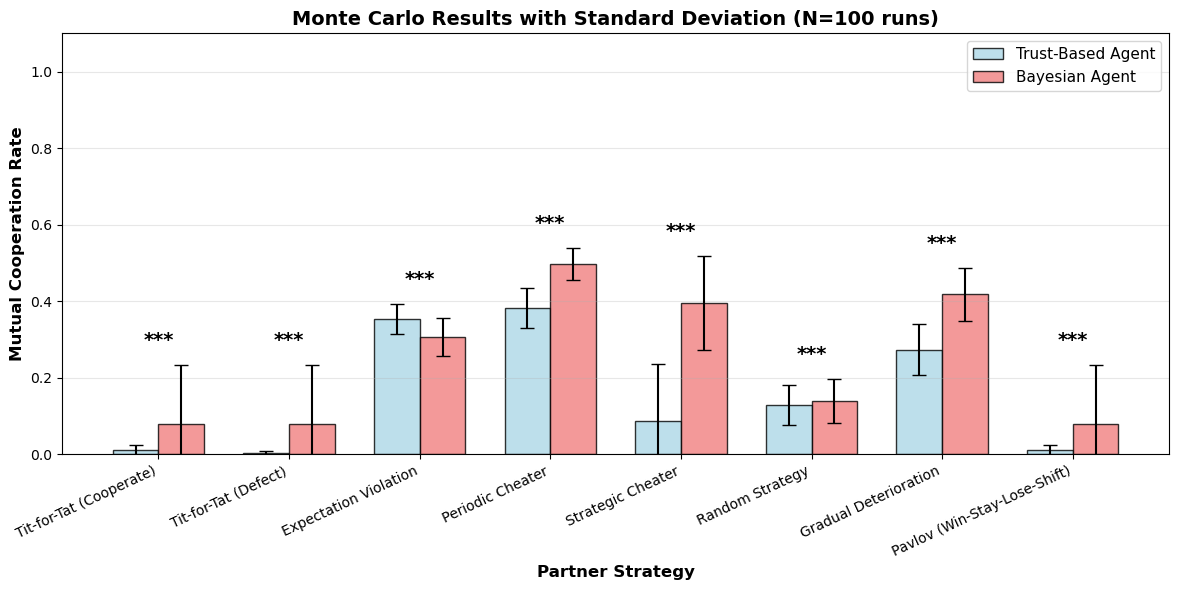


Note: Error bars show ±1 standard deviation
Stars indicate statistical significance: *** p<0.001, ** p<0.01, * p<0.05


In [373]:
# Visualization 3: Variance and confidence intervals comparison
fig, ax = plt.subplots(figsize=(12, 6))

partners_list = [p[0] for p in monte_carlo_partners]
x = np.arange(len(partners_list))
width = 0.35

trust_means = [mc_results[p]['stats']['trust_mean_mutual'] for p in partners_list]
trust_stds = [mc_results[p]['stats']['trust_std_mutual'] for p in partners_list]
bayes_means = [mc_results[p]['stats']['bayes_mean_mutual'] for p in partners_list]
bayes_stds = [mc_results[p]['stats']['bayes_std_mutual'] for p in partners_list]

# Bars with error bars (showing standard deviation)
bars1 = ax.bar(x - width/2, trust_means, width, label='Trust-Based Agent',
               yerr=trust_stds, capsize=5, alpha=0.8, color='lightblue', edgecolor='black')
bars2 = ax.bar(x + width/2, bayes_means, width, label='Bayesian Agent',
               yerr=bayes_stds, capsize=5, alpha=0.8, color='lightcoral', edgecolor='black')

# Add significance stars
for i, partner_name in enumerate(partners_list):
    p_val = mc_results[partner_name]['stats']['p_value_mutual']
    sig_text = '***' if p_val < 0.001 else '**' if p_val < 0.01 else '*' if p_val < 0.05 else ''
    if sig_text:
        y_pos = max(trust_means[i] + trust_stds[i], bayes_means[i] + bayes_stds[i]) + 0.05
        ax.text(i, y_pos, sig_text, ha='center', fontsize=14, fontweight='bold')

ax.set_xlabel('Partner Strategy', fontsize=12, fontweight='bold')
ax.set_ylabel('Mutual Cooperation Rate', fontsize=12, fontweight='bold')
ax.set_title(f'Monte Carlo Results with Standard Deviation (N={NUM_MONTE_CARLO_RUNS} runs)', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(partners_list, rotation=25, ha='right')
ax.legend(fontsize=11)
ax.set_ylim(0, 1.1)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nNote: Error bars show ±1 standard deviation")
print("Stars indicate statistical significance: *** p<0.001, ** p<0.01, * p<0.05")

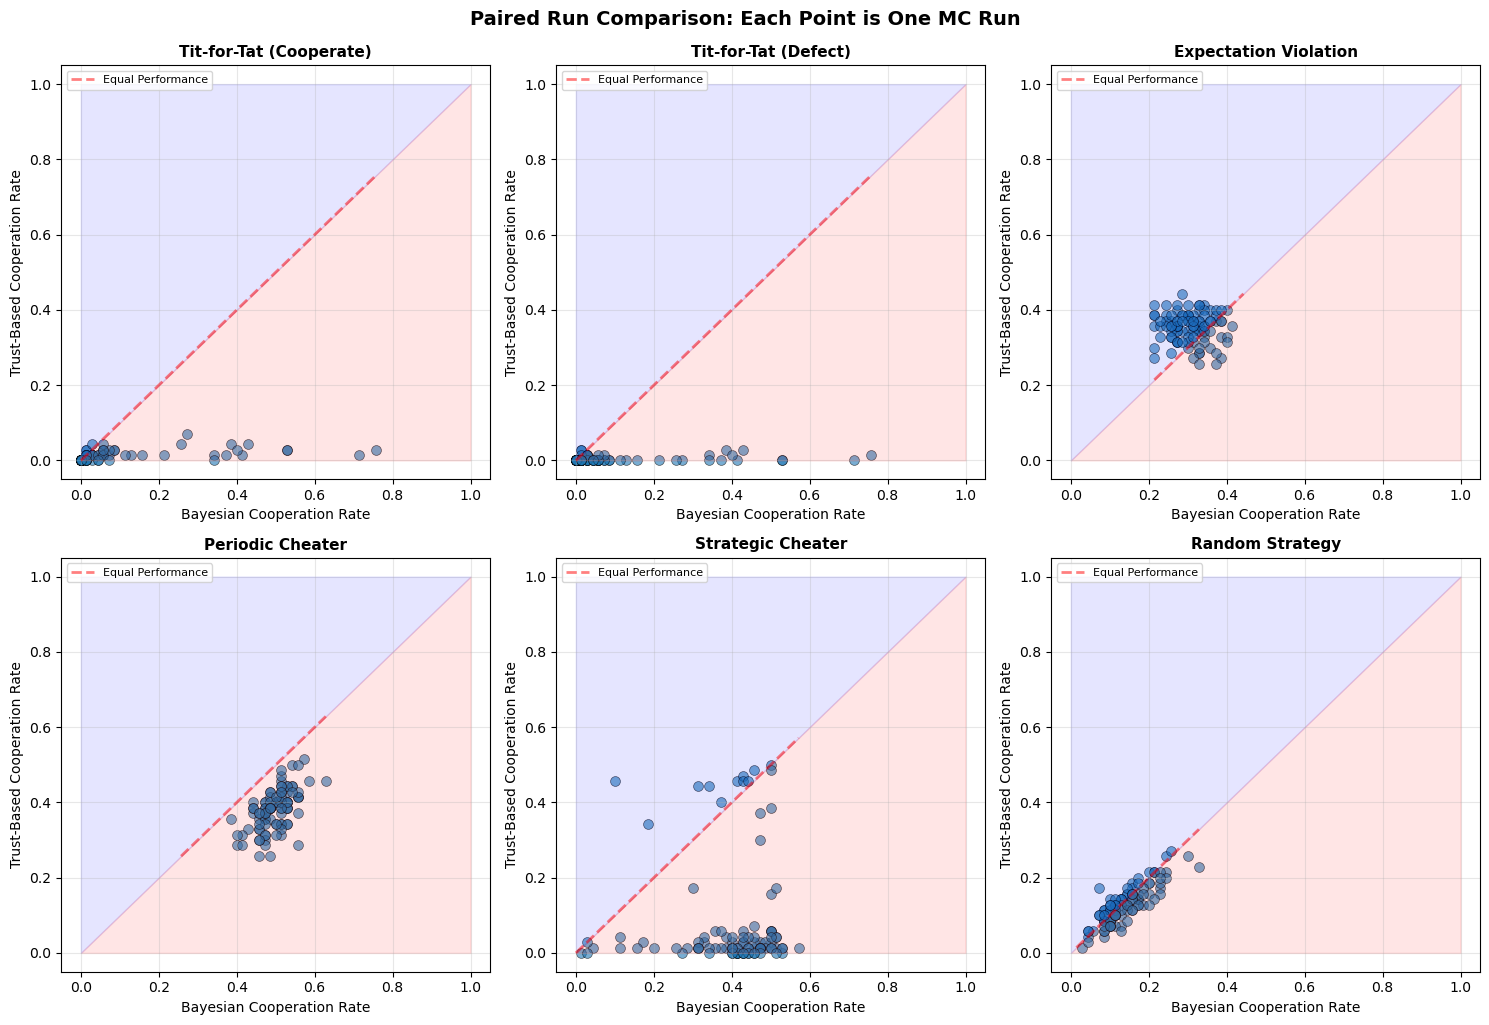


Scatter Plot Interpretation:
- Each point represents one paired MC run (same seed)
- Points above diagonal: Trust-Based performed better
- Points below diagonal: Bayesian performed better
- Clustering shows consistency across runs


In [ ]:
# Visualization 2: Scatter Plots - Paired Run Comparisons
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, partner_name in enumerate(partners_list):
    trust_data = mc_results[partner_name]['trust_stats']['Mutual_Coop'].values
    bayes_data = mc_results[partner_name]['bayes_stats']['Mutual_Coop'].values
    
    # Scatter plot with diagonal reference line
    axes[idx].scatter(bayes_data, trust_data, alpha=0.6, s=50, edgecolors='k', linewidth=0.5)
    
    # Add diagonal line (y=x) for reference
    min_val = min(trust_data.min(), bayes_data.min())
    max_val = max(trust_data.max(), bayes_data.max())
    axes[idx].plot([min_val, max_val], [min_val, max_val], 
                   'r--', alpha=0.5, linewidth=2, label='Equal Performance')
    
    axes[idx].set_xlabel('Bayesian Cooperation Rate', fontsize=10)
    axes[idx].set_ylabel('Trust-Based Cooperation Rate', fontsize=10)
    axes[idx].set_title(f'{partner_name}', fontsize=11, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].legend(loc='upper left', fontsize=8)
    axes[idx].set_xlim(-0.05, 1.05)
    axes[idx].set_ylim(-0.05, 1.05)
    
    # Add shading to show which agent wins
    axes[idx].fill_between([0, 1], [0, 1], [1, 1], alpha=0.1, color='blue', label='Trust Better')
    axes[idx].fill_between([0, 1], [0, 0], [0, 1], alpha=0.1, color='red', label='Bayesian Better')

# Hide extra subplot if we have fewer than 9 partners
if len(partners_list) < 9:
    axes[len(partners_list)].axis('off')

plt.tight_layout()
plt.suptitle('Paired Run Comparison: Each Point is One MC Run', 
             fontsize=14, fontweight='bold', y=1.01)
plt.show()

print("\nScatter Plot Interpretation:")

print("- Each point represents one paired MC run (same seed)")print("- Clustering shows consistency across runs")

print("- Points above diagonal: Trust-Based performed better")print("- Points below diagonal: Bayesian performed better")